# Caso: Atención hospitalaria de pacientes con COVID-19. ¿Se pueden agrupar los pacientes según sus características de ingreso?

Se disponen de datos de pacientes hospitalizados por COVID-19 de cuatro clínicas en ciudades diferentes de Colombia. Las variables incluyen aspectos demográficos, síntomas al ingreso, variables de examen físico, algunas clasificaciones clínicas y desenlaces (ingreso a unidad de cuidados intensivos-UCI y muerte). Esta base de datos ha sido previamente usada por nuestro grupo de trabajo para la realización de modelos supervisados, en los que buscábamos predecir el ingreso a UCI. 

En el presente trabajo, consideramos que es oportuno retomar estos datos y aplicarlos en el contexto de aprendizaje no supervisado con el fin de aplicar técnicas de reducción de la dimensionalidad y además nos interesaría poder encontrar grupos de pacientes con características particulares que ingresan a hospitalización. Esto podría tener aplicabilidad al momento de la atención inicial, ya que dependiendo de las características de los pacientes de cada grupo se podría ajustar el tipo de tratamiento brindado.    

Los potenciales interesados en este tipo de análisis son múltiples, incluyendo:

* Clínicas, hospitales y demás instituciones prestadoras de servicios de salud, tanto del sector público como privado.
* Entidades administradoras de planes de beneficios en salud
* Consorcios de IPS's
* Médicos, enfermeras y demás profesionales de la salud
* Pacientes
* Comunidad en general

Muchos de los cuales pueden ser clientes directos interesados en aplicar este tipo de procesamiento y análisis en sus instituciones. En el caso particular de los datos empleados en este proyecto, su fuente consiste en cuatro clínicas privadas del país. La información se obtuvo con su respectivo aval institucional y contó además con el aval de un comité de ética en investigación.  


**Equipo de trabajo:**

El equipo de trabajo está compuesto por cuatro personas, con diversos perfiles académicos y profesionales. Se cuenta con dos personas profesionales en administración de empresas y un profesional en ingeniería industrial, con experiencia en el análisis y la utilización de datos para la toma de decisiones en áreas de producción, administración, laboral y la banca. Además, un médico con experiencia en epidemiología e investigación. Algunas de las labores serán lideradas por cada uno de nosotros según se perfil, pero en general todos estuvimos inmersos en el proceso de preparación, transformación y análisis de los datos, así como en la creación de los modelos de aprendizaje no supervisado. 


**Librerias**

In [385]:
# Importar paquetes

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import OrdinalEncoder
# from gower import gower_matrix
#from scipy.stats import mannwhitneyu

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from pca import pca
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from kneed import KneeLocator
# from mpl_toolkits.mplot3d import Axes3D
# import plotly.express as px

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

#Librería para imputación múltiple
import miceforest as mf


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### 2. Exploración de los datos

**Importar Datos**

In [386]:
base = pd.read_excel("BD_Morbimortalidad-COVID-19_ANS.xlsx")
base

Hombre  Edad (años) Lugar de atención  Nivel educativo Afiliación SGSSS  \
0         1           52           Pereira  Sin informacion     Contributivo   
1         0           71           Pereira  Sin informacion     Contributivo   
2         0           28           Pereira  Sin informacion     Contributivo   
3         0           40           Pereira      Profesional     Contributivo   
4         1           46           Pereira       Secundaria     Contributivo   
..      ...          ...               ...              ...              ...   
769       0           70            Bogotá  Sin informacion     Contributivo   
770       1           44            Bogotá  Sin informacion     Contributivo   
771       1           47            Bogotá  Sin informacion     Contributivo   
772       1           65            Bogotá  Sin informacion     Contributivo   
773       1           53            Bogotá  Sin informacion       Subsidiado   

     Indice de Charlson  Embarazo_si_no  Sintomas_n  Disnea         TAM  ...  \
0                     1               0           5       1  108.666667  ...   
1                     3               0           3       1  112.666667  ...   
2                     0               0          10       1  101.000000  ...   
3                     0               0           2       0  113.666667  ...   
4                     0               0           7       0   93.333333  ...   
..                  ...             ...         ...     ...         ...  ...   
769                   3               0           6       0  109.666667  ...   
770                   0               0           5       1   94.666667  ...   
771                   2               0           4       0   93.333333  ...   
772                   3               0           2       1  105.333333  ...   
773                   1               0           6       1   94.666667  ...   

     Disfonia  Sincope  Estertores  Roncus  Sibilancias  Tirajes  \
0           0        0           1       0            0        0   
1           0        0           1       0            0        0   
2           0        0           1       0            0        0   
3           0        0           0       0            0        0   
4           0        0           0       0            0        0   
..        ...      ...         ...     ...          ...      ...   
769         0        0           0       0            0        0   
770         0        0           0       1            0        0   
771         0        0           0       0            0        0   
772         0        0           1       0            0        0   
773         0        0           1       0            0        0   

     Hipoventilacion  Deshidratacion  Rx_ingreso_Con_alteraciones_si_no  \
0                  1               0                                  1   
1                  1               0                                  1   
2                  1               0                                  1   
3                  0               0                                  0   
4                  0               0                                  1   
..               ...             ...                                ...   
769                0               0                                  0   
770                0               0                                  0   
771                0               0                                  0   
772                1               0                                  1   
773                0               0                                  0   

        Gravedad del COVID-19  
0              Neumonia grave  
1              Neumonia grave  
2    Enfermedad no complicada  
3    Enfermedad no complicada  
4               Neumonia leve  
..                        ...  
769  Enfermedad no complicada  
770            Neumonia grave  
771            Neumonia grave  
772            Neumonia grave  
773          

In [387]:
base.shape

(774, 118)

In [388]:
base.columns

Index(['Hombre', 'Edad (años)', 'Lugar de atención', 'Nivel educativo',
       'Afiliación SGSSS', 'Indice de Charlson', 'Embarazo_si_no',
       'Sintomas_n', 'Disnea', 'TAM',
       ...
       'Disfonia', 'Sincope', 'Estertores', 'Roncus', 'Sibilancias', 'Tirajes',
       'Hipoventilacion', 'Deshidratacion',
       'Rx_ingreso_Con_alteraciones_si_no', 'Gravedad del COVID-19'],
      dtype='object', length=118)

In [389]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Columns: 118 entries, Hombre to Gravedad del COVID-19
dtypes: float64(12), int64(102), object(4)
memory usage: 713.7+ KB


In [390]:
for column in base.columns:
    print(column)

Hombre
Edad (años)
Lugar de atención
Nivel educativo
Afiliación SGSSS
Indice de Charlson
Embarazo_si_no
Sintomas_n
Disnea
TAM
FC ingreso
FR ingreso
T ingreso
Sat02 ingreso
Conciencia_alterada
CURB-65_calculado
Score News2_calculado
Oxigeno suplementario
Posición del paciente en prono
Complicaciones_n
Complicaciones_si_no
Hb ingreso
Hto ingreso
Leucocitos ingreso
Neutrofilos n absoluto ingreso
Linfocitos n absoluto ingreso
Plaquetas ingreso
Creatinina ingreso
Con_alteraciones_si_no
Ingreso a UCI
Muerto_si_no
Accidente cerebrovascular
Artritis reumatoide
Asma
Cardiopatia isquemica
Cirrosis/enfermedad hepática crónica
Demencia
Diabetes mellitus
Dislipidemia
Enfermedad de Parkinson
Enfermedad renal crónica
Enfermedad valvular
EPOC
Falla cardiaca
Hipertensión arterial
Hipotiroidismo
Lupus eritematoso sistémico
Neoplasia hematológica
Neoplasia sólida
Obesidad
Tabaquismo
Taquiarritmias supraventriculares
Transplantes
VIH
SAHOS
Epilepsia
HPB
TVP
Trastornos psiquiatricos
IECA/ARA2_si_no
Otros a

**Verificando resumen de estadísticos**

In [391]:
base.describe().T

count       mean        std   min   25%  \
Hombre                             774.0   0.614987   0.486913   0.0   0.0   
Edad (años)                        774.0  56.891473  16.673521  19.0  45.0   
Indice de Charlson                 774.0   2.042636   2.018541   0.0   0.0   
Embarazo_si_no                     774.0   0.018088   0.133355   0.0   0.0   
Sintomas_n                         774.0   4.099483   1.701282   1.0   3.0   
...                                  ...        ...        ...   ...   ...   
Sibilancias                        774.0   0.029716   0.169912   0.0   0.0   
Tirajes                            774.0   0.073643   0.261359   0.0   0.0   
Hipoventilacion                    774.0   0.218346   0.413391   0.0   0.0   
Deshidratacion                     774.0   0.040052   0.196207   0.0   0.0   
Rx_ingreso_Con_alteraciones_si_no  774.0   0.505168   0.500297   0.0   0.0   

                                    50%   75%    max  
Hombre                              1.0   1.0    1.0  
Edad (años)                        57.0  68.0  100.0  
Indice de Charlson                  2.0   3.0   11.0  
Embarazo_si_no                      0.0   0.0    1.0  
Sintomas_n                          4.0   5.0   10.0  
...                                 ...   ...    ...  
Sibilancias                         0.0   0.0    1.0  
Tirajes                             0.0   0.0    1.0  
Hipoventilacion                     0.0   0.0    1.0  
Deshidratacion                      0.0   0.0    1.0  
Rx_ingreso_Con_alteraciones_si_no   1.0   1.0    1.0  

[114 rows x 8 columns]

In [392]:
#Solo variables cuantitativas
base.describe(exclude=['object']).T

count       mean        std   min   25%  \
Hombre                             774.0   0.614987   0.486913   0.0   0.0   
Edad (años)                        774.0  56.891473  16.673521  19.0  45.0   
Indice de Charlson                 774.0   2.042636   2.018541   0.0   0.0   
Embarazo_si_no                     774.0   0.018088   0.133355   0.0   0.0   
Sintomas_n                         774.0   4.099483   1.701282   1.0   3.0   
...                                  ...        ...        ...   ...   ...   
Sibilancias                        774.0   0.029716   0.169912   0.0   0.0   
Tirajes                            774.0   0.073643   0.261359   0.0   0.0   
Hipoventilacion                    774.0   0.218346   0.413391   0.0   0.0   
Deshidratacion                     774.0   0.040052   0.196207   0.0   0.0   
Rx_ingreso_Con_alteraciones_si_no  774.0   0.505168   0.500297   0.0   0.0   

                                    50%   75%    max  
Hombre                              1.0   1.0    1.0  
Edad (años)                        57.0  68.0  100.0  
Indice de Charlson                  2.0   3.0   11.0  
Embarazo_si_no                      0.0   0.0    1.0  
Sintomas_n                          4.0   5.0   10.0  
...                                 ...   ...    ...  
Sibilancias                         0.0   0.0    1.0  
Tirajes                             0.0   0.0    1.0  
Hipoventilacion                     0.0   0.0    1.0  
Deshidratacion                      0.0   0.0    1.0  
Rx_ingreso_Con_alteraciones_si_no   1.0   1.0    1.0  

[114 rows x 8 columns]

**Verificando si hay datos nulos**

In [393]:
print(base.isnull().any())
print('Variables con faltantes:',base.isnull().any().sum())

Hombre                               False
Edad (años)                          False
Lugar de atención                    False
Nivel educativo                      False
Afiliación SGSSS                     False
                                     ...  
Tirajes                              False
Hipoventilacion                      False
Deshidratacion                       False
Rx_ingreso_Con_alteraciones_si_no    False
Gravedad del COVID-19                False
Length: 118, dtype: bool
Variables con faltantes: 12


Hay 12 variables con datos faltantes

In [394]:
#Verificando cantidad y porcentaje de nulos en los predictores
def tablanull(df):
    Nvalues = pd.DataFrame(df.isnull().sum())
    Nvalues[1] = round((Nvalues[0]/len(df)*100),2)
    Nvalues.columns = ['Nulos Totales','Porcentaje de Nulos']
    Nvalues = Nvalues[Nvalues['Nulos Totales'] > 0] # filter out rows with zero null values
    Nvalues = Nvalues.sort_values(by='Porcentaje de Nulos', ascending=False)
    return Nvalues
tablanull(base)

Nulos Totales  Porcentaje de Nulos
Creatinina ingreso                        151                19.51
Linfocitos n absoluto ingreso             109                14.08
Neutrofilos n absoluto ingreso             97                12.53
Hb ingreso                                 80                10.34
Hto ingreso                                80                10.34
Plaquetas ingreso                          80                10.34
Leucocitos ingreso                         79                10.21
T ingreso                                  33                 4.26
TAM                                        25                 3.23
FR ingreso                                 24                 3.10
Sat02 ingreso                              23                 2.97
FC ingreso                                 22                 2.84

### Variables categóricas
No dummies

In [395]:
base_cat = base.select_dtypes(exclude=['int', 'float']) #seleccionamos solo las variables categóricas para ver sus frecuencias
for col in base_cat.columns:
    print("\n"+'\033[1m' + col + '\033[0m' + "\n") #poner negrita en cada nombre de variable
    print(base_cat[col].unique()) # categorías únicas dentro de cada variable
    print(base_cat[col].value_counts())
    print("Valores perdidos:", base_cat[col].isnull().sum()) #verificamos perdidos x v/ble


Lugar de atención

['Pereira' 'Bogotá' 'Cali' 'Popayan']
Lugar de atención
Bogotá     304
Cali       302
Pereira     96
Popayan     72
Name: count, dtype: int64
Valores perdidos: 0

Nivel educativo

['Sin informacion' 'Profesional' 'Secundaria' 'Primaria' 'Tecnico'
 'Postgrado' 'secundaria ' 'secundaria' 'primaria']
Nivel educativo
Sin informacion    604
Secundaria          41
Profesional         39
Primaria            35
Tecnico             27
secundaria          20
secundaria           4
Postgrado            2
primaria             2
Name: count, dtype: int64
Valores perdidos: 0

Afiliación SGSSS

['Contributivo' 'Otro' 'Subsidiado' 'Sin información']
Afiliación SGSSS
Contributivo       670
Subsidiado          92
Otro                11
Sin información      1
Name: count, dtype: int64
Valores perdidos: 0

Gravedad del COVID-19

['Neumonia grave' 'Enfermedad no complicada' 'Neumonia leve']
Gravedad del COVID-19
Neumonia grave              427
Enfermedad no complicada    181
Neumonia le

### Variables dicotómicas y cuantitativas 

In [396]:
base_cont = base.select_dtypes(include=['int', 'float']) #seleccionamos solo las variables numéricas
for col in base_cont.columns:
    print("\n"+'\033[1m' + col + '\033[0m' + "\n") #poner negrita en cada nombre de variable
    print(base_cont[col].value_counts())
    print("Valores perdidos:", base_cont[col].isnull().sum()) #verificamos perdidos x v/ble


Hombre

Hombre
1    476
0    298
Name: count, dtype: int64
Valores perdidos: 0

Edad (años)

Edad (años)
54    26
60    24
53    23
56    23
65    22
      ..
94     2
88     2
22     2
21     2
95     1
Name: count, Length: 77, dtype: int64
Valores perdidos: 0

Indice de Charlson

Indice de Charlson
0     211
1     168
2     131
3     104
4      62
5      49
6      25
8      12
7       7
11      2
10      2
9       1
Name: count, dtype: int64
Valores perdidos: 0

Embarazo_si_no

Embarazo_si_no
0    760
1     14
Name: count, dtype: int64
Valores perdidos: 0

Sintomas_n

Sintomas_n
4     167
3     159
5     154
2     107
6      76
7      53
1      36
8      18
9       3
10      1
Name: count, dtype: int64
Valores perdidos: 0

Disnea

Disnea
1    523
0    251
Name: count, dtype: int64
Valores perdidos: 0

TAM

TAM
96.666667     27
93.333333     25
83.333333     24
86.666667     23
90.000000     23
              ..
144.000000     1
114.666667     1
111.000000     1
112.333333     1
85.33

### Análisis de correlaciones

Matriz de correlación


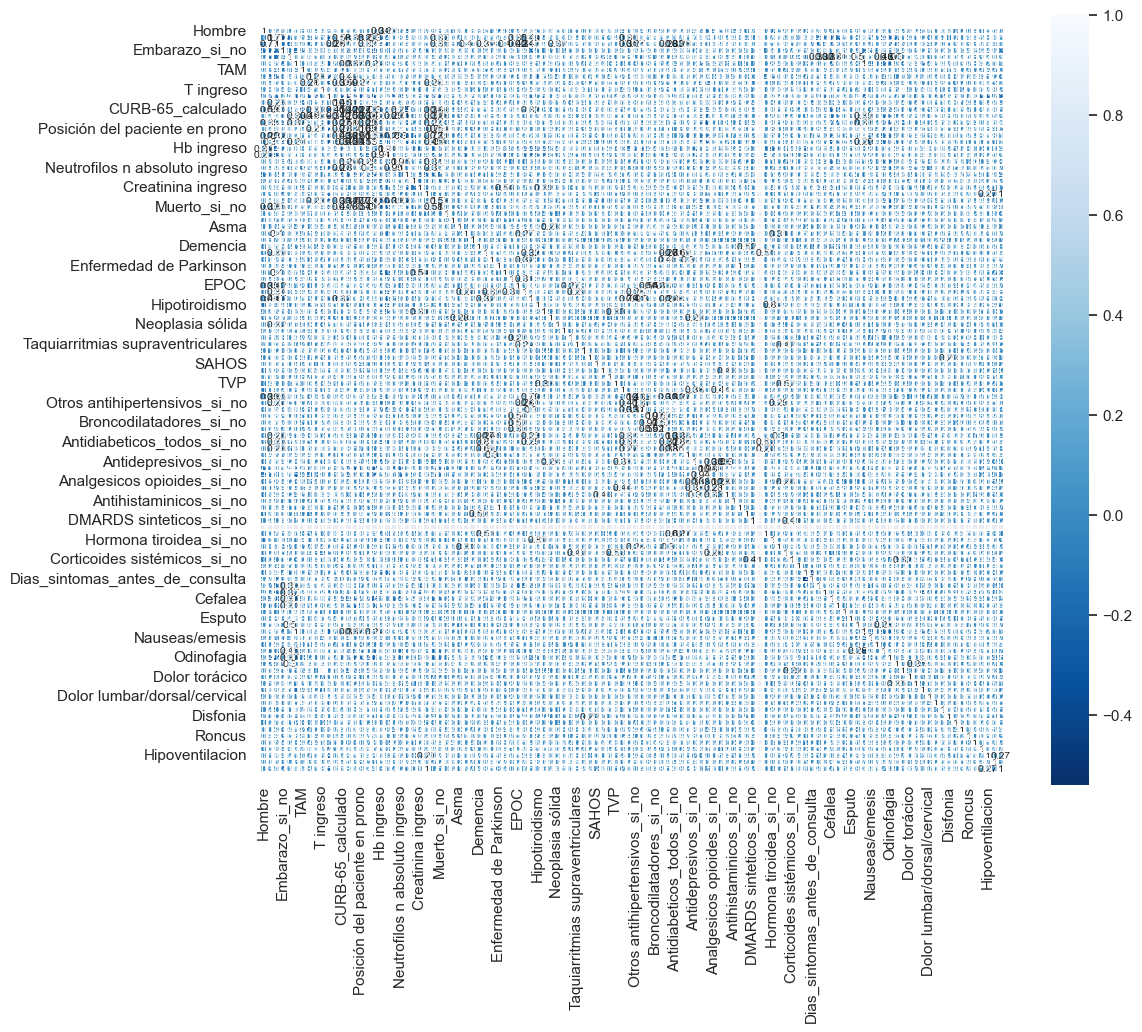

In [397]:
# Verificamos la correlación de la variables.
print('Matriz de correlación')
matriz = pd.DataFrame(base_cont).corr(method='pearson').round(2)

sns.set(rc = {'figure.figsize':(12,10)})
sns.heatmap(matriz, annot=True, annot_kws={'size': 7.5}, square=True, linewidths=0.1, linecolor="white", cmap="Blues_r")

plt.show()

In [398]:
#sns.reset_orig()

**Histogramas de variables numéricas**

In [399]:
Vbles_cuanti = ['Edad (años)', 'Indice de Charlson', 'Sintomas_n', 'TAM', 'FC ingreso', 'FR ingreso',
                'T ingreso', 'Sat02 ingreso', 'CURB-65_calculado', 'Score News2_calculado', 'Hb ingreso', 'Hto ingreso', 
                'Leucocitos ingreso', 'Neutrofilos n absoluto ingreso', 'Linfocitos n absoluto ingreso',
                'Plaquetas ingreso', 'Creatinina ingreso', 'Complicaciones_n']
               

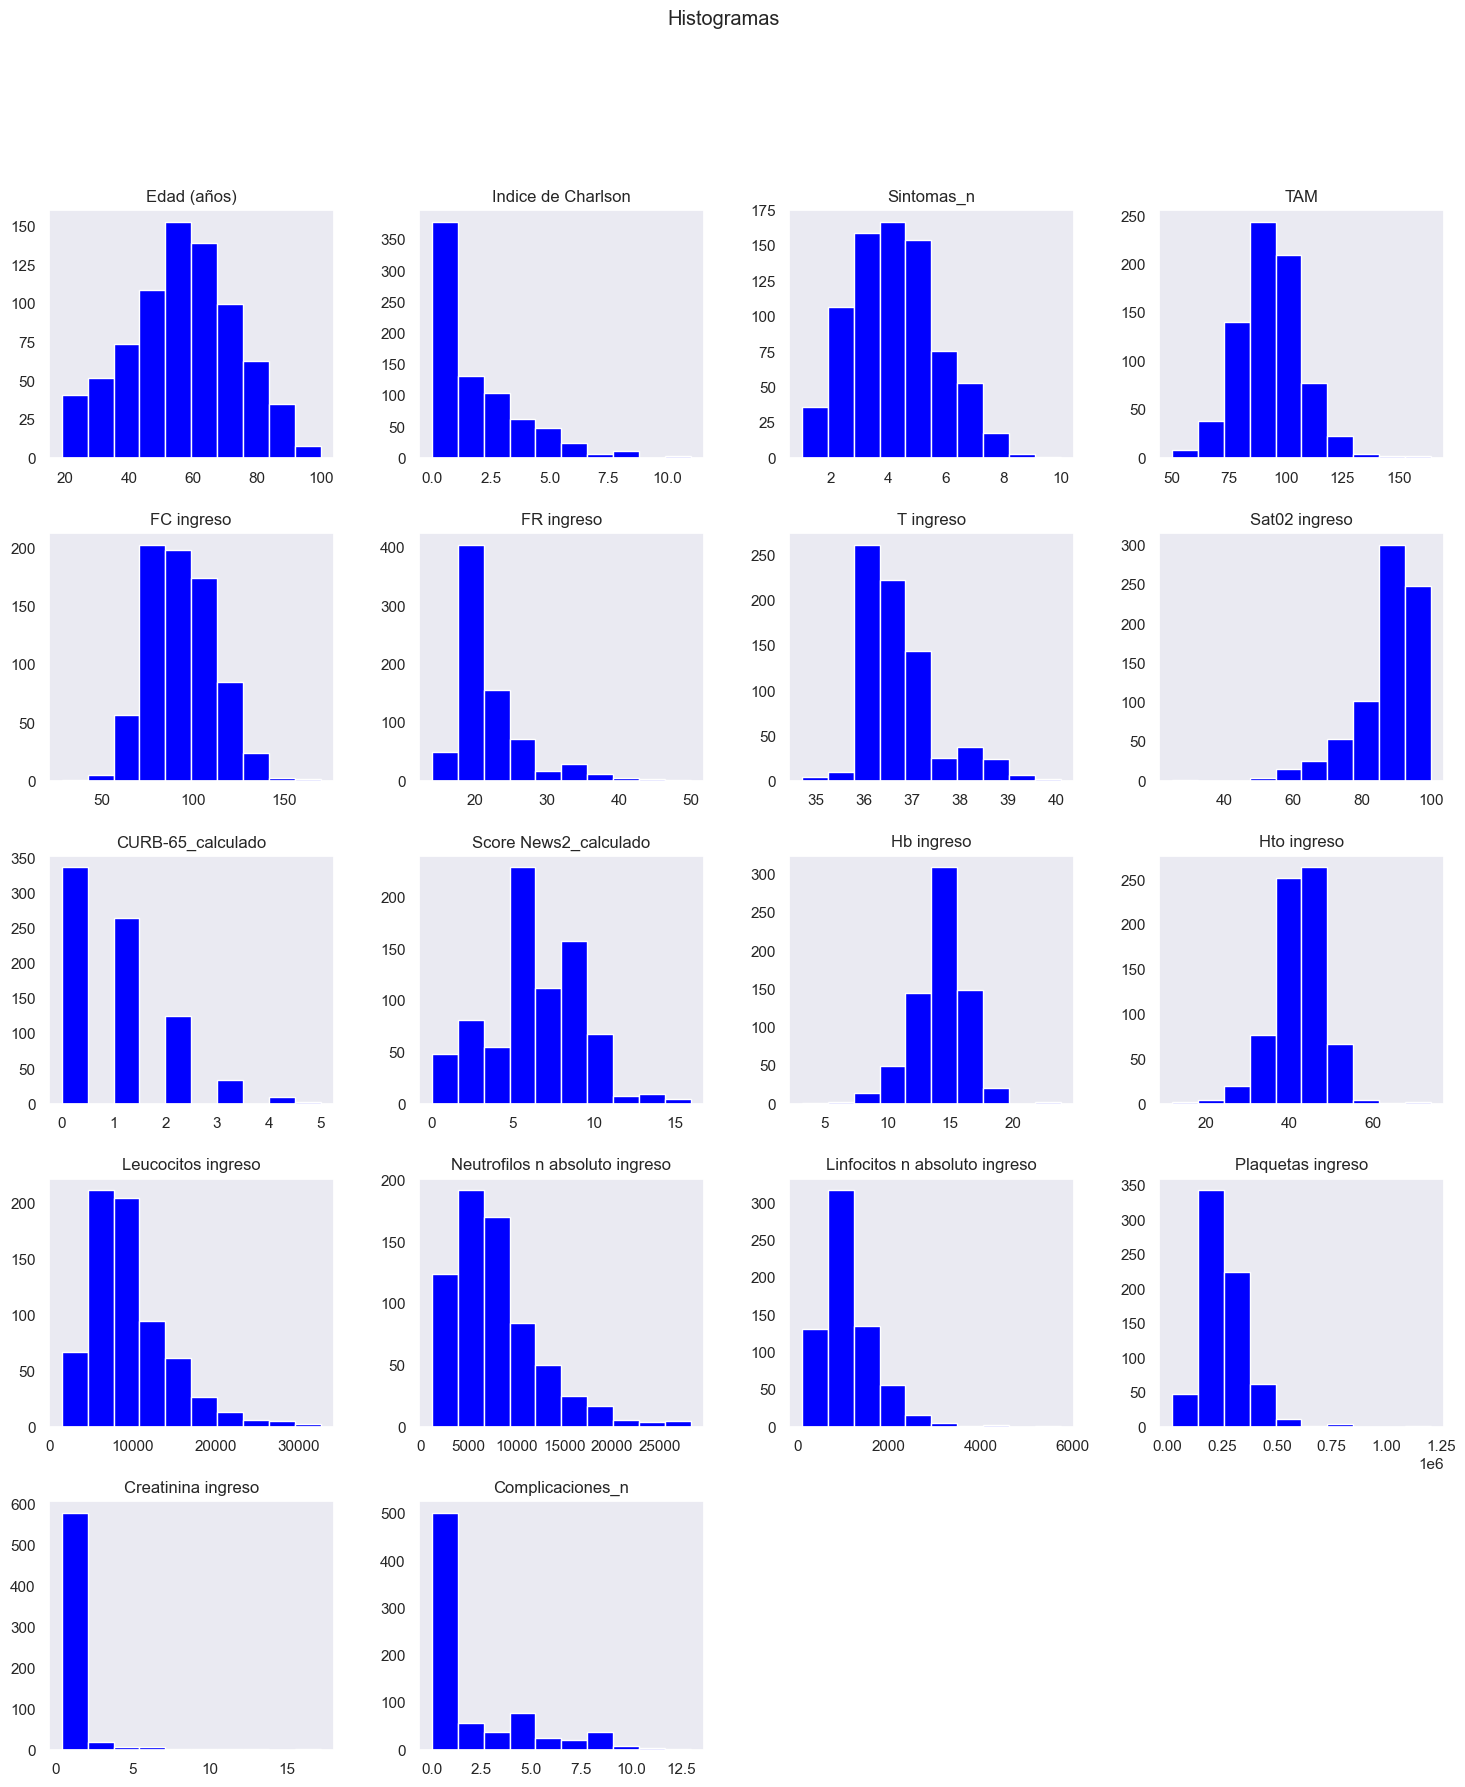

In [400]:
base[Vbles_cuanti].hist(figsize=(18, 20),grid=False, color='blue',rwidth = 1.5)
plt.suptitle('Histogramas')
plt.show()

**Histogramas de variables categóricas**

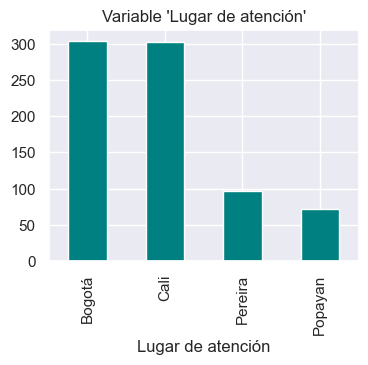

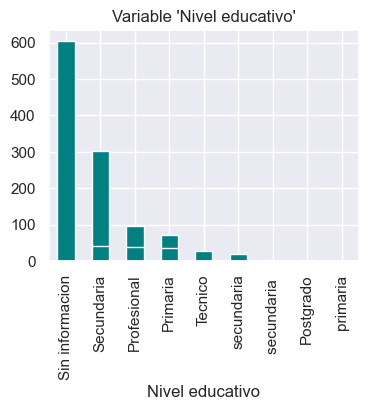

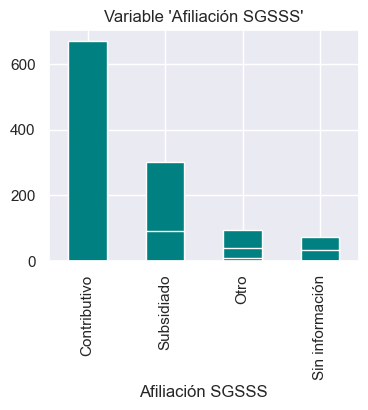

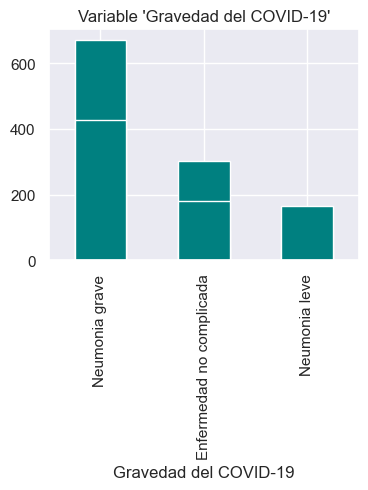

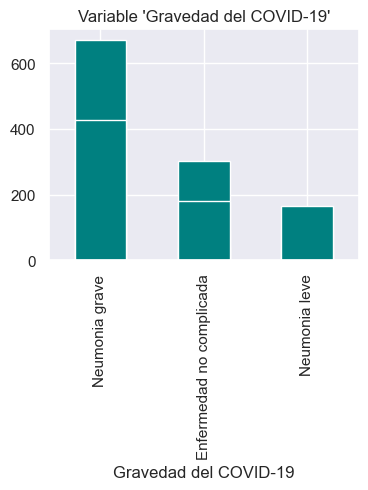

In [401]:
figsize = (4,3)
variables = ['Lugar de atención', 'Nivel educativo', 'Afiliación SGSSS', 'Gravedad del COVID-19' ]
for variable in variables:
    ax = base[variable].value_counts().plot.bar(title=f"Variable '{variable}'", color='teal', figsize=figsize)
    display(ax.figure);

**Conclusiones sobre variables**

- Las variables Hb ingreso, Leucocitos ingreso, Neutrofilos n absoluto ingreso, Linfocitos n absoluto ingreso, Plaquetas ingreso y Creatinina ingreso, tienen más del 10% de datos perdidos
- El índice de Charlson presenta alta correlación con la edad, dado que esta variable se incluye en el cálculo de dicho índice. Algo similar ocurre con el puntaje del CURB-65 (los pacientes de 65 años o más tienen más riesgo de desenlaces adversos por neumonía)
- La variable UCI_si_no e Ingreso a UCI son fundamentalmenta las mismas, se debe eliminar una. 
- La variable de hemoglobina (Hb) al ingreso se correlaciona con Hematocrito (Hto) al ingreso. En términos prácticos miden aspectos muy similares de la química sanguínea, se puede eliminar una.
- La variable Leucocitos ingreso se relaciona con neutrófilos y linfocitos al ingreso. Esto se debe a que los leucocitos son un valor dado por la suma de los diferentes glóbulos blancos, siendo los neutrófilos y los linfocitos los principales en cantidad. Se podría trabajar simplemente con los leucocitos al ingreso
- Disnea.1 es lo mismo que disnea. 'Con_alteraciones_si_no'es lo mismo que Rx. Sse debne eliminar
- Hay pacientes con COVID Nosocomial (lo adquirieron durante la hospitalización). NO aplican para este análisis de clúster, se deben eliminar.
- DMARDS biológicos_si_no: nadie usó estos medicamentos. Se elimina esta variable. 
- En general las variables presentadas son aquellas que se miden al ingreso del paciente a hospitalización, aunque algunas son de desenlace (las complicaciones, muerte, ingreso a UCI y posición prono), por lo cual no deben ser consideradas para los análisis de clúster
- 'Broncodilatadores_corticoides_todos_si_no', 'Antidiabeticos_todos_si_no' hacen referencia a otros grupos de medicamentos en conjunto. Se pueden eliminar..
- La gravedad de la neumonía se va a dejar inicialmente como método de verificación de los clúster.

Además se agruparon las variables en las siguientes categorías:

In [402]:
síntomas = [ 'Ageusia/disgeusia', 'Cefalea', 'Cianosis', 'Conciencia_alterada', 'Congestion conjuntival',
'Congestion nasal/rinorrea', 'Deshidratacion', 'Diarrea', 'Dias_sintomas_antes_de_consulta',
'Disfonia', 'Disnea', 'Dolor abdominal', 'Dolor lumbar/dorsal/cervical', 'Dolor torácico',
'Erupciones cutaneas', 'Esputo',  'Fatiga', 'Fiebre/escalofrios', 
'Hiporexia', 'Hiposmia/anosmia', 'Mialgias/artralgias', 'Nauseas/emesis', 'Odinofagia',
'Sincope', 'Tos']

Antecedentes = ['Accidente cerebrovascular', 'Cardiopatia isquemica', 
'Cirrosis/enfermedad hepática crónica','Demencia','Diabetes mellitus','Dislipidemia',
'EPOC','Enfermedad de Parkinson','Enfermedad renal crónica','Enfermedad valvular',
'Epilepsia','Falla cardiaca','HPB','Hipertensión arterial','Hipotiroidismo',
'Lupus eritematoso sistémico','Neoplasia hematológica','Neoplasia sólida',
'Obesidad','SAHOS','TVP','Tabaquismo','Taquiarritmias supraventriculares',
'Transplantes','Trastornos psiquiatricos','VIH', 'Asma', 'Artritis reumatoide']

Clinimetria = ['CURB-65_calculado', 'Indice de Charlson', 'Score News2_calculado']

Gravedad = ['Gravedad del COVID-19']

Examen_fisico = ['FC ingreso', 'FR ingreso', 'Hipoventilacion', 'Roncus', 'Sat02 ingreso', 'Sibilancias',
'T ingreso', 'TAM', 'Tirajes','Estertores',]

Farmacos = ['Analgesicos no opioides_si_no', 'Analgesicos opioides_si_no', 'Analgesicos_todos_si_no',
'Antiagregantes plaquetarios_si_no', 'Antibióticos_si_no', 'Anticoagulantes_si_no', 'Antidemenciales_si_no',
'Antidepresivos_si_no', 'Antidiabeticos orales_si_no','Antiepilepticos_si_no','Antihistaminicos_si_no',
'Antiparkinsonianos_si_no','Antipsicoticos_si_no','Antiulcerosos_si_no','Broncodilatadores_si_no',
'Corticoides inhalados_si_no','Corticoides sistémicos_si_no','DMARDS biológicos_si_no','DMARDS sinteticos_si_no',
'Diureticos_si_no','Hipolipemiantes_si_no','Hormona tiroidea_si_no','IECA/ARA2_si_no','Insulinas_si_no',
'Otros antihipertensivos_si_no','Oxigeno suplementario']

General = ['Edad (años)', 'Embarazo_si_no', 'Hombre', 'Lugar de atención', 'Nivel educativo', 'Afiliación SGSSS']

Laboratorios = ['Creatinina ingreso', 'Hb ingreso', 'Leucocitos ingreso', 'Plaquetas ingreso', 
                'Rx_ingreso_Con_alteraciones_si_no', 'Hto ingreso', 'Neutrofilos n absoluto ingreso',
                'Linfocitos n absoluto ingreso']

### 3. Preparación de los datos

In [403]:
#eliminamos COVID nosocomial
df = base[base['COVID Nosocomial']==0]
df.shape

(767, 118)

In [404]:
#seleccionamos la base dejando por fuera las variables que no sirven o son redundantes
df = df[df.columns.difference(['Hto ingreso','Neutrofilos n absoluto ingreso',
                                    'Linfocitos n absoluto ingreso','Complicaciones_si_no',
                                    'Complicaciones_n','Posición del paciente en prono',
                                    'DMARDS biológicos_si_no', 'Disnea.1', 'Con_alteraciones_si_no',
                               'Broncodilatadores_corticoides_todos_si_no', 'Antidiabeticos_todos_si_no', 'COVID Nosocomial' ])]
df.head(5)

Accidente cerebrovascular Afiliación SGSSS  Ageusia/disgeusia  \
0                          0     Contributivo                  0   
1                          0     Contributivo                  0   
2                          0     Contributivo                  0   
3                          0     Contributivo                  0   
4                          0     Contributivo                  0   

   Analgesicos no opioides_si_no  Analgesicos opioides_si_no  \
0                              0                           0   
1                              0                           0   
2                              0                           0   
3                              0                           0   
4                              0                           0   

   Analgesicos_todos_si_no  Antiagregantes plaquetarios_si_no  \
0                        0                                  0   
1                        0                                  0   
2                        0                                  0   
3                        0                                  0   
4                        0                                  0   

   Antibióticos_si_no  Anticoagulantes_si_no  Antidemenciales_si_no  ...  \
0                   0                      0                      0  ...   
1                   0                      0                      0  ...   
2                   0                      0                      0  ...   
3                   0                      0                      0  ...   
4                   0                      0                      0  ...   

   T ingreso         TAM  TVP  Tabaquismo  Taquiarritmias supraventriculares  \
0       36.3  108.666667    0           0                                  0   
1       36.5  112.666667    0           0                                  0   
2       38.0  101.000000    0           0                                  0   
3       36.0  113.666667    0           0                                  0   
4       38.5   93.333333    0           0                                  0   

   Tirajes  Tos  Transplantes  Trastornos psiquiatricos  VIH  
0        0    1             0                         0    0  
1        0    1             0                         0    0  
2        0    1             0                         0    0  
3        0    1             0                         0    0  
4        0    1             0                         0    0  

[5 rows x 106 columns]

**Transformación a la variable Nivel Educativo**

In [405]:
df['Nivel educativo'] = df['Nivel educativo'].str.strip()

In [406]:
df['Nivel educativo'] = df['Nivel educativo'].map({'primaria':'Primaria', 'Primaria':'Primaria',
                                                             'secundaria':'Secundaria', 'Secundaria':'Secundaria', 
                                                             'Sin informacion':'Sin informacion', 
                                                             'Profesional':'Profesional',
                                                             'Tecnico':'Tecnico', 
                                                             'Postgrado':'Postgrado',})

In [407]:
df['Nivel educativo'].value_counts()

Nivel educativo
Sin informacion    598
Secundaria          65
Profesional         39
Primaria            36
Tecnico             27
Postgrado            2
Name: count, dtype: int64

In [408]:
#Encoding variables categóricas
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Afiliación SGSSS'] = le.fit_transform(df['Afiliación SGSSS'])
df['Lugar de atención'] = le.fit_transform(df['Lugar de atención'])
df['Nivel educativo'] = le.fit_transform(df['Nivel educativo'])
df['Gravedad del COVID-19'] = le.fit_transform(df['Gravedad del COVID-19'])
df.head()

Accidente cerebrovascular  Afiliación SGSSS  Ageusia/disgeusia  \
0                          0                 0                  0   
1                          0                 0                  0   
2                          0                 0                  0   
3                          0                 0                  0   
4                          0                 0                  0   

   Analgesicos no opioides_si_no  Analgesicos opioides_si_no  \
0                              0                           0   
1                              0                           0   
2                              0                           0   
3                              0                           0   
4                              0                           0   

   Analgesicos_todos_si_no  Antiagregantes plaquetarios_si_no  \
0                        0                                  0   
1                        0                                  0   
2                        0                                  0   
3                        0                                  0   
4                        0                                  0   

   Antibióticos_si_no  Anticoagulantes_si_no  Antidemenciales_si_no  ...  \
0                   0                      0                      0  ...   
1                   0                      0                      0  ...   
2                   0                      0                      0  ...   
3                   0                      0                      0  ...   
4                   0                      0                      0  ...   

   T ingreso         TAM  TVP  Tabaquismo  Taquiarritmias supraventriculares  \
0       36.3  108.666667    0           0                                  0   
1       36.5  112.666667    0           0                                  0   
2       38.0  101.000000    0           0                                  0   
3       36.0  113.666667    0           0                                  0   
4       38.5   93.333333    0           0                                  0   

   Tirajes  Tos  Transplantes  Trastornos psiquiatricos  VIH  
0        0    1             0                         0    0  
1        0    1             0                         0    0  
2        0    1             0                         0    0  
3        0    1             0                         0    0  
4        0    1             0                         0    0  

[5 rows x 106 columns]

In [409]:
df2 = df.copy()

In [410]:
#REALIZAMOS IMPUTACIÓN MÚLTIPLE

# Se crea el kernel. 
kds = mf.ImputationKernel(
  df2,
  save_all_iterations=True,
  random_state=100
)

# Se corre MICE con 5 iteraciones
kds.mice(iterations=5, n_estimators=50)

# Base sin valores perdidos
df_imputed_multiple = kds.complete_data()

In [411]:
#Comprobando nulos
df_imputed_multiple.isnull().sum().sum()

0

In [412]:
df_imputed_multiple.shape

(767, 106)

# Selección inicial de variables por plausibilidad y literatura médica

In [413]:
df_1 = df_imputed_multiple.copy()

In [414]:
# se seleccionan 48 variables iniciales
df_1 = df_1[['Antiagregantes plaquetarios_si_no', 'Anticoagulantes_si_no',
'Artritis reumatoide', 'CURB-65_calculado',
'Cardiopatia isquemica', 'Cianosis', 'Cirrosis/enfermedad hepática crónica',
'Creatinina ingreso', 'Demencia', 'Deshidratacion', 'Diabetes mellitus',
'Dias_sintomas_antes_de_consulta', 'Dolor abdominal', 'EPOC', 'Edad (años)',
'Embarazo_si_no', 'Enfermedad renal crónica', 'Enfermedad valvular',
'Estertores', 'FC ingreso', 'FR ingreso', 'Falla cardiaca', 'Fiebre/escalofrios',
'Hb ingreso', 'Hipertensión arterial', 'Hombre', 'Indice de Charlson', 'Leucocitos ingreso',
'Neoplasia hematológica', 'Neoplasia sólida', 'Obesidad', 'Oxigeno suplementario',
'Plaquetas ingreso', 'Roncus', 'Rx_ingreso_Con_alteraciones_si_no',
'Sat02 ingreso', 'Score News2_calculado', 'Sibilancias', 'T ingreso',
'TAM', 'TVP', 'Tabaquismo', 'Tirajes', 'Transplantes', 'Trastornos psiquiatricos',
'VIH', 'Nivel educativo', 'Afiliación SGSSS']]
print(df_1.shape)
df_1.head()

(767, 48)


Antiagregantes plaquetarios_si_no  Anticoagulantes_si_no  \
0                                  0                      0   
1                                  0                      0   
2                                  0                      0   
3                                  0                      0   
4                                  0                      0   

   Artritis reumatoide  CURB-65_calculado  Cardiopatia isquemica  Cianosis  \
0                    0                  2                      0         0   
1                    0                  3                      0         0   
2                    0                  0                      0         0   
3                    0                  0                      0         0   
4                    0                  0                      0         0   

   Cirrosis/enfermedad hepática crónica  Creatinina ingreso  Demencia  \
0                                     0                1.50         0   
1                                     0                2.09         0   
2                                     0                1.40         0   
3                                     0                0.83         0   
4                                     0                1.03         0   

   Deshidratacion  ...  T ingreso         TAM  TVP  Tabaquismo  Tirajes  \
0               0  ...       36.3  108.666667    0           0        0   
1               0  ...       36.5  112.666667    0           0        0   
2               0  ...       38.0  101.000000    0           0        0   
3               0  ...       36.0  113.666667    0           0        0   
4               0  ...       38.5   93.333333    0           0        0   

   Transplantes  Trastornos psiquiatricos  VIH  Nivel educativo  \
0             0                         0    0                4   
1             0                         0    0                4   
2             0                         0    0                4   
3             0                         0    0                2   
4             0                         0    0                3   

   Afiliación SGSSS  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  

[5 rows x 48 columns]

In [415]:
scaler = StandardScaler()
scaler.fit(df_1)
X =scaler.transform(df_1)
 
pca = PCA(n_components=0.95)
pca.fit_transform(X)
X_pca = pca.fit_transform(X)

In [416]:
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
cumulativo = len(cumulative_var_ratio)
cumulativo

41

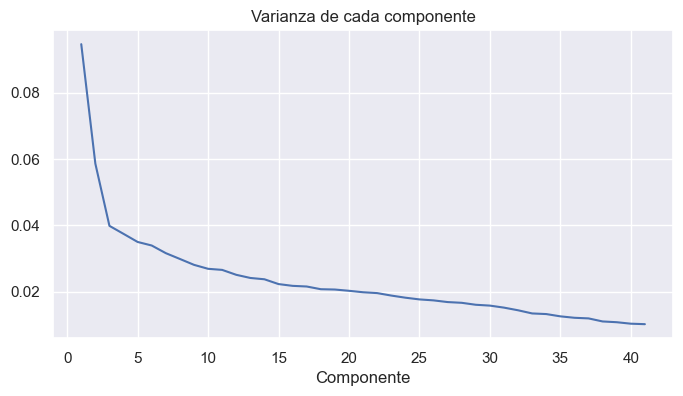

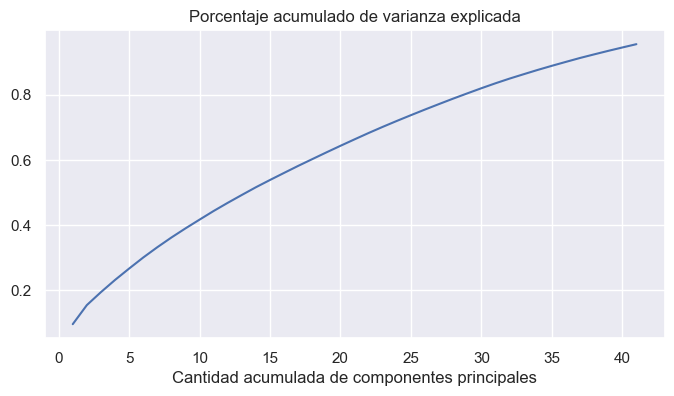

In [417]:
varianzaExplicada=pca.explained_variance_
porcentajeVarianzaExplicada=pca.explained_variance_ratio_
plt.figure(figsize=(8,4))
plt.plot(range(1,cumulativo+1),porcentajeVarianzaExplicada)
plt.xlabel('Componente')
plt.title('Varianza de cada componente')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(range(1,cumulativo+1),np.cumsum(porcentajeVarianzaExplicada)) #acumulado
plt.xlabel('Cantidad acumulada de componentes principales')
plt.title('Porcentaje acumulado de varianza explicada')
plt.show()

In [418]:
from pca import pca
#se seleccionan 30 componentes, correspondientes al 80% aprox de varianza explicada
model = pca(n_components=30)
X_PCA = model.fit_transform(X)

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [48] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[30]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


In [419]:
loadings = X_PCA['loadings']
loadings.columns = df_1.columns
loadings

Antiagregantes plaquetarios_si_no  Anticoagulantes_si_no  \
PC1                            0.081568               0.061957   
PC2                            0.117079               0.071308   
PC3                            0.026800              -0.105370   
PC4                            0.119341               0.501941   
PC5                            0.059677               0.195553   
PC6                            0.082955              -0.064194   
PC7                           -0.264504               0.260409   
PC8                            0.223992              -0.114031   
PC9                           -0.343570              -0.086981   
PC10                          -0.125287              -0.101205   
PC11                          -0.188781              -0.058496   
PC12                           0.182895               0.036763   
PC13                          -0.002043              -0.014583   
PC14                           0.017946               0.051170   
PC15                          -0.056746               0.006054   
PC16                          -0.032242              -0.088660   
PC17                          -0.118034               0.105636   
PC18                           0.112010              -0.015923   
PC19                          -0.085720               0.089628   
PC20                           0.157084              -0.031179   
PC21                          -0.056621              -0.000547   
PC22                           0.091898               0.011333   
PC23                           0.062896               0.083555   
PC24                           0.216777              -0.036973   
PC25                           0.058368              -0.003565   
PC26                          -0.104429               0.070617   
PC27                          -0.097839               0.079993   
PC28                          -0.284402              -0.051094   
PC29                          -0.257633               0.106916   
PC30                           0.264299               0.139454   

      Artritis reumatoide  CURB-65_calculado  Cardiopatia isquemica  Cianosis  \
PC1              0.015264           0.341672               0.197590  0.052187   
PC2              0.030342           0.001573               0.125973 -0.063219   
PC3             -0.051221          -0.136690              -0.000417  0.038459   
PC4             -0.103776          -0.101229               0.224214  0.051009   
PC5             -0.063310          -0.154200              -0.037709 -0.134685   
PC6             -0.134989           0.036852               0.131708 -0.043553   
PC7              0.059525           0.150640              -0.091798  0.012534   
PC8             -0.123718           0.016226               0.168363  0.286130   
PC9             -0.058527          -0.016657              -0.092367  0.356158   
PC10            -0.055892           0.105109               0.192200  0.042954   
PC11             0.024636           0.029182              -0.061346 -0.261710   
PC12             0.020785           0.097987               0.260750  0.116181   
PC13             0.078059          -0.122143               0.097125  0.092778   
PC14            -0.235376          -0.018597              -0.111173  0.003163   
PC15             0.315176           0.047446              -0.004941 -0.011123   
PC16            -0.364900           0.074513              -0.116474 -0.009940   
PC17            -0.103581          -0.062816              -0.014828  0.290915   
PC18            -0.261893           0.026130               0.011593  0.036056   
PC19             0.175976          -0.068503              -0.035372  0.106625   
PC20             0.568829          -0.037671              -0.021970  0.104672   
PC21             0.051283          -0.029553               0.130629 -0.208464   
PC22             0.091201           0.092291               0.079701  0.046721   
PC23            -0.115404          -0.043976               0.040242  0.018815   
PC24           

In [420]:
feature_index_to_name = {i+1: column_name for i, column_name in enumerate(df_1.columns)}
top_features = X_PCA['topfeat']
top_features['feature'] = top_features['feature'].astype(int)
top_features['feature'] = top_features['feature'].map(feature_index_to_name)
top_features

PC                               feature   loading  type
0    PC1                    Indice de Charlson  0.382590  best
1    PC2                 Score News2_calculado -0.384371  best
2    PC3                            Hb ingreso  0.382148  best
3    PC4                 Anticoagulantes_si_no  0.501941  best
4    PC5                    Creatinina ingreso  0.366370  best
5    PC6                       Nivel educativo -0.381764  best
6    PC7                      Neoplasia sólida  0.329678  best
7    PC8                                   VIH  0.376250  best
8    PC9                               Tirajes  0.382570  best
9   PC10     Rx_ingreso_Con_alteraciones_si_no -0.398877  best
10  PC11                             T ingreso  0.379880  best
11  PC12                                Roncus  0.396321  best
12  PC13                              Demencia -0.390056  best
13  PC14                       Dolor abdominal -0.332887  best
14  PC15                              Demencia -0.355073  best
15  PC16              Trastornos psiquiatricos  0.399149  best
16  PC17                Neoplasia hematológica  0.415507  best
17  PC18       Dias_sintomas_antes_de_consulta  0.492534  best
18  PC19                       Dolor abdominal  0.646577  best
19  PC20                   Artritis reumatoide  0.568829  best
20  PC21                Neoplasia hematológica  0.627635  best
21  PC22                          Transplantes  0.424432  best
22  PC23       Dias_sintomas_antes_de_consulta  0.339970  best
23  PC24                              Cianosis -0.427447  best
24  PC25                        Deshidratacion -0.394275  best
25  PC26                          Transplantes  0.365091  best
26  PC27                 Cardiopatia isquemica -0.345280  best
27  PC28                              Demencia  0.459614  best
28  PC29                      Afiliación SGSSS -0.317496  best
29  PC30              Trastornos psiquiatricos  0.437001  best
30   PC9     Antiagregantes plaquetarios_si_no -0.343570  weak
31   PC1                     CURB-65_calculado  0.341672  weak
32  PC24  Cirrosis/enfermedad hepática crónica  0.320042  weak
33  PC29                     Diabetes mellitus -0.311346  weak
34   PC3                                  EPOC  0.231898  weak
35   PC1                           Edad (años)  0.339230  weak
36  PC27                        Embarazo_si_no  0.343630  weak
37   PC5              Enfermedad renal crónica  0.335542  weak
38  PC11                   Enfermedad valvular  0.359631  weak
39   PC6                            Estertores -0.303939  weak
40   PC2                            FC ingreso -0.354612  weak
41   PC2                            FR ingreso -0.316555  weak
42   PC4                        Falla cardiaca  0.310116  weak
43  PC11                    Fiebre/escalofrios  0.339384  weak
44  PC29                 Hipertensión arterial  0.263204  weak
45  PC10                                Hombre  0.222779  weak
46  PC12                    Leucocitos ingreso  0.249438  weak
47  PC17                              Obesidad -0.330969  weak
48  PC23                 Oxigeno suplementario  0.326109  weak
49   PC7                     Plaquetas ingreso -0.271483  weak
50   PC2                         Sat02 ingreso  0.264351  weak
51  PC25                           Sibilancias  0.353972  weak
52   PC7                                   TAM -0.302850  weak
53   PC4                                   TVP  0.387196  weak
54  PC10                            Tabaquismo  0.313076  weak

# DBSCAN

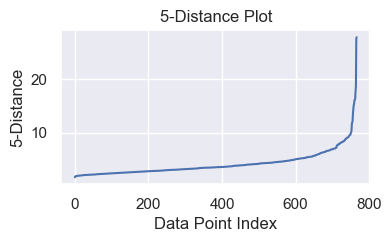

In [421]:
k = 5
X_pca_9 = X_pca[:,:30] #se seleccionan 30 componentes principales
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X_pca_9)

distances, _ = knn.kneighbors(X_pca_9)

sorted_distances = np.sort(distances[:, -1])
plt.figure(figsize=(4,2))
plt.plot(range(len(sorted_distances)), sorted_distances)
plt.xlabel('Data Point Index')
plt.ylabel(f'{k}-Distance')
plt.title(f'{k}-Distance Plot')
plt.grid(True)
plt.show()

In [422]:
i = np.arange(len(distances))
distances = distances[:, -1] 
knee = KneeLocator(i, distances, 
                   S=1, curve='convex', 
                   direction='increasing', 
                   interp_method='polynomial')
epsilon= distances[knee.knee]
print(epsilon)

3.526586022091932


In [423]:
from sklearn.metrics import silhouette_score
min_samples = range(3,25)
output = []
for ms in min_samples:
        labels = DBSCAN(min_samples=ms, eps = epsilon).fit(X_pca_9).labels_
        score = silhouette_score(X_pca_9, labels)
        output.append((ms, epsilon, score))

min_samples, epsilon, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Mejor silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {epsilon}")

Mejor silhouette_score: 0.13912080283063136
min_samples: 8
eps: 3.526586022091932


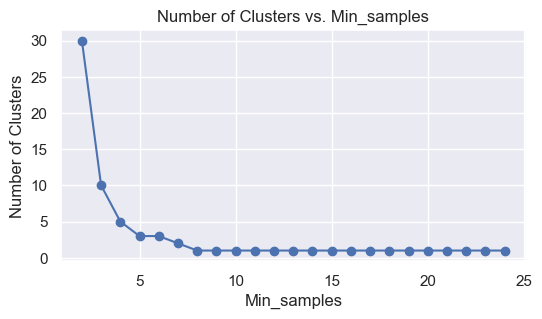

In [424]:
min_samples_values = range(2, 25) 
cluster_counts = []

for min_sample in min_samples_values:
    dbscan = DBSCAN(eps=epsilon, min_samples=min_sample)
    dbscan.fit(X_pca_9)
    unique_labels = np.unique(dbscan.labels_)
    num_clusters = len(unique_labels) - 1 if -1 in unique_labels else len(unique_labels)
    
    cluster_counts.append(num_clusters)

plt.figure(figsize=(6, 3))
plt.plot(min_samples_values, cluster_counts, marker='o', linestyle='-')
plt.title('Number of Clusters vs. Min_samples')
plt.xlabel('Min_samples')
plt.ylabel('Number of Clusters')

plt.show()


In [425]:
eps = epsilon  
min_samples = 7

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters_db = dbscan.fit_predict(X_pca_9)

In [426]:
df_dbscan = df_1.copy()
df_dbscan['Cluster'] = clusters_db
#df_dbscan['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
print(df_dbscan['Cluster'].unique())
df_dbscan
#df_dbscan.to_excel("DBSCAN_3cluster.xlsx", index=False)

[ 0 -1  1]


Antiagregantes plaquetarios_si_no  Anticoagulantes_si_no  \
0                                    0                      0   
1                                    0                      0   
2                                    0                      0   
3                                    0                      0   
4                                    0                      0   
..                                 ...                    ...   
769                                  0                      0   
770                                  0                      0   
771                                  0                      0   
772                                  0                      0   
773                                  0                      0   

     Artritis reumatoide  CURB-65_calculado  Cardiopatia isquemica  Cianosis  \
0                      0                  2                      0         0   
1                      0                  3                      0         0   
2                      0                  0                      0         0   
3                      0                  0                      0         0   
4                      0                  0                      0         0   
..                   ...                ...                    ...       ...   
769                    0                  1                      0         0   
770                    0                  0                      0         0   
771                    0                  0                      0         0   
772                    0                  1                      0         0   
773                    0                  1                      0         0   

     Cirrosis/enfermedad hepática crónica  Creatinina ingreso  Demencia  \
0                                       0                1.50         0   
1                                       0                2.09         0   
2                                       0                1.40         0   
3                                       0                0.83         0   
4                                       0                1.03         0   
..                                    ...                 ...       ...   
769                                     0                0.92         0   
770                                     0                0.85         0   
771                                     0                0.67         0   
772                                     0                1.03         0   
773                                     0                0.83         0   

     Deshidratacion  ...         TAM  TVP  Tabaquismo  Tirajes  Transplantes  \
0                 0  ...  108.666667    0           0        0             0   
1                 0  ...  112.666667    0           0        0             0   
2                 0  ...  101.000000    0           0        0             0   
3                 0  ...  113.666667    0           0        0             0   
4                 0  ...   93.333333    0           0        0             0   
..              ...  ...         ...  ...         ...      ...           ...   
769               0  ...  109.666667    0           0        0             0   
770               0  ...   94.666667    0           0        0             0   
771               0  ...   93.333333    0           0        0             0   
772               0  ...  105.333333    0           0        0             0   
773               0  ...   94.666667    0           0        0             0   

     Trastornos psiquiatricos  VIH  Nivel educativo  Afiliación SGSSS  Cluster  
0                           0    0                4                 0        0  
1                           0    0                4                 0       -1  
2                           0    0                4                 0        0  
3                           0    0                2                 0        

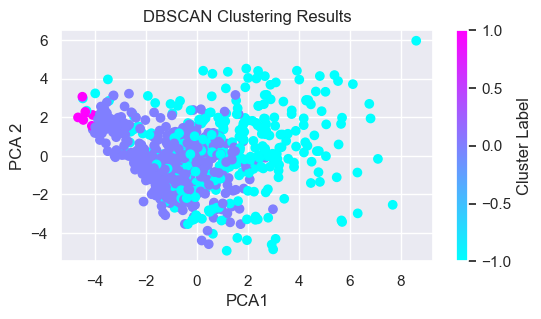

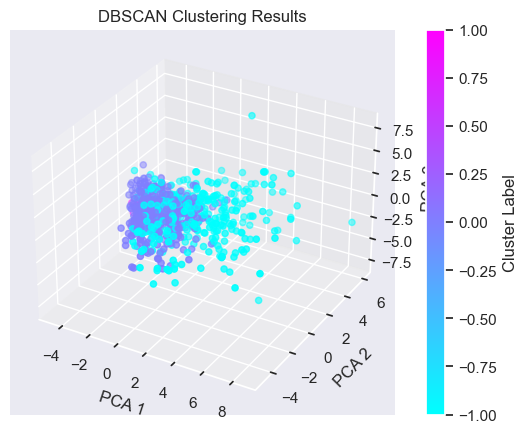

In [427]:
plt.figure(figsize=(6, 3))
plt.scatter(X_pca_9[:, 0], X_pca_9[:, 1], c=clusters_db, cmap='cool')  
plt.title('DBSCAN Clustering Results')
plt.xlabel('PCA1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_9[:, 0], X_pca_9[:, 1], X_pca_9[:, 2], c=clusters_db, cmap='cool')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('DBSCAN Clustering Results')

legend = plt.colorbar(scatter, ax=ax)
legend.set_label('Cluster Label')

plt.show();

In [428]:
df_dbscan.groupby('Cluster').agg(['mean']).T

Cluster                                               -1              0  \
Antiagregantes plaquetarios_si_no    mean       0.100313       0.000000   
Anticoagulantes_si_no                mean       0.031348       0.000000   
Artritis reumatoide                  mean       0.034483       0.000000   
CURB-65_calculado                    mean       1.266458       0.589569   
Cardiopatia isquemica                mean       0.072100       0.000000   
Cianosis                             mean       0.021944       0.000000   
Cirrosis/enfermedad hepática crónica mean       0.003135       0.000000   
Creatinina ingreso                   mean       1.616646       0.912177   
Demencia                             mean       0.031348       0.000000   
Deshidratacion                       mean       0.097179       0.000000   
Diabetes mellitus                    mean       0.316614       0.126984   
Dias_sintomas_antes_de_consulta      mean       5.739812       5.950113   
Dolor abdominal                      mean       0.122257       0.000000   
EPOC                                 mean       0.206897       0.018141   
Edad (años)                          mean      63.065831      52.764172   
Embarazo_si_no                       mean       0.021944       0.000000   
Enfermedad renal crónica             mean       0.156740       0.009070   
Enfermedad valvular                  mean       0.021944       0.000000   
Estertores                           mean       0.275862       0.147392   
FC ingreso                           mean      94.228840      93.365079   
FR ingreso                           mean      22.517241      21.061224   
Falla cardiaca                       mean       0.103448       0.000000   
Fiebre/escalofrios                   mean       0.633229       0.773243   
Hb ingreso                           mean      13.835266      14.465125   
Hipertensión arterial                mean       0.570533       0.251701   
Hombre                               mean       0.608150       0.634921   
Indice de Charlson                   mean       3.087774       1.260771   
Leucocitos ingreso                   mean   10067.815047    9213.646259   
Neoplasia hematológica               mean       0.003135       0.000000   
Neoplasia sólida                     mean       0.056426       0.000000   
Obesidad                             mean       0.181818       0.163265   
Oxigeno suplementario                mean       0.915361       0.848073   
Plaquetas ingreso                    mean  265685.266458  262236.281179   
Roncus                               mean       0.191223       0.063492   
Rx_ingreso_Con_alteraciones_si_no    mean       0.570533       0.464853   
Sat02 ingreso                        mean      85.639498      88.704082   
Score News2_calculado                mean       6.974922       5.814059   
Sibilancias                          mean       0.072100       0.000000   
T ingreso                            mean      36.651411      36.725850   
TAM                                  mean      93.711599      92.606954   
TVP                                  mean       0.009404       0.000000   
Tabaquismo                           mean       0.119122       0.034014   
Tirajes                              mean       0.169279       0.006803   
Transplantes                         mean       0.009404       0.000000   
Trastornos psiquiatricos             mean       0.028213       0.000000   
VIH                                  mean       0.009404       0.000000   
Nivel educativo                      mean       3.645768       3.732426   
Afiliación SGSSS                     mean       0.532915       0.263039   

Cluster                                                1  
Antiagregantes plaquetarios_si_no    mean       0.000000  
Anticoagulantes_si_no                mean       0.000000  
Artritis reumatoide                  mean       0.000000  
CURB-65_calculado                    mean       0.000000  
Cardiopatia isquemica        

In [429]:
df_dbscan['UCI'] = df_imputed_multiple['Ingreso a UCI']
df_dbscan['Muerte'] = df_imputed_multiple['Muerto_si_no']
df_dbscan.groupby('Cluster' ).agg(['mean']).T

Cluster                                               -1              0  \
Antiagregantes plaquetarios_si_no    mean       0.100313       0.000000   
Anticoagulantes_si_no                mean       0.031348       0.000000   
Artritis reumatoide                  mean       0.034483       0.000000   
CURB-65_calculado                    mean       1.266458       0.589569   
Cardiopatia isquemica                mean       0.072100       0.000000   
Cianosis                             mean       0.021944       0.000000   
Cirrosis/enfermedad hepática crónica mean       0.003135       0.000000   
Creatinina ingreso                   mean       1.616646       0.912177   
Demencia                             mean       0.031348       0.000000   
Deshidratacion                       mean       0.097179       0.000000   
Diabetes mellitus                    mean       0.316614       0.126984   
Dias_sintomas_antes_de_consulta      mean       5.739812       5.950113   
Dolor abdominal                      mean       0.122257       0.000000   
EPOC                                 mean       0.206897       0.018141   
Edad (años)                          mean      63.065831      52.764172   
Embarazo_si_no                       mean       0.021944       0.000000   
Enfermedad renal crónica             mean       0.156740       0.009070   
Enfermedad valvular                  mean       0.021944       0.000000   
Estertores                           mean       0.275862       0.147392   
FC ingreso                           mean      94.228840      93.365079   
FR ingreso                           mean      22.517241      21.061224   
Falla cardiaca                       mean       0.103448       0.000000   
Fiebre/escalofrios                   mean       0.633229       0.773243   
Hb ingreso                           mean      13.835266      14.465125   
Hipertensión arterial                mean       0.570533       0.251701   
Hombre                               mean       0.608150       0.634921   
Indice de Charlson                   mean       3.087774       1.260771   
Leucocitos ingreso                   mean   10067.815047    9213.646259   
Neoplasia hematológica               mean       0.003135       0.000000   
Neoplasia sólida                     mean       0.056426       0.000000   
Obesidad                             mean       0.181818       0.163265   
Oxigeno suplementario                mean       0.915361       0.848073   
Plaquetas ingreso                    mean  265685.266458  262236.281179   
Roncus                               mean       0.191223       0.063492   
Rx_ingreso_Con_alteraciones_si_no    mean       0.570533       0.464853   
Sat02 ingreso                        mean      85.639498      88.704082   
Score News2_calculado                mean       6.974922       5.814059   
Sibilancias                          mean       0.072100       0.000000   
T ingreso                            mean      36.651411      36.725850   
TAM                                  mean      93.711599      92.606954   
TVP                                  mean       0.009404       0.000000   
Tabaquismo                           mean       0.119122       0.034014   
Tirajes                              mean       0.169279       0.006803   
Transplantes                         mean       0.009404       0.000000   
Trastornos psiquiatricos             mean       0.028213       0.000000   
VIH                                  mean       0.009404       0.000000   
Nivel educativo                      mean       3.645768       3.732426   
Afiliación SGSSS                     mean       0.532915       0.263039   
UCI                                  mean       0.379310       0.285714   
Muerte                               mean       0.341693       0.199546   

Cluster                                                1  
Antiagregantes plaquetarios_si_no    mean       0.000000  
Anticoagulantes_si_no                mean       0.000000

In [430]:
df_dbscan['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
df_dbscan.groupby('Gravedad' ).agg(['mean']).T

Gravedad                                   Enfermedad no complicada  \
Antiagregantes plaquetarios_si_no    mean                  0.027624   
Anticoagulantes_si_no                mean                  0.005525   
Artritis reumatoide                  mean                  0.011050   
CURB-65_calculado                    mean                  0.375691   
Cardiopatia isquemica                mean                  0.005525   
Cianosis                             mean                  0.000000   
Cirrosis/enfermedad hepática crónica mean                  0.000000   
Creatinina ingreso                   mean                  1.017624   
Demencia                             mean                  0.005525   
Deshidratacion                       mean                  0.011050   
Diabetes mellitus                    mean                  0.110497   
Dias_sintomas_antes_de_consulta      mean                  5.071823   
Dolor abdominal                      mean                  0.093923   
EPOC                                 mean                  0.033149   
Edad (años)                          mean                 47.453039   
Embarazo_si_no                       mean                  0.071823   
Enfermedad renal crónica             mean                  0.038674   
Enfermedad valvular                  mean                  0.000000   
Estertores                           mean                  0.049724   
FC ingreso                           mean                 88.745856   
FR ingreso                           mean                 19.646409   
Falla cardiaca                       mean                  0.027624   
Fiebre/escalofrios                   mean                  0.662983   
Hb ingreso                           mean                 14.133315   
Hipertensión arterial                mean                  0.281768   
Hombre                               mean                  0.574586   
Indice de Charlson                   mean                  1.116022   
Leucocitos ingreso                   mean               7942.756906   
Neoplasia hematológica               mean                  0.000000   
Neoplasia sólida                     mean                  0.016575   
Obesidad                             mean                  0.160221   
Oxigeno suplementario                mean                  0.480663   
Plaquetas ingreso                    mean             279723.756906   
Roncus                               mean                  0.033149   
Rx_ingreso_Con_alteraciones_si_no    mean                  0.270718   
Sat02 ingreso                        mean                 94.182320   
Score News2_calculado                mean                  3.662983   
Sibilancias                          mean                  0.033149   
T ingreso                            mean                 36.718785   
TAM                                  mean                 91.263352   
TVP                                  mean                  0.000000   
Tabaquismo                           mean                  0.044199   
Tirajes                              mean                  0.027624   
Transplantes                         mean                  0.000000   
Trastornos psiquiatricos             mean                  0.011050   
VIH                                  mean                  0.000000   
Nivel educativo                      mean                  3.596685   
Afiliación SGSSS                     mean                  0.475138   
Cluster                              mean                 -0.281768   
UCI                                  mean                  0.016575   
Muerte                               mean                  0.011050   

Gravedad                                   Neumonia grave  Neumonia leve  
Antiagregantes plaquetarios_si_no    mean        0.045238       0.048193  
Anticoagulantes_si_no                mean        0.019048       0.006024  
Artritis reumatoide                  mean        0.019048       0.006024  
CURB-65

In [431]:

#los números de recodificación deben coincidir con las características de los clúster. Esto se hace verificando las métricas de cada clúster
df_dbscan['y_true'] = df_dbscan['Gravedad'].map({'Neumonia grave':-1, 
                                                 'Enfermedad no complicada': 1,
                                                 'Neumonia leve':0})
df_dbscan.head()

#df_kmeans_clusters.to_excel("kmeans_matrix.xlsx", index=False)

Antiagregantes plaquetarios_si_no  Anticoagulantes_si_no  \
0                                  0                      0   
1                                  0                      0   
2                                  0                      0   
3                                  0                      0   
4                                  0                      0   

   Artritis reumatoide  CURB-65_calculado  Cardiopatia isquemica  Cianosis  \
0                    0                  2                      0         0   
1                    0                  3                      0         0   
2                    0                  0                      0         0   
3                    0                  0                      0         0   
4                    0                  0                      0         0   

   Cirrosis/enfermedad hepática crónica  Creatinina ingreso  Demencia  \
0                                     0                1.50         0   
1                                     0                2.09         0   
2                                     0                1.40         0   
3                                     0                0.83         0   
4                                     0                1.03         0   

   Deshidratacion  ...  Transplantes  Trastornos psiquiatricos  VIH  \
0               0  ...             0                         0    0   
1               0  ...             0                         0    0   
2               0  ...             0                         0    0   
3               0  ...             0                         0    0   
4               0  ...             0                         0    0   

   Nivel educativo  Afiliación SGSSS  Cluster  UCI  Muerte  \
0                4                 0        0    1       0   
1                4                 0       -1    1       1   
2                4                 0        0    0       0   
3                2                 0        0    0       0   
4                3                 0        0    0       0   

                   Gravedad  y_true  
0            Neumonia grave      -1  
1            Neumonia grave      -1  
2  Enfermedad no complicada       1  
3  Enfermedad no complicada       1  
4             Neumonia leve       0  

[5 rows x 53 columns]

In [432]:
from sklearn.metrics import adjusted_rand_score
y_true = df_dbscan['y_true']
y_pred = df_dbscan['Cluster']

ari_score = adjusted_rand_score(y_true, y_pred)

print(f"ARI Score: {ari_score}")

ARI Score: 0.006779658285073041


In [433]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [434]:
from scipy.optimize import linear_sum_assignment as linear_assignment
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(w.max() - w)
accu = sum([w[i, j] for i, j in zip(ind[0],ind[1])]) * 1.0 / y_pred.size
print("El accuracy es:", accu)

El accuracy es: 0.5019556714471969


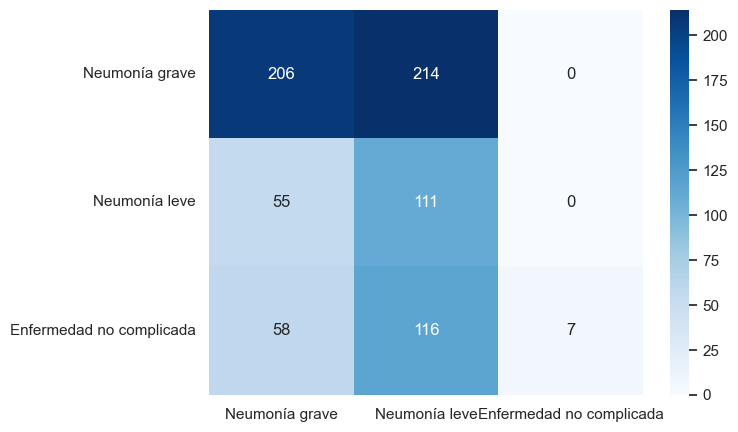

In [435]:
from sklearn.metrics import confusion_matrix

#los labels se deben colocar en el orden de los cluster (número). Acá en DBSCAN por ejemplo el primero es -1
cm_labels = ['Neumonía grave', 'Neumonía leve', 'Enfermedad no complicada' ]

cm = confusion_matrix(df_dbscan['y_true'], df_dbscan['Cluster'])

cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.heatmap(cm_array_df,  annot=True, fmt='g', cmap='Blues' )
plt.show() 

In [436]:
pivot = pd.pivot_table(df_dbscan, index=['Cluster'], columns='Muerte', aggfunc='size')
pivot2 = pd.pivot_table(df_dbscan, index=['Gravedad'], columns='Muerte', aggfunc='size')
concat = pd.concat([pivot, pivot2])
concat['%muerte'] = 100*(concat[1]/(concat[1]+concat[0]))
concat

Muerte                        0      1    %muerte
-1                        210.0  109.0  34.169279
0                         353.0   88.0  19.954649
1                           7.0    NaN        NaN
Enfermedad no complicada  179.0    2.0   1.104972
Neumonia grave            251.0  169.0  40.238095
Neumonia leve             140.0   26.0  15.662651

## Hierachical clustering

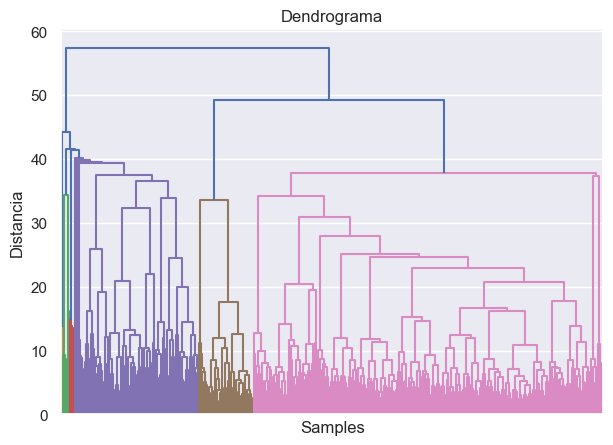

In [437]:
linkage_matrix = sch.linkage(X_pca_9, method='ward')
dendrogram = sch.dendrogram(linkage_matrix, truncate_mode = 'level', 
           show_leaf_counts = False, 
           no_labels = True)

plt.title('Dendrograma')
plt.xlabel('Samples')
plt.ylabel('Distancia')
plt.show();


In [438]:
num_clusters = 3
cluster_hierarchical= fcluster(linkage_matrix, num_clusters, criterion='maxclust')

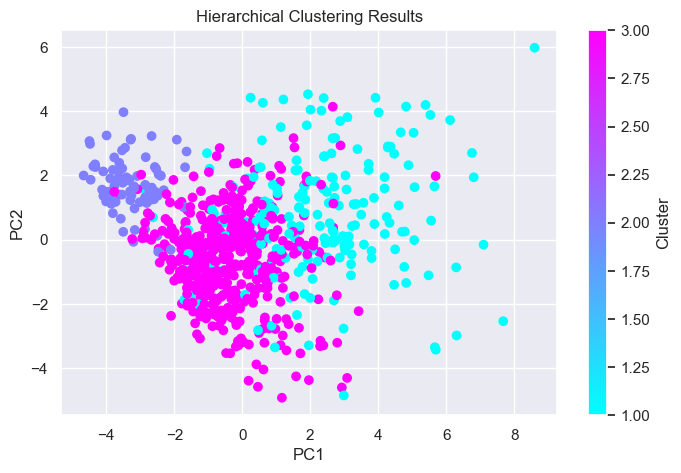

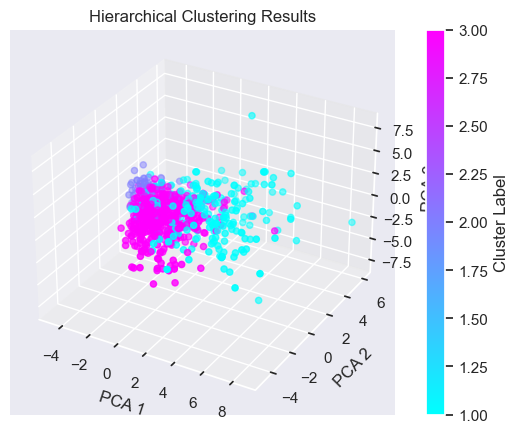

In [439]:
fig = plt.figure(figsize=(8,5))
plt.scatter(X_pca_9[:, 0], X_pca_9[:, 1], c=cluster_hierarchical, cmap='cool')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Hierarchical Clustering Results')
plt.colorbar(label='Cluster')
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_9[:, 0], X_pca_9[:, 1], X_pca_9[:, 2], c=cluster_hierarchical, cmap='cool')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('Hierarchical Clustering Results')

legend = plt.colorbar(scatter, ax=ax)
legend.set_label('Cluster Label')

plt.show()

In [440]:
df_hierarchical_clusters = df_1.copy()
df_hierarchical_clusters['Cluster'] = cluster_hierarchical
#df_hierarchical_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
print(df_hierarchical_clusters['Cluster'].unique())
df_hierarchical_clusters
#df_hierarchical_clusters.to_excel("hierarchichal_4_cluster.xlsx", index=False)

[3 2 1]


Antiagregantes plaquetarios_si_no  Anticoagulantes_si_no  \
0                                    0                      0   
1                                    0                      0   
2                                    0                      0   
3                                    0                      0   
4                                    0                      0   
..                                 ...                    ...   
769                                  0                      0   
770                                  0                      0   
771                                  0                      0   
772                                  0                      0   
773                                  0                      0   

     Artritis reumatoide  CURB-65_calculado  Cardiopatia isquemica  Cianosis  \
0                      0                  2                      0         0   
1                      0                  3                      0         0   
2                      0                  0                      0         0   
3                      0                  0                      0         0   
4                      0                  0                      0         0   
..                   ...                ...                    ...       ...   
769                    0                  1                      0         0   
770                    0                  0                      0         0   
771                    0                  0                      0         0   
772                    0                  1                      0         0   
773                    0                  1                      0         0   

     Cirrosis/enfermedad hepática crónica  Creatinina ingreso  Demencia  \
0                                       0                1.50         0   
1                                       0                2.09         0   
2                                       0                1.40         0   
3                                       0                0.83         0   
4                                       0                1.03         0   
..                                    ...                 ...       ...   
769                                     0                0.92         0   
770                                     0                0.85         0   
771                                     0                0.67         0   
772                                     0                1.03         0   
773                                     0                0.83         0   

     Deshidratacion  ...         TAM  TVP  Tabaquismo  Tirajes  Transplantes  \
0                 0  ...  108.666667    0           0        0             0   
1                 0  ...  112.666667    0           0        0             0   
2                 0  ...  101.000000    0           0        0             0   
3                 0  ...  113.666667    0           0        0             0   
4                 0  ...   93.333333    0           0        0             0   
..              ...  ...         ...  ...         ...      ...           ...   
769               0  ...  109.666667    0           0        0             0   
770               0  ...   94.666667    0           0        0             0   
771               0  ...   93.333333    0           0        0             0   
772               0  ...  105.333333    0           0        0             0   
773               0  ...   94.666667    0           0        0             0   

     Trastornos psiquiatricos  VIH  Nivel educativo  Afiliación SGSSS  Cluster  
0                           0    0                4                 0        3  
1                           0    0                4                 0        3  
2                           0    0                4                 0        3  
3                           0    0                2                 0        

In [441]:
df_hierarchical_clusters.groupby('Cluster').agg(['mean']).T

Cluster                                                1              2  \
Antiagregantes plaquetarios_si_no    mean       0.153846       0.012987   
Anticoagulantes_si_no                mean       0.025641       0.012987   
Artritis reumatoide                  mean       0.005128       0.000000   
CURB-65_calculado                    mean       1.528205       0.155844   
Cardiopatia isquemica                mean       0.117949       0.000000   
Cianosis                             mean       0.035897       0.000000   
Cirrosis/enfermedad hepática crónica mean       0.005128       0.000000   
Creatinina ingreso                   mean       1.975590       0.830000   
Demencia                             mean       0.051282       0.000000   
Deshidratacion                       mean       0.071795       0.000000   
Diabetes mellitus                    mean       0.353846       0.025974   
Dias_sintomas_antes_de_consulta      mean       5.861538       3.519481   
Dolor abdominal                      mean       0.025641       0.025974   
EPOC                                 mean       0.312821       0.000000   
Edad (años)                          mean      68.184615      38.012987   
Embarazo_si_no                       mean       0.000000       0.181818   
Enfermedad renal crónica             mean       0.241026       0.000000   
Enfermedad valvular                  mean       0.035897       0.000000   
Estertores                           mean       0.256410       0.025974   
FC ingreso                           mean      92.225641      85.896104   
FR ingreso                           mean      22.220513      18.727273   
Falla cardiaca                       mean       0.138462       0.000000   
Fiebre/escalofrios                   mean       0.589744       0.636364   
Hb ingreso                           mean      13.822308      13.685844   
Hipertensión arterial                mean       0.666667       0.038961   
Hombre                               mean       0.656410       0.428571   
Indice de Charlson                   mean       3.989744       0.389610   
Leucocitos ingreso                   mean   10067.282051    7454.155844   
Neoplasia hematológica               mean       0.005128       0.000000   
Neoplasia sólida                     mean       0.087179       0.000000   
Obesidad                             mean       0.143590       0.025974   
Oxigeno suplementario                mean       0.943590       0.077922   
Plaquetas ingreso                    mean  245137.948718  326233.766234   
Roncus                               mean       0.153846       0.012987   
Rx_ingreso_Con_alteraciones_si_no    mean       0.641026       0.155844   
Sat02 ingreso                        mean      83.882051      95.467532   
Score News2_calculado                mean       7.205128       1.545455   
Sibilancias                          mean       0.117949       0.000000   
T ingreso                            mean      36.650769      36.811688   
TAM                                  mean      93.087179      85.623377   
TVP                                  mean       0.015385       0.000000   
Tabaquismo                           mean       0.220513       0.051948   
Tirajes                              mean       0.112821       0.000000   
Transplantes                         mean       0.015385       0.000000   
Trastornos psiquiatricos             mean       0.005128       0.000000   
VIH                                  mean       0.015385       0.000000   
Nivel educativo                      mean       3.600000       3.363636   
Afiliación SGSSS                     mean       0.543590       0.428571   

Cluster                                                3  
Antiagregantes plaquetarios_si_no    mean       0.002020  
Anticoagulantes_si_no                mean       0.008081  
Artritis reumatoide                  mean       0.020202  
CURB-65_calculado                    mean       0.715152  
Cardiopatia isquemica        

In [442]:
df_hierarchical_clusters['UCI'] = df_imputed_multiple['Ingreso a UCI']
df_hierarchical_clusters['Muerte'] = df_imputed_multiple['Muerto_si_no']
df_hierarchical_clusters.groupby('Cluster' ).agg(['mean']).T

Cluster                                                1              2  \
Antiagregantes plaquetarios_si_no    mean       0.153846       0.012987   
Anticoagulantes_si_no                mean       0.025641       0.012987   
Artritis reumatoide                  mean       0.005128       0.000000   
CURB-65_calculado                    mean       1.528205       0.155844   
Cardiopatia isquemica                mean       0.117949       0.000000   
Cianosis                             mean       0.035897       0.000000   
Cirrosis/enfermedad hepática crónica mean       0.005128       0.000000   
Creatinina ingreso                   mean       1.975590       0.830000   
Demencia                             mean       0.051282       0.000000   
Deshidratacion                       mean       0.071795       0.000000   
Diabetes mellitus                    mean       0.353846       0.025974   
Dias_sintomas_antes_de_consulta      mean       5.861538       3.519481   
Dolor abdominal                      mean       0.025641       0.025974   
EPOC                                 mean       0.312821       0.000000   
Edad (años)                          mean      68.184615      38.012987   
Embarazo_si_no                       mean       0.000000       0.181818   
Enfermedad renal crónica             mean       0.241026       0.000000   
Enfermedad valvular                  mean       0.035897       0.000000   
Estertores                           mean       0.256410       0.025974   
FC ingreso                           mean      92.225641      85.896104   
FR ingreso                           mean      22.220513      18.727273   
Falla cardiaca                       mean       0.138462       0.000000   
Fiebre/escalofrios                   mean       0.589744       0.636364   
Hb ingreso                           mean      13.822308      13.685844   
Hipertensión arterial                mean       0.666667       0.038961   
Hombre                               mean       0.656410       0.428571   
Indice de Charlson                   mean       3.989744       0.389610   
Leucocitos ingreso                   mean   10067.282051    7454.155844   
Neoplasia hematológica               mean       0.005128       0.000000   
Neoplasia sólida                     mean       0.087179       0.000000   
Obesidad                             mean       0.143590       0.025974   
Oxigeno suplementario                mean       0.943590       0.077922   
Plaquetas ingreso                    mean  245137.948718  326233.766234   
Roncus                               mean       0.153846       0.012987   
Rx_ingreso_Con_alteraciones_si_no    mean       0.641026       0.155844   
Sat02 ingreso                        mean      83.882051      95.467532   
Score News2_calculado                mean       7.205128       1.545455   
Sibilancias                          mean       0.117949       0.000000   
T ingreso                            mean      36.650769      36.811688   
TAM                                  mean      93.087179      85.623377   
TVP                                  mean       0.015385       0.000000   
Tabaquismo                           mean       0.220513       0.051948   
Tirajes                              mean       0.112821       0.000000   
Transplantes                         mean       0.015385       0.000000   
Trastornos psiquiatricos             mean       0.005128       0.000000   
VIH                                  mean       0.015385       0.000000   
Nivel educativo                      mean       3.600000       3.363636   
Afiliación SGSSS                     mean       0.543590       0.428571   
UCI                                  mean       0.435897       0.012987   
Muerte                               mean       0.415385       0.000000   

Cluster                                                3  
Antiagregantes plaquetarios_si_no    mean       0.002020  
Anticoagulantes_si_no                mean       0.008081

In [443]:
df_hierarchical_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
df_hierarchical_clusters.groupby('Gravedad' ).agg(['mean']).T

Gravedad                                   Enfermedad no complicada  \
Antiagregantes plaquetarios_si_no    mean                  0.027624   
Anticoagulantes_si_no                mean                  0.005525   
Artritis reumatoide                  mean                  0.011050   
CURB-65_calculado                    mean                  0.375691   
Cardiopatia isquemica                mean                  0.005525   
Cianosis                             mean                  0.000000   
Cirrosis/enfermedad hepática crónica mean                  0.000000   
Creatinina ingreso                   mean                  1.017624   
Demencia                             mean                  0.005525   
Deshidratacion                       mean                  0.011050   
Diabetes mellitus                    mean                  0.110497   
Dias_sintomas_antes_de_consulta      mean                  5.071823   
Dolor abdominal                      mean                  0.093923   
EPOC                                 mean                  0.033149   
Edad (años)                          mean                 47.453039   
Embarazo_si_no                       mean                  0.071823   
Enfermedad renal crónica             mean                  0.038674   
Enfermedad valvular                  mean                  0.000000   
Estertores                           mean                  0.049724   
FC ingreso                           mean                 88.745856   
FR ingreso                           mean                 19.646409   
Falla cardiaca                       mean                  0.027624   
Fiebre/escalofrios                   mean                  0.662983   
Hb ingreso                           mean                 14.133315   
Hipertensión arterial                mean                  0.281768   
Hombre                               mean                  0.574586   
Indice de Charlson                   mean                  1.116022   
Leucocitos ingreso                   mean               7942.756906   
Neoplasia hematológica               mean                  0.000000   
Neoplasia sólida                     mean                  0.016575   
Obesidad                             mean                  0.160221   
Oxigeno suplementario                mean                  0.480663   
Plaquetas ingreso                    mean             279723.756906   
Roncus                               mean                  0.033149   
Rx_ingreso_Con_alteraciones_si_no    mean                  0.270718   
Sat02 ingreso                        mean                 94.182320   
Score News2_calculado                mean                  3.662983   
Sibilancias                          mean                  0.033149   
T ingreso                            mean                 36.718785   
TAM                                  mean                 91.263352   
TVP                                  mean                  0.000000   
Tabaquismo                           mean                  0.044199   
Tirajes                              mean                  0.027624   
Transplantes                         mean                  0.000000   
Trastornos psiquiatricos             mean                  0.011050   
VIH                                  mean                  0.000000   
Nivel educativo                      mean                  3.596685   
Afiliación SGSSS                     mean                  0.475138   
Cluster                              mean                  2.364641   
UCI                                  mean                  0.016575   
Muerte                               mean                  0.011050   

Gravedad                                   Neumonia grave  Neumonia leve  
Antiagregantes plaquetarios_si_no    mean        0.045238       0.048193  
Anticoagulantes_si_no                mean        0.019048       0.006024  
Artritis reumatoide                  mean        0.019048       0.006024  
CURB-65

In [444]:
#los números de recodificación deben coincidir con las características de los clúster. Esto se hace verificando las métricas de cada clúster
df_hierarchical_clusters['y_true'] = df_hierarchical_clusters['Gravedad'].map({'Neumonia grave':1, 
                                                 'Enfermedad no complicada': 2,
                                                 'Neumonia leve':3})
df_hierarchical_clusters.head()

#df_kmeans_clusters.to_excel("kmeans_matrix.xlsx", index=False)

Antiagregantes plaquetarios_si_no  Anticoagulantes_si_no  \
0                                  0                      0   
1                                  0                      0   
2                                  0                      0   
3                                  0                      0   
4                                  0                      0   

   Artritis reumatoide  CURB-65_calculado  Cardiopatia isquemica  Cianosis  \
0                    0                  2                      0         0   
1                    0                  3                      0         0   
2                    0                  0                      0         0   
3                    0                  0                      0         0   
4                    0                  0                      0         0   

   Cirrosis/enfermedad hepática crónica  Creatinina ingreso  Demencia  \
0                                     0                1.50         0   
1                                     0                2.09         0   
2                                     0                1.40         0   
3                                     0                0.83         0   
4                                     0                1.03         0   

   Deshidratacion  ...  Transplantes  Trastornos psiquiatricos  VIH  \
0               0  ...             0                         0    0   
1               0  ...             0                         0    0   
2               0  ...             0                         0    0   
3               0  ...             0                         0    0   
4               0  ...             0                         0    0   

   Nivel educativo  Afiliación SGSSS  Cluster  UCI  Muerte  \
0                4                 0        3    1       0   
1                4                 0        3    1       1   
2                4                 0        3    0       0   
3                2                 0        2    0       0   
4                3                 0        3    0       0   

                   Gravedad  y_true  
0            Neumonia grave       1  
1            Neumonia grave       1  
2  Enfermedad no complicada       2  
3  Enfermedad no complicada       2  
4             Neumonia leve       3  

[5 rows x 53 columns]

In [445]:
from sklearn.metrics import adjusted_rand_score
y_true = df_hierarchical_clusters['y_true']
y_pred = df_hierarchical_clusters['Cluster']

ari_score = adjusted_rand_score(y_true, y_pred)

print(f"ARI Score: {ari_score}")

ARI Score: 0.08731700539995177


In [446]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [447]:
from scipy.optimize import linear_sum_assignment as linear_assignment
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(w.max() - w)
accu = sum([w[i, j] for i, j in zip(ind[0],ind[1])]) * 1.0 / y_pred.size
print("El accuracy es:", accu)

El accuracy es: 0.5084745762711864


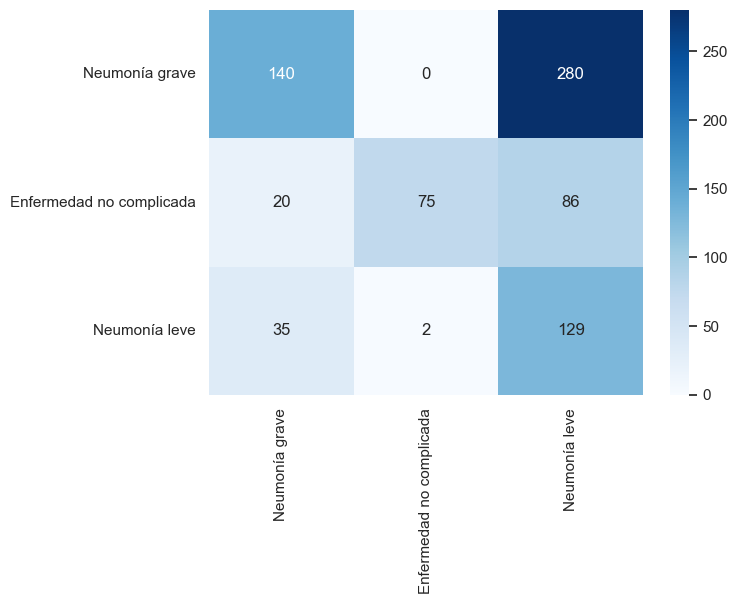

In [448]:
from sklearn.metrics import confusion_matrix

#los labels se deben colocar en el orden de los cluster (número). 
cm_labels = ['Neumonía grave', 'Enfermedad no complicada', 'Neumonía leve'  ]

cm = confusion_matrix(df_hierarchical_clusters['y_true'], df_hierarchical_clusters['Cluster'])

cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.heatmap(cm_array_df,  annot=True, fmt='g', cmap='Blues' )
plt.show() 

In [449]:
#df_hierarchical_clusters.to_excel("hierarchichal_final.xlsx", index=False)

In [450]:
pivot = pd.pivot_table(df_hierarchical_clusters, index=['Cluster'], columns='Muerte', aggfunc='size')
pivot2 = pd.pivot_table(df_hierarchical_clusters, index=['Gravedad'], columns='Muerte', aggfunc='size')
concat = pd.concat([pivot, pivot2])
concat['%muerte'] = 100*(concat[1]/(concat[1]+concat[0]))
concat

Muerte                        0      1    %muerte
1                         114.0   81.0  41.538462
2                          77.0    NaN        NaN
3                         379.0  116.0  23.434343
Enfermedad no complicada  179.0    2.0   1.104972
Neumonia grave            251.0  169.0  40.238095
Neumonia leve             140.0   26.0  15.662651

## Agglomerative clustering

In [451]:
num_clusters = 3 # ajustar!
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
cluster_agglomerative = agg_clustering.fit_predict(X_pca_9)

C:\Users\Usuario\anaconda3\envs\CDP_2\Lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


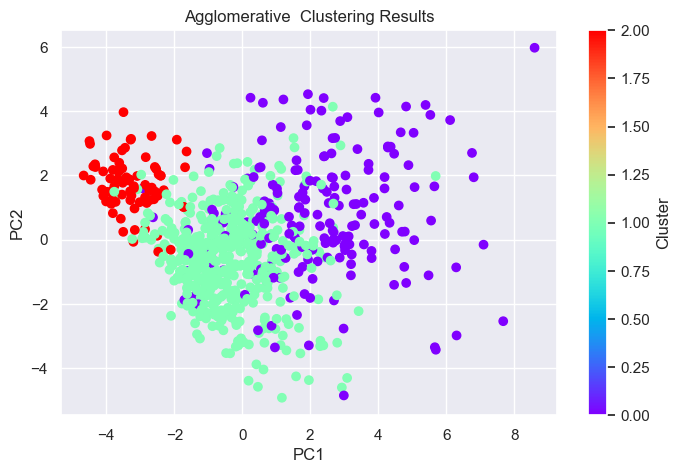

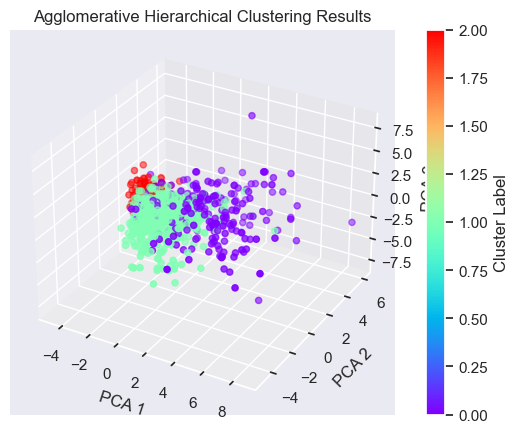

In [452]:
fig = plt.figure(figsize=(8,5))
plt.scatter(X_pca_9[:, 0], X_pca_9[:, 1], c=cluster_agglomerative, cmap='rainbow')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative  Clustering Results')
plt.colorbar(label='Cluster')
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_9[:, 0], X_pca_9[:, 1], X_pca_9[:, 2], c=cluster_agglomerative, cmap='rainbow')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('Agglomerative Hierarchical Clustering Results')

legend = plt.colorbar(scatter, ax=ax)
legend.set_label('Cluster Label')

plt.show()

In [453]:
df_agglomerative_clusters = df_1.copy()
df_agglomerative_clusters['Cluster'] = cluster_agglomerative
#df_agglomerative_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
print(df_agglomerative_clusters['Cluster'].unique())
df_agglomerative_clusters
#df_hierarchical_clusters.to_excel("agglomerative_4.xlsx", index=False)

[1 2 0]


Antiagregantes plaquetarios_si_no  Anticoagulantes_si_no  \
0                                    0                      0   
1                                    0                      0   
2                                    0                      0   
3                                    0                      0   
4                                    0                      0   
..                                 ...                    ...   
769                                  0                      0   
770                                  0                      0   
771                                  0                      0   
772                                  0                      0   
773                                  0                      0   

     Artritis reumatoide  CURB-65_calculado  Cardiopatia isquemica  Cianosis  \
0                      0                  2                      0         0   
1                      0                  3                      0         0   
2                      0                  0                      0         0   
3                      0                  0                      0         0   
4                      0                  0                      0         0   
..                   ...                ...                    ...       ...   
769                    0                  1                      0         0   
770                    0                  0                      0         0   
771                    0                  0                      0         0   
772                    0                  1                      0         0   
773                    0                  1                      0         0   

     Cirrosis/enfermedad hepática crónica  Creatinina ingreso  Demencia  \
0                                       0                1.50         0   
1                                       0                2.09         0   
2                                       0                1.40         0   
3                                       0                0.83         0   
4                                       0                1.03         0   
..                                    ...                 ...       ...   
769                                     0                0.92         0   
770                                     0                0.85         0   
771                                     0                0.67         0   
772                                     0                1.03         0   
773                                     0                0.83         0   

     Deshidratacion  ...         TAM  TVP  Tabaquismo  Tirajes  Transplantes  \
0                 0  ...  108.666667    0           0        0             0   
1                 0  ...  112.666667    0           0        0             0   
2                 0  ...  101.000000    0           0        0             0   
3                 0  ...  113.666667    0           0        0             0   
4                 0  ...   93.333333    0           0        0             0   
..              ...  ...         ...  ...         ...      ...           ...   
769               0  ...  109.666667    0           0        0             0   
770               0  ...   94.666667    0           0        0             0   
771               0  ...   93.333333    0           0        0             0   
772               0  ...  105.333333    0           0        0             0   
773               0  ...   94.666667    0           0        0             0   

     Trastornos psiquiatricos  VIH  Nivel educativo  Afiliación SGSSS  Cluster  
0                           0    0                4                 0        1  
1                           0    0                4                 0        1  
2                           0    0                4                 0        1  
3                           0    0                2                 0        

In [454]:
df_agglomerative_clusters.groupby('Cluster').agg(['mean']).T

Cluster                                                0              1  \
Antiagregantes plaquetarios_si_no    mean       0.153846       0.002020   
Anticoagulantes_si_no                mean       0.025641       0.008081   
Artritis reumatoide                  mean       0.005128       0.020202   
CURB-65_calculado                    mean       1.528205       0.715152   
Cardiopatia isquemica                mean       0.117949       0.000000   
Cianosis                             mean       0.035897       0.000000   
Cirrosis/enfermedad hepática crónica mean       0.005128       0.000000   
Creatinina ingreso                   mean       1.975590       0.957495   
Demencia                             mean       0.051282       0.000000   
Deshidratacion                       mean       0.071795       0.034343   
Diabetes mellitus                    mean       0.353846       0.173737   
Dias_sintomas_antes_de_consulta      mean       5.861538       6.214141   
Dolor abdominal                      mean       0.025641       0.064646   
EPOC                                 mean       0.312821       0.026263   
Edad (años)                          mean      68.184615      55.268687   
Embarazo_si_no                       mean       0.000000       0.000000   
Enfermedad renal crónica             mean       0.241026       0.014141   
Enfermedad valvular                  mean       0.035897       0.000000   
Estertores                           mean       0.256410       0.204040   
FC ingreso                           mean      92.225641      95.557576   
FR ingreso                           mean      22.220513      21.880808   
Falla cardiaca                       mean       0.138462       0.012121   
Fiebre/escalofrios                   mean       0.589744       0.773737   
Hb ingreso                           mean      13.822308      14.406283   
Hipertensión arterial                mean       0.666667       0.323232   
Hombre                               mean       0.656410       0.632323   
Indice de Charlson                   mean       3.989744       1.480808   
Leucocitos ingreso                   mean   10067.282051    9719.618182   
Neoplasia hematológica               mean       0.005128       0.000000   
Neoplasia sólida                     mean       0.087179       0.002020   
Obesidad                             mean       0.143590       0.202020   
Oxigeno suplementario                mean       0.943590       0.961616   
Plaquetas ingreso                    mean  245137.948718  262961.414141   
Roncus                               mean       0.153846       0.117172   
Rx_ingreso_Con_alteraciones_si_no    mean       0.641026       0.505051   
Sat02 ingreso                        mean      83.882051      87.663636   
Score News2_calculado                mean       7.205128       6.624242   
Sibilancias                          mean       0.117949       0.000000   
T ingreso                            mean      36.650769      36.689899   
TAM                                  mean      93.087179      94.127946   
TVP                                  mean       0.015385       0.000000   
Tabaquismo                           mean       0.220513       0.012121   
Tirajes                              mean       0.112821       0.070707   
Transplantes                         mean       0.015385       0.000000   
Trastornos psiquiatricos             mean       0.005128       0.016162   
VIH                                  mean       0.015385       0.000000   
Nivel educativo                      mean       3.600000       3.787879   
Afiliación SGSSS                     mean       0.543590       0.296970   

Cluster                                                2  
Antiagregantes plaquetarios_si_no    mean       0.012987  
Anticoagulantes_si_no                mean       0.012987  
Artritis reumatoide                  mean       0.000000  
CURB-65_calculado                    mean       0.155844  
Cardiopatia isquemica        

In [455]:
df_agglomerative_clusters['UCI'] = df_imputed_multiple['Ingreso a UCI']
df_agglomerative_clusters['Muerte'] = df_imputed_multiple['Muerto_si_no']
df_agglomerative_clusters.groupby('Cluster' ).agg(['mean']).T

Cluster                                                0              1  \
Antiagregantes plaquetarios_si_no    mean       0.153846       0.002020   
Anticoagulantes_si_no                mean       0.025641       0.008081   
Artritis reumatoide                  mean       0.005128       0.020202   
CURB-65_calculado                    mean       1.528205       0.715152   
Cardiopatia isquemica                mean       0.117949       0.000000   
Cianosis                             mean       0.035897       0.000000   
Cirrosis/enfermedad hepática crónica mean       0.005128       0.000000   
Creatinina ingreso                   mean       1.975590       0.957495   
Demencia                             mean       0.051282       0.000000   
Deshidratacion                       mean       0.071795       0.034343   
Diabetes mellitus                    mean       0.353846       0.173737   
Dias_sintomas_antes_de_consulta      mean       5.861538       6.214141   
Dolor abdominal                      mean       0.025641       0.064646   
EPOC                                 mean       0.312821       0.026263   
Edad (años)                          mean      68.184615      55.268687   
Embarazo_si_no                       mean       0.000000       0.000000   
Enfermedad renal crónica             mean       0.241026       0.014141   
Enfermedad valvular                  mean       0.035897       0.000000   
Estertores                           mean       0.256410       0.204040   
FC ingreso                           mean      92.225641      95.557576   
FR ingreso                           mean      22.220513      21.880808   
Falla cardiaca                       mean       0.138462       0.012121   
Fiebre/escalofrios                   mean       0.589744       0.773737   
Hb ingreso                           mean      13.822308      14.406283   
Hipertensión arterial                mean       0.666667       0.323232   
Hombre                               mean       0.656410       0.632323   
Indice de Charlson                   mean       3.989744       1.480808   
Leucocitos ingreso                   mean   10067.282051    9719.618182   
Neoplasia hematológica               mean       0.005128       0.000000   
Neoplasia sólida                     mean       0.087179       0.002020   
Obesidad                             mean       0.143590       0.202020   
Oxigeno suplementario                mean       0.943590       0.961616   
Plaquetas ingreso                    mean  245137.948718  262961.414141   
Roncus                               mean       0.153846       0.117172   
Rx_ingreso_Con_alteraciones_si_no    mean       0.641026       0.505051   
Sat02 ingreso                        mean      83.882051      87.663636   
Score News2_calculado                mean       7.205128       6.624242   
Sibilancias                          mean       0.117949       0.000000   
T ingreso                            mean      36.650769      36.689899   
TAM                                  mean      93.087179      94.127946   
TVP                                  mean       0.015385       0.000000   
Tabaquismo                           mean       0.220513       0.012121   
Tirajes                              mean       0.112821       0.070707   
Transplantes                         mean       0.015385       0.000000   
Trastornos psiquiatricos             mean       0.005128       0.016162   
VIH                                  mean       0.015385       0.000000   
Nivel educativo                      mean       3.600000       3.787879   
Afiliación SGSSS                     mean       0.543590       0.296970   
UCI                                  mean       0.435897       0.325253   
Muerte                               mean       0.415385       0.234343   

Cluster                                                2  
Antiagregantes plaquetarios_si_no    mean       0.012987  
Anticoagulantes_si_no                mean       0.012987

In [456]:
df_agglomerative_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
df_agglomerative_clusters.groupby('Gravedad' ).agg(['mean']).T

Gravedad                                   Enfermedad no complicada  \
Antiagregantes plaquetarios_si_no    mean                  0.027624   
Anticoagulantes_si_no                mean                  0.005525   
Artritis reumatoide                  mean                  0.011050   
CURB-65_calculado                    mean                  0.375691   
Cardiopatia isquemica                mean                  0.005525   
Cianosis                             mean                  0.000000   
Cirrosis/enfermedad hepática crónica mean                  0.000000   
Creatinina ingreso                   mean                  1.017624   
Demencia                             mean                  0.005525   
Deshidratacion                       mean                  0.011050   
Diabetes mellitus                    mean                  0.110497   
Dias_sintomas_antes_de_consulta      mean                  5.071823   
Dolor abdominal                      mean                  0.093923   
EPOC                                 mean                  0.033149   
Edad (años)                          mean                 47.453039   
Embarazo_si_no                       mean                  0.071823   
Enfermedad renal crónica             mean                  0.038674   
Enfermedad valvular                  mean                  0.000000   
Estertores                           mean                  0.049724   
FC ingreso                           mean                 88.745856   
FR ingreso                           mean                 19.646409   
Falla cardiaca                       mean                  0.027624   
Fiebre/escalofrios                   mean                  0.662983   
Hb ingreso                           mean                 14.133315   
Hipertensión arterial                mean                  0.281768   
Hombre                               mean                  0.574586   
Indice de Charlson                   mean                  1.116022   
Leucocitos ingreso                   mean               7942.756906   
Neoplasia hematológica               mean                  0.000000   
Neoplasia sólida                     mean                  0.016575   
Obesidad                             mean                  0.160221   
Oxigeno suplementario                mean                  0.480663   
Plaquetas ingreso                    mean             279723.756906   
Roncus                               mean                  0.033149   
Rx_ingreso_Con_alteraciones_si_no    mean                  0.270718   
Sat02 ingreso                        mean                 94.182320   
Score News2_calculado                mean                  3.662983   
Sibilancias                          mean                  0.033149   
T ingreso                            mean                 36.718785   
TAM                                  mean                 91.263352   
TVP                                  mean                  0.000000   
Tabaquismo                           mean                  0.044199   
Tirajes                              mean                  0.027624   
Transplantes                         mean                  0.000000   
Trastornos psiquiatricos             mean                  0.011050   
VIH                                  mean                  0.000000   
Nivel educativo                      mean                  3.596685   
Afiliación SGSSS                     mean                  0.475138   
Cluster                              mean                  1.303867   
UCI                                  mean                  0.016575   
Muerte                               mean                  0.011050   

Gravedad                                   Neumonia grave  Neumonia leve  
Antiagregantes plaquetarios_si_no    mean        0.045238       0.048193  
Anticoagulantes_si_no                mean        0.019048       0.006024  
Artritis reumatoide                  mean        0.019048       0.006024  
CURB-65

In [457]:
#los números de recodificación deben coincidir con las características de los clúster. Esto se hace verificando las métricas de cada clúster
df_agglomerative_clusters['y_true'] = df_agglomerative_clusters['Gravedad'].map({'Neumonia grave':0, 
                                                 'Enfermedad no complicada': 2,
                                                 'Neumonia leve':1})
df_agglomerative_clusters.head()

#df_kmeans_clusters.to_excel("kmeans_matrix.xlsx", index=False)

Antiagregantes plaquetarios_si_no  Anticoagulantes_si_no  \
0                                  0                      0   
1                                  0                      0   
2                                  0                      0   
3                                  0                      0   
4                                  0                      0   

   Artritis reumatoide  CURB-65_calculado  Cardiopatia isquemica  Cianosis  \
0                    0                  2                      0         0   
1                    0                  3                      0         0   
2                    0                  0                      0         0   
3                    0                  0                      0         0   
4                    0                  0                      0         0   

   Cirrosis/enfermedad hepática crónica  Creatinina ingreso  Demencia  \
0                                     0                1.50         0   
1                                     0                2.09         0   
2                                     0                1.40         0   
3                                     0                0.83         0   
4                                     0                1.03         0   

   Deshidratacion  ...  Transplantes  Trastornos psiquiatricos  VIH  \
0               0  ...             0                         0    0   
1               0  ...             0                         0    0   
2               0  ...             0                         0    0   
3               0  ...             0                         0    0   
4               0  ...             0                         0    0   

   Nivel educativo  Afiliación SGSSS  Cluster  UCI  Muerte  \
0                4                 0        1    1       0   
1                4                 0        1    1       1   
2                4                 0        1    0       0   
3                2                 0        2    0       0   
4                3                 0        1    0       0   

                   Gravedad  y_true  
0            Neumonia grave       0  
1            Neumonia grave       0  
2  Enfermedad no complicada       2  
3  Enfermedad no complicada       2  
4             Neumonia leve       1  

[5 rows x 53 columns]

In [458]:
from sklearn.metrics import adjusted_rand_score
y_true = df_agglomerative_clusters['y_true']
y_pred = df_agglomerative_clusters['Cluster']

ari_score = adjusted_rand_score(y_true, y_pred)

print(f"ARI Score: {ari_score}")

ARI Score: 0.08731700539995177


In [459]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [460]:
from scipy.optimize import linear_sum_assignment as linear_assignment
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(w.max() - w)
accu = sum([w[i, j] for i, j in zip(ind[0],ind[1])]) * 1.0 / y_pred.size
print("El accuracy es:", accu)

El accuracy es: 0.5084745762711864


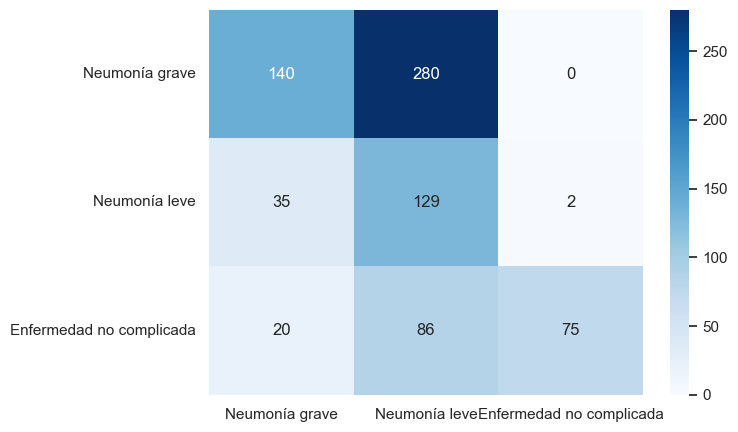

In [461]:
from sklearn.metrics import confusion_matrix

#los labels se deben colocar en el orden de los cluster (número). 
cm_labels = ['Neumonía grave', 'Neumonía leve' , 'Enfermedad no complicada'  ]

cm = confusion_matrix(df_agglomerative_clusters['y_true'], df_agglomerative_clusters['Cluster'])

cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.heatmap(cm_array_df,  annot=True, fmt='g', cmap='Blues' )
plt.show() 

In [462]:
#df_agglomerative_clusters.to_excel("df_agglomerative_clusters.xlsx", index=False)

In [463]:
pivot = pd.pivot_table(df_agglomerative_clusters, index=['Cluster'], columns='Muerte', aggfunc='size')
pivot2 = pd.pivot_table(df_agglomerative_clusters, index=['Gravedad'], columns='Muerte', aggfunc='size')
concat = pd.concat([pivot, pivot2])
concat['%muerte'] = 100*(concat[1]/(concat[1]+concat[0]))
concat

Muerte                        0      1    %muerte
0                         114.0   81.0  41.538462
1                         379.0  116.0  23.434343
2                          77.0    NaN        NaN
Enfermedad no complicada  179.0    2.0   1.104972
Neumonia grave            251.0  169.0  40.238095
Neumonia leve             140.0   26.0  15.662651

# K-medoides

In [464]:
from sklearn_extra.cluster import KMedoids
num_clusters = 3  # ajustar!
kmedoids = KMedoids(n_clusters=num_clusters, metric='euclidean', random_state=0)

cluster_kmedoids = kmedoids.fit_predict(X_pca_9)

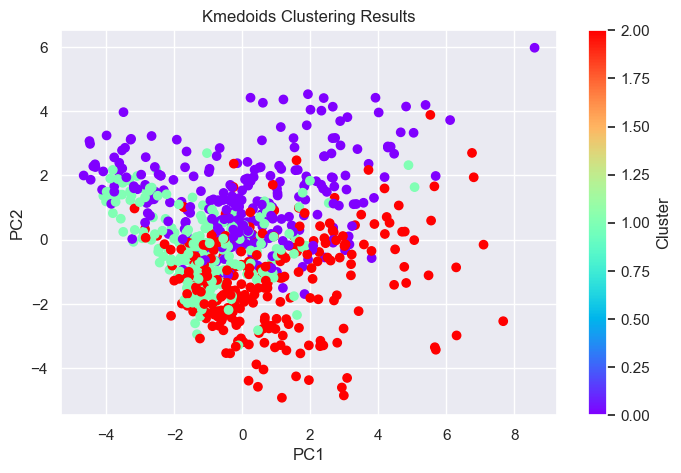

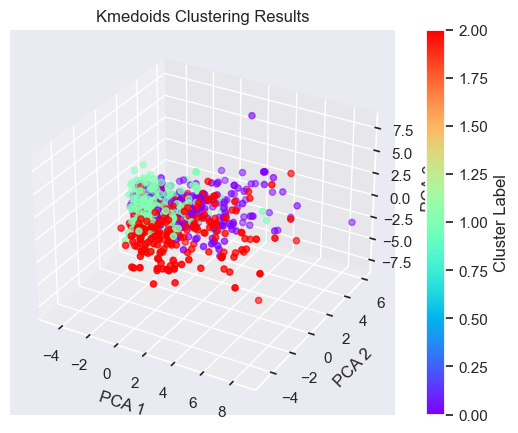

In [465]:
fig = plt.figure(figsize=(8,5))
plt.scatter(X_pca_9[:, 0], X_pca_9[:, 1], c=cluster_kmedoids, cmap='rainbow')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Kmedoids Clustering Results')
plt.colorbar(label='Cluster')
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_9[:, 0], X_pca_9[:, 1], X_pca_9[:, 2], c=cluster_kmedoids, cmap='rainbow')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('Kmedoids Clustering Results')

legend = plt.colorbar(scatter, ax=ax)
legend.set_label('Cluster Label')

plt.show()

In [466]:
df_kmedoids_clusters = df_1.copy()
df_kmedoids_clusters['Cluster'] = cluster_kmedoids
#df_kmedoids_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
print(df_kmedoids_clusters['Cluster'].unique())
df_kmedoids_clusters
#df_kmedoids_clusters.to_excel("kmedoids_4.xlsx", index=False)

[2 0 1]


Antiagregantes plaquetarios_si_no  Anticoagulantes_si_no  \
0                                    0                      0   
1                                    0                      0   
2                                    0                      0   
3                                    0                      0   
4                                    0                      0   
..                                 ...                    ...   
769                                  0                      0   
770                                  0                      0   
771                                  0                      0   
772                                  0                      0   
773                                  0                      0   

     Artritis reumatoide  CURB-65_calculado  Cardiopatia isquemica  Cianosis  \
0                      0                  2                      0         0   
1                      0                  3                      0         0   
2                      0                  0                      0         0   
3                      0                  0                      0         0   
4                      0                  0                      0         0   
..                   ...                ...                    ...       ...   
769                    0                  1                      0         0   
770                    0                  0                      0         0   
771                    0                  0                      0         0   
772                    0                  1                      0         0   
773                    0                  1                      0         0   

     Cirrosis/enfermedad hepática crónica  Creatinina ingreso  Demencia  \
0                                       0                1.50         0   
1                                       0                2.09         0   
2                                       0                1.40         0   
3                                       0                0.83         0   
4                                       0                1.03         0   
..                                    ...                 ...       ...   
769                                     0                0.92         0   
770                                     0                0.85         0   
771                                     0                0.67         0   
772                                     0                1.03         0   
773                                     0                0.83         0   

     Deshidratacion  ...         TAM  TVP  Tabaquismo  Tirajes  Transplantes  \
0                 0  ...  108.666667    0           0        0             0   
1                 0  ...  112.666667    0           0        0             0   
2                 0  ...  101.000000    0           0        0             0   
3                 0  ...  113.666667    0           0        0             0   
4                 0  ...   93.333333    0           0        0             0   
..              ...  ...         ...  ...         ...      ...           ...   
769               0  ...  109.666667    0           0        0             0   
770               0  ...   94.666667    0           0        0             0   
771               0  ...   93.333333    0           0        0             0   
772               0  ...  105.333333    0           0        0             0   
773               0  ...   94.666667    0           0        0             0   

     Trastornos psiquiatricos  VIH  Nivel educativo  Afiliación SGSSS  Cluster  
0                           0    0                4                 0        2  
1                           0    0                4                 0        0  
2                           0    0                4                 0        1  
3                           0    0                2                 0        

In [467]:
df_kmedoids_clusters.groupby('Cluster').agg(['mean']).T

Cluster                                                0              1  \
Antiagregantes plaquetarios_si_no    mean       0.064516       0.035088   
Anticoagulantes_si_no                mean       0.021505       0.004386   
Artritis reumatoide                  mean       0.014337       0.021930   
CURB-65_calculado                    mean       0.982079       0.350877   
Cardiopatia isquemica                mean       0.035842       0.013158   
Cianosis                             mean       0.007168       0.004386   
Cirrosis/enfermedad hepática crónica mean       0.003584       0.000000   
Creatinina ingreso                   mean       1.359570       0.994474   
Demencia                             mean       0.003584       0.004386   
Deshidratacion                       mean       0.032258       0.070175   
Diabetes mellitus                    mean       0.301075       0.096491   
Dias_sintomas_antes_de_consulta      mean       5.741935       5.302632   
Dolor abdominal                      mean       0.078853       0.017544   
EPOC                                 mean       0.150538       0.017544   
Edad (años)                          mean      63.086022      49.289474   
Embarazo_si_no                       mean       0.046595       0.000000   
Enfermedad renal crónica             mean       0.114695       0.017544   
Enfermedad valvular                  mean       0.003584       0.004386   
Estertores                           mean       0.121864       0.271930   
FC ingreso                           mean      85.655914      92.460526   
FR ingreso                           mean      19.924731      19.868421   
Falla cardiaca                       mean       0.086022       0.008772   
Fiebre/escalofrios                   mean       0.616487       0.758772   
Hb ingreso                           mean      13.258853      15.090789   
Hipertensión arterial                mean       0.566308       0.236842   
Hombre                               mean       0.444444       0.780702   
Indice de Charlson                   mean       2.749104       1.017544   
Leucocitos ingreso                   mean    8845.946237    9534.219298   
Neoplasia hematológica               mean       0.003584       0.000000   
Neoplasia sólida                     mean       0.014337       0.008772   
Obesidad                             mean       0.164875       0.144737   
Oxigeno suplementario                mean       0.806452       0.815789   
Plaquetas ingreso                    mean  279789.964158  285272.807018   
Roncus                               mean       0.111111       0.122807   
Rx_ingreso_Con_alteraciones_si_no    mean       0.254480       0.688596   
Sat02 ingreso                        mean      90.598566      89.706140   
Score News2_calculado                mean       4.856631       5.250000   
Sibilancias                          mean       0.028674       0.021930   
T ingreso                            mean      36.521864      36.657456   
TAM                                  mean      92.995221      97.580409   
TVP                                  mean       0.007168       0.000000   
Tabaquismo                           mean       0.053763       0.109649   
Tirajes                              mean       0.050179       0.021930   
Transplantes                         mean       0.003584       0.004386   
Trastornos psiquiatricos             mean       0.014337       0.000000   
VIH                                  mean       0.000000       0.000000   
Nivel educativo                      mean       3.831541       3.614035   
Afiliación SGSSS                     mean       0.433692       0.179825   

Cluster                                                2  
Antiagregantes plaquetarios_si_no    mean       0.023077  
Anticoagulantes_si_no                mean       0.011538  
Artritis reumatoide                  mean       0.007692  
CURB-65_calculado                    mean       1.192308  
Cardiopatia isquemica        

In [468]:
df_kmedoids_clusters['UCI'] = df_imputed_multiple['Ingreso a UCI']
df_kmedoids_clusters['Muerte'] = df_imputed_multiple['Muerto_si_no']
df_kmedoids_clusters.groupby('Cluster' ).agg(['mean']).T

Cluster                                                0              1  \
Antiagregantes plaquetarios_si_no    mean       0.064516       0.035088   
Anticoagulantes_si_no                mean       0.021505       0.004386   
Artritis reumatoide                  mean       0.014337       0.021930   
CURB-65_calculado                    mean       0.982079       0.350877   
Cardiopatia isquemica                mean       0.035842       0.013158   
Cianosis                             mean       0.007168       0.004386   
Cirrosis/enfermedad hepática crónica mean       0.003584       0.000000   
Creatinina ingreso                   mean       1.359570       0.994474   
Demencia                             mean       0.003584       0.004386   
Deshidratacion                       mean       0.032258       0.070175   
Diabetes mellitus                    mean       0.301075       0.096491   
Dias_sintomas_antes_de_consulta      mean       5.741935       5.302632   
Dolor abdominal                      mean       0.078853       0.017544   
EPOC                                 mean       0.150538       0.017544   
Edad (años)                          mean      63.086022      49.289474   
Embarazo_si_no                       mean       0.046595       0.000000   
Enfermedad renal crónica             mean       0.114695       0.017544   
Enfermedad valvular                  mean       0.003584       0.004386   
Estertores                           mean       0.121864       0.271930   
FC ingreso                           mean      85.655914      92.460526   
FR ingreso                           mean      19.924731      19.868421   
Falla cardiaca                       mean       0.086022       0.008772   
Fiebre/escalofrios                   mean       0.616487       0.758772   
Hb ingreso                           mean      13.258853      15.090789   
Hipertensión arterial                mean       0.566308       0.236842   
Hombre                               mean       0.444444       0.780702   
Indice de Charlson                   mean       2.749104       1.017544   
Leucocitos ingreso                   mean    8845.946237    9534.219298   
Neoplasia hematológica               mean       0.003584       0.000000   
Neoplasia sólida                     mean       0.014337       0.008772   
Obesidad                             mean       0.164875       0.144737   
Oxigeno suplementario                mean       0.806452       0.815789   
Plaquetas ingreso                    mean  279789.964158  285272.807018   
Roncus                               mean       0.111111       0.122807   
Rx_ingreso_Con_alteraciones_si_no    mean       0.254480       0.688596   
Sat02 ingreso                        mean      90.598566      89.706140   
Score News2_calculado                mean       4.856631       5.250000   
Sibilancias                          mean       0.028674       0.021930   
T ingreso                            mean      36.521864      36.657456   
TAM                                  mean      92.995221      97.580409   
TVP                                  mean       0.007168       0.000000   
Tabaquismo                           mean       0.053763       0.109649   
Tirajes                              mean       0.050179       0.021930   
Transplantes                         mean       0.003584       0.004386   
Trastornos psiquiatricos             mean       0.014337       0.000000   
VIH                                  mean       0.000000       0.000000   
Nivel educativo                      mean       3.831541       3.614035   
Afiliación SGSSS                     mean       0.433692       0.179825   
UCI                                  mean       0.322581       0.197368   
Muerte                               mean       0.293907       0.127193   

Cluster                                                2  
Antiagregantes plaquetarios_si_no    mean       0.023077  
Anticoagulantes_si_no                mean       0.011538

In [469]:
df_kmedoids_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
df_kmedoids_clusters.groupby('Gravedad' ).agg(['mean']).T

Gravedad                                   Enfermedad no complicada  \
Antiagregantes plaquetarios_si_no    mean                  0.027624   
Anticoagulantes_si_no                mean                  0.005525   
Artritis reumatoide                  mean                  0.011050   
CURB-65_calculado                    mean                  0.375691   
Cardiopatia isquemica                mean                  0.005525   
Cianosis                             mean                  0.000000   
Cirrosis/enfermedad hepática crónica mean                  0.000000   
Creatinina ingreso                   mean                  1.017624   
Demencia                             mean                  0.005525   
Deshidratacion                       mean                  0.011050   
Diabetes mellitus                    mean                  0.110497   
Dias_sintomas_antes_de_consulta      mean                  5.071823   
Dolor abdominal                      mean                  0.093923   
EPOC                                 mean                  0.033149   
Edad (años)                          mean                 47.453039   
Embarazo_si_no                       mean                  0.071823   
Enfermedad renal crónica             mean                  0.038674   
Enfermedad valvular                  mean                  0.000000   
Estertores                           mean                  0.049724   
FC ingreso                           mean                 88.745856   
FR ingreso                           mean                 19.646409   
Falla cardiaca                       mean                  0.027624   
Fiebre/escalofrios                   mean                  0.662983   
Hb ingreso                           mean                 14.133315   
Hipertensión arterial                mean                  0.281768   
Hombre                               mean                  0.574586   
Indice de Charlson                   mean                  1.116022   
Leucocitos ingreso                   mean               7942.756906   
Neoplasia hematológica               mean                  0.000000   
Neoplasia sólida                     mean                  0.016575   
Obesidad                             mean                  0.160221   
Oxigeno suplementario                mean                  0.480663   
Plaquetas ingreso                    mean             279723.756906   
Roncus                               mean                  0.033149   
Rx_ingreso_Con_alteraciones_si_no    mean                  0.270718   
Sat02 ingreso                        mean                 94.182320   
Score News2_calculado                mean                  3.662983   
Sibilancias                          mean                  0.033149   
T ingreso                            mean                 36.718785   
TAM                                  mean                 91.263352   
TVP                                  mean                  0.000000   
Tabaquismo                           mean                  0.044199   
Tirajes                              mean                  0.027624   
Transplantes                         mean                  0.000000   
Trastornos psiquiatricos             mean                  0.011050   
VIH                                  mean                  0.000000   
Nivel educativo                      mean                  3.596685   
Afiliación SGSSS                     mean                  0.475138   
Cluster                              mean                  0.635359   
UCI                                  mean                  0.016575   
Muerte                               mean                  0.011050   

Gravedad                                   Neumonia grave  Neumonia leve  
Antiagregantes plaquetarios_si_no    mean        0.045238       0.048193  
Anticoagulantes_si_no                mean        0.019048       0.006024  
Artritis reumatoide                  mean        0.019048       0.006024  
CURB-65

In [470]:
#los números de recodificación deben coincidir con las características de los clúster. Esto se hace verificando las métricas de cada clúster
df_kmedoids_clusters['y_true'] = df_kmedoids_clusters['Gravedad'].map({'Neumonia grave':2, 
                                                 'Enfermedad no complicada': 1,
                                                 'Neumonia leve':0})
df_kmedoids_clusters.head()

#df_kmeans_clusters.to_excel("kmeans_matrix.xlsx", index=False)

Antiagregantes plaquetarios_si_no  Anticoagulantes_si_no  \
0                                  0                      0   
1                                  0                      0   
2                                  0                      0   
3                                  0                      0   
4                                  0                      0   

   Artritis reumatoide  CURB-65_calculado  Cardiopatia isquemica  Cianosis  \
0                    0                  2                      0         0   
1                    0                  3                      0         0   
2                    0                  0                      0         0   
3                    0                  0                      0         0   
4                    0                  0                      0         0   

   Cirrosis/enfermedad hepática crónica  Creatinina ingreso  Demencia  \
0                                     0                1.50         0   
1                                     0                2.09         0   
2                                     0                1.40         0   
3                                     0                0.83         0   
4                                     0                1.03         0   

   Deshidratacion  ...  Transplantes  Trastornos psiquiatricos  VIH  \
0               0  ...             0                         0    0   
1               0  ...             0                         0    0   
2               0  ...             0                         0    0   
3               0  ...             0                         0    0   
4               0  ...             0                         0    0   

   Nivel educativo  Afiliación SGSSS  Cluster  UCI  Muerte  \
0                4                 0        2    1       0   
1                4                 0        0    1       1   
2                4                 0        1    0       0   
3                2                 0        1    0       0   
4                3                 0        1    0       0   

                   Gravedad  y_true  
0            Neumonia grave       2  
1            Neumonia grave       2  
2  Enfermedad no complicada       1  
3  Enfermedad no complicada       1  
4             Neumonia leve       0  

[5 rows x 53 columns]

In [471]:
from sklearn.metrics import adjusted_rand_score
y_true = df_kmedoids_clusters['y_true']
y_pred = df_kmedoids_clusters['Cluster']

ari_score = adjusted_rand_score(y_true, y_pred)

print(f"ARI Score: {ari_score}")

ARI Score: 0.07105555071277057


In [472]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [473]:
from scipy.optimize import linear_sum_assignment as linear_assignment
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(w.max() - w)
accu = sum([w[i, j] for i, j in zip(ind[0],ind[1])]) * 1.0 / y_pred.size
print("El accuracy es:", accu)

El accuracy es: 0.4784876140808344


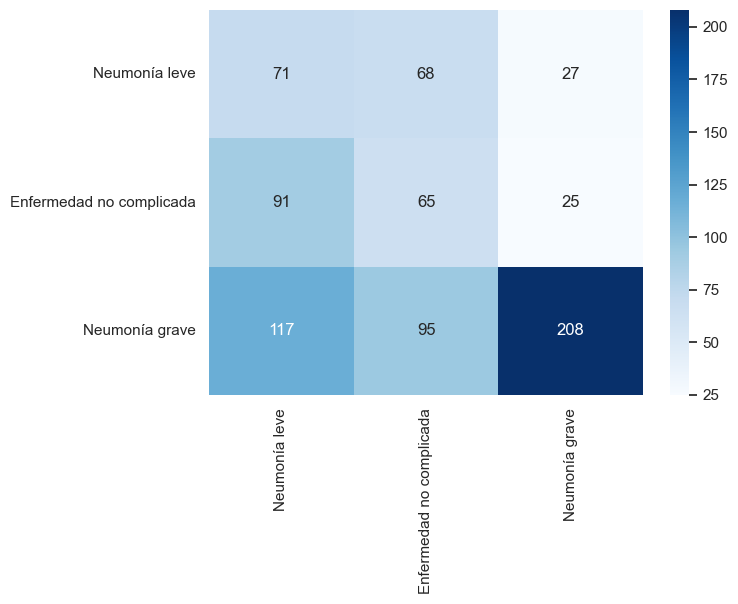

In [474]:
from sklearn.metrics import confusion_matrix

#los labels se deben colocar en el orden de los cluster (número). 
cm_labels = [  'Neumonía leve', 'Enfermedad no complicada', 'Neumonía grave'  ]

cm = confusion_matrix(df_kmedoids_clusters['y_true'], df_kmedoids_clusters['Cluster'])

cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.heatmap(cm_array_df,  annot=True, fmt='g', cmap='Blues' )
plt.show() 

In [475]:
pivot = pd.pivot_table(df_kmedoids_clusters, index=['Cluster'], columns='Muerte', aggfunc='size')
pivot2 = pd.pivot_table(df_kmedoids_clusters, index=['Gravedad'], columns='Muerte', aggfunc='size')
concat = pd.concat([pivot, pivot2])
concat['%muerte'] = 100*(concat[1]/(concat[1]+concat[0]))
concat

Muerte                      0    1    %muerte
0                         197   82  29.390681
1                         199   29  12.719298
2                         174   86  33.076923
Enfermedad no complicada  179    2   1.104972
Neumonia grave            251  169  40.238095
Neumonia leve             140   26  15.662651

# K-Means

In [476]:
from sklearn.cluster import KMeans

num_clusters = 3  # ajustar!
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_kmeans = kmeans.fit_predict(X_pca_9)


C:\Users\Usuario\anaconda3\envs\CDP_2\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [477]:
silhouette_avg = silhouette_score(X_pca_9, kmeans.labels_)

print(f"El coeficiente de silhouette promedio para 40 clusters es: {silhouette_avg}")

El coeficiente de silhouette promedio para 40 clusters es: 0.08027692371015323


In [478]:
varianza_intra_cluster = []
silhouettes = []
Y = {}
silhouette = 0
for k in range (1, 50): # Evaluamos entre 1 a 200 clusters
    kmeans = KMeans(n_clusters = k, random_state = 123, n_init=10).fit(X_pca_9)
    varianza_intra_cluster.append(kmeans.inertia_)
    try:
        silhouette = silhouette_score(X_pca_9, kmeans.labels_)
    except:
        silhouette = 0 
    silhouettes.append(silhouette)
    Y[k] = kmeans.labels_

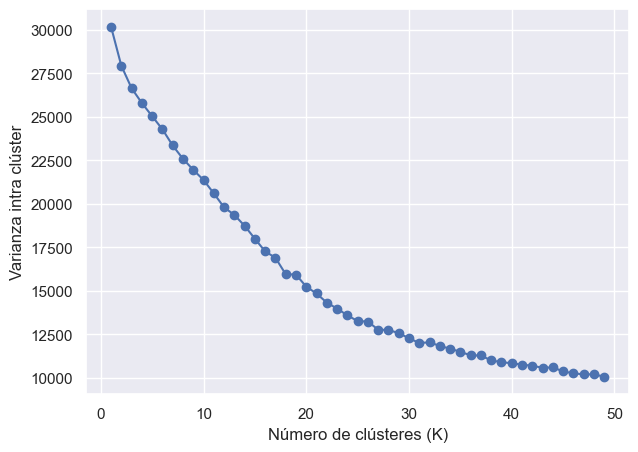

In [479]:
plt.plot(range(1, 50), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

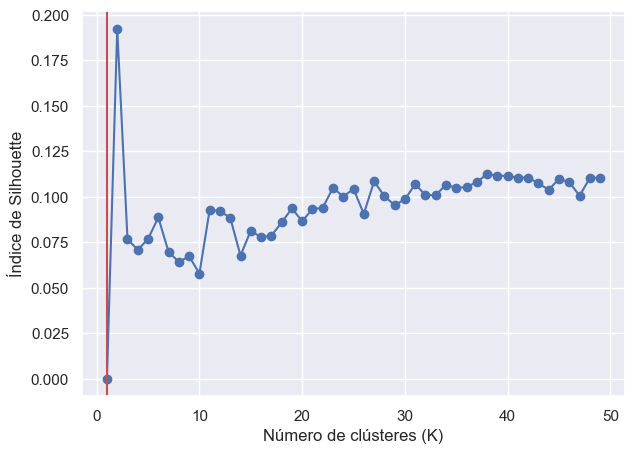

In [480]:
plt.plot(range(1, 50), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.axvline(x = silhouettes.index(max(silhouettes)), color = 'r', label = 'axvline - full height')
plt.ylabel('Índice de Silhouette')
plt.show()

In [481]:
print(f'el valor estimado como número adecuado de clúster es: {silhouettes.index(max(silhouettes))}')

el valor estimado como número adecuado de clúster es: 1


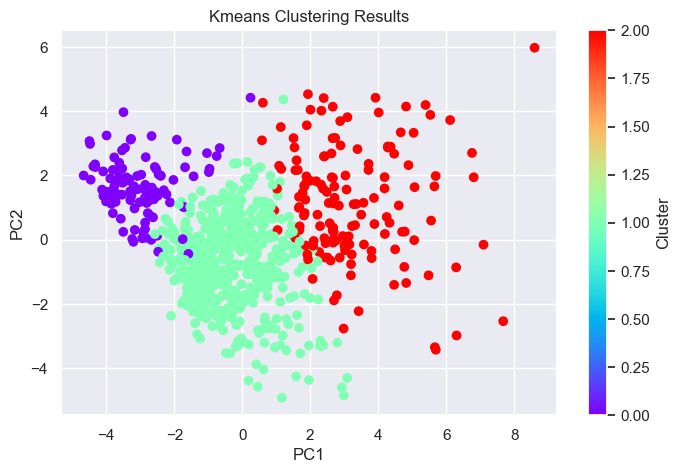

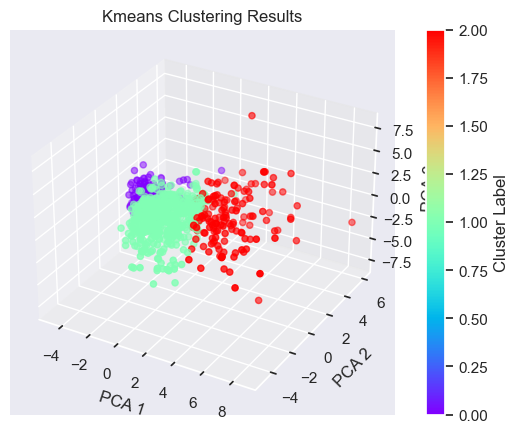

In [482]:
fig = plt.figure(figsize=(8,5))
plt.scatter(X_pca_9[:, 0], X_pca_9[:, 1], c=cluster_kmeans, cmap='rainbow')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Kmeans Clustering Results')
plt.colorbar(label='Cluster')
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_9[:, 0], X_pca_9[:, 1], X_pca_9[:, 2], c=cluster_kmeans, cmap='rainbow')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('Kmeans Clustering Results')

legend = plt.colorbar(scatter, ax=ax)
legend.set_label('Cluster Label')

plt.show()

In [483]:
df_kmeans_clusters = df_1.copy()
df_kmeans_clusters['Cluster'] = cluster_kmeans
#df_kmeans_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
print(df_kmeans_clusters['Cluster'].unique())
df_kmeans_clusters
#df_kmeans_clusters.to_excel("kmeans_4.xlsx", index=False)

[1 2 0]


Antiagregantes plaquetarios_si_no  Anticoagulantes_si_no  \
0                                    0                      0   
1                                    0                      0   
2                                    0                      0   
3                                    0                      0   
4                                    0                      0   
..                                 ...                    ...   
769                                  0                      0   
770                                  0                      0   
771                                  0                      0   
772                                  0                      0   
773                                  0                      0   

     Artritis reumatoide  CURB-65_calculado  Cardiopatia isquemica  Cianosis  \
0                      0                  2                      0         0   
1                      0                  3                      0         0   
2                      0                  0                      0         0   
3                      0                  0                      0         0   
4                      0                  0                      0         0   
..                   ...                ...                    ...       ...   
769                    0                  1                      0         0   
770                    0                  0                      0         0   
771                    0                  0                      0         0   
772                    0                  1                      0         0   
773                    0                  1                      0         0   

     Cirrosis/enfermedad hepática crónica  Creatinina ingreso  Demencia  \
0                                       0                1.50         0   
1                                       0                2.09         0   
2                                       0                1.40         0   
3                                       0                0.83         0   
4                                       0                1.03         0   
..                                    ...                 ...       ...   
769                                     0                0.92         0   
770                                     0                0.85         0   
771                                     0                0.67         0   
772                                     0                1.03         0   
773                                     0                0.83         0   

     Deshidratacion  ...         TAM  TVP  Tabaquismo  Tirajes  Transplantes  \
0                 0  ...  108.666667    0           0        0             0   
1                 0  ...  112.666667    0           0        0             0   
2                 0  ...  101.000000    0           0        0             0   
3                 0  ...  113.666667    0           0        0             0   
4                 0  ...   93.333333    0           0        0             0   
..              ...  ...         ...  ...         ...      ...           ...   
769               0  ...  109.666667    0           0        0             0   
770               0  ...   94.666667    0           0        0             0   
771               0  ...   93.333333    0           0        0             0   
772               0  ...  105.333333    0           0        0             0   
773               0  ...   94.666667    0           0        0             0   

     Trastornos psiquiatricos  VIH  Nivel educativo  Afiliación SGSSS  Cluster  
0                           0    0                4                 0        1  
1                           0    0                4                 0        2  
2                           0    0                4                 0        1  
3                           0    0                2                 0        

In [484]:
df_kmeans_clusters['UCI'] = df_imputed_multiple['Ingreso a UCI']
df_kmeans_clusters['Muerte'] = df_imputed_multiple['Muerto_si_no']
df_kmeans_clusters.groupby('Cluster' ).agg(['mean']).T

Cluster                                                0              1  \
Antiagregantes plaquetarios_si_no    mean       0.029126       0.023166   
Anticoagulantes_si_no                mean       0.009709       0.009653   
Artritis reumatoide                  mean       0.000000       0.015444   
CURB-65_calculado                    mean       0.135922       0.698842   
Cardiopatia isquemica                mean       0.000000       0.000000   
Cianosis                             mean       0.009709       0.007722   
Cirrosis/enfermedad hepática crónica mean       0.000000       0.000000   
Creatinina ingreso                   mean       0.833495       0.960579   
Demencia                             mean       0.000000       0.001931   
Deshidratacion                       mean       0.000000       0.034749   
Diabetes mellitus                    mean       0.058252       0.160232   
Dias_sintomas_antes_de_consulta      mean       4.349515       6.494208   
Dolor abdominal                      mean       0.067961       0.048263   
EPOC                                 mean       0.009709       0.032819   
Edad (años)                          mean      40.116505      55.036680   
Embarazo_si_no                       mean       0.135922       0.000000   
Enfermedad renal crónica             mean       0.000000       0.007722   
Enfermedad valvular                  mean       0.000000       0.007722   
Estertores                           mean       0.029126       0.233591   
FC ingreso                           mean      85.757282      96.320463   
FR ingreso                           mean      18.592233      21.980695   
Falla cardiaca                       mean       0.009709       0.009653   
Fiebre/escalofrios                   mean       0.650485       0.768340   
Hb ingreso                           mean      13.788447      14.523571   
Hipertensión arterial                mean       0.087379       0.318533   
Hombre                               mean       0.427184       0.667954   
Indice de Charlson                   mean       0.524272       1.457529   
Leucocitos ingreso                   mean    7570.679612    9813.225869   
Neoplasia hematológica               mean       0.000000       0.001931   
Neoplasia sólida                     mean       0.009709       0.011583   
Obesidad                             mean       0.058252       0.189189   
Oxigeno suplementario                mean       0.126214       0.986486   
Plaquetas ingreso                    mean  315058.252427  262107.915058   
Roncus                               mean       0.019417       0.111969   
Rx_ingreso_Con_alteraciones_si_no    mean       0.155340       0.540541   
Sat02 ingreso                        mean      95.174757      87.209459   
Score News2_calculado                mean       1.805825       6.764479   
Sibilancias                          mean       0.019417       0.013514   
T ingreso                            mean      36.788350      36.684363   
TAM                                  mean      87.307443      94.517375   
TVP                                  mean       0.000000       0.001931   
Tabaquismo                           mean       0.038835       0.057915   
Tirajes                              mean       0.000000       0.061776   
Transplantes                         mean       0.000000       0.001931   
Trastornos psiquiatricos             mean       0.000000       0.017375   
VIH                                  mean       0.000000       0.003861   
Nivel educativo                      mean       3.466019       3.779923   
Afiliación SGSSS                     mean       0.378641       0.279923   
UCI                                  mean       0.029126       0.337838   
Muerte                               mean       0.019417       0.227799   

Cluster                                                2  
Antiagregantes plaquetarios_si_no    mean       0.116438  
Anticoagulantes_si_no                mean       0.027397

In [485]:
df_kmeans_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
df_kmeans_clusters.groupby('Gravedad' ).agg(['mean']).T

Gravedad                                   Enfermedad no complicada  \
Antiagregantes plaquetarios_si_no    mean                  0.027624   
Anticoagulantes_si_no                mean                  0.005525   
Artritis reumatoide                  mean                  0.011050   
CURB-65_calculado                    mean                  0.375691   
Cardiopatia isquemica                mean                  0.005525   
Cianosis                             mean                  0.000000   
Cirrosis/enfermedad hepática crónica mean                  0.000000   
Creatinina ingreso                   mean                  1.017624   
Demencia                             mean                  0.005525   
Deshidratacion                       mean                  0.011050   
Diabetes mellitus                    mean                  0.110497   
Dias_sintomas_antes_de_consulta      mean                  5.071823   
Dolor abdominal                      mean                  0.093923   
EPOC                                 mean                  0.033149   
Edad (años)                          mean                 47.453039   
Embarazo_si_no                       mean                  0.071823   
Enfermedad renal crónica             mean                  0.038674   
Enfermedad valvular                  mean                  0.000000   
Estertores                           mean                  0.049724   
FC ingreso                           mean                 88.745856   
FR ingreso                           mean                 19.646409   
Falla cardiaca                       mean                  0.027624   
Fiebre/escalofrios                   mean                  0.662983   
Hb ingreso                           mean                 14.133315   
Hipertensión arterial                mean                  0.281768   
Hombre                               mean                  0.574586   
Indice de Charlson                   mean                  1.116022   
Leucocitos ingreso                   mean               7942.756906   
Neoplasia hematológica               mean                  0.000000   
Neoplasia sólida                     mean                  0.016575   
Obesidad                             mean                  0.160221   
Oxigeno suplementario                mean                  0.480663   
Plaquetas ingreso                    mean             279723.756906   
Roncus                               mean                  0.033149   
Rx_ingreso_Con_alteraciones_si_no    mean                  0.270718   
Sat02 ingreso                        mean                 94.182320   
Score News2_calculado                mean                  3.662983   
Sibilancias                          mean                  0.033149   
T ingreso                            mean                 36.718785   
TAM                                  mean                 91.263352   
TVP                                  mean                  0.000000   
Tabaquismo                           mean                  0.044199   
Tirajes                              mean                  0.027624   
Transplantes                         mean                  0.000000   
Trastornos psiquiatricos             mean                  0.011050   
VIH                                  mean                  0.000000   
Nivel educativo                      mean                  3.596685   
Afiliación SGSSS                     mean                  0.475138   
Cluster                              mean                  0.552486   
UCI                                  mean                  0.016575   
Muerte                               mean                  0.011050   

Gravedad                                   Neumonia grave  Neumonia leve  
Antiagregantes plaquetarios_si_no    mean        0.045238       0.048193  
Anticoagulantes_si_no                mean        0.019048       0.006024  
Artritis reumatoide                  mean        0.019048       0.006024  
CURB-65

In [486]:
df_kmeans_clusters['y_true'] = df_kmeans_clusters['Gravedad'].map({'Neumonia grave':2, 
                                                                 'Enfermedad no complicada': 0,
                                                                 'Neumonia leve':1})
df_kmeans_clusters.head()

#df_kmeans_clusters.to_excel("kmeans_matrix.xlsx", index=False)

Antiagregantes plaquetarios_si_no  Anticoagulantes_si_no  \
0                                  0                      0   
1                                  0                      0   
2                                  0                      0   
3                                  0                      0   
4                                  0                      0   

   Artritis reumatoide  CURB-65_calculado  Cardiopatia isquemica  Cianosis  \
0                    0                  2                      0         0   
1                    0                  3                      0         0   
2                    0                  0                      0         0   
3                    0                  0                      0         0   
4                    0                  0                      0         0   

   Cirrosis/enfermedad hepática crónica  Creatinina ingreso  Demencia  \
0                                     0                1.50         0   
1                                     0                2.09         0   
2                                     0                1.40         0   
3                                     0                0.83         0   
4                                     0                1.03         0   

   Deshidratacion  ...  Transplantes  Trastornos psiquiatricos  VIH  \
0               0  ...             0                         0    0   
1               0  ...             0                         0    0   
2               0  ...             0                         0    0   
3               0  ...             0                         0    0   
4               0  ...             0                         0    0   

   Nivel educativo  Afiliación SGSSS  Cluster  UCI  Muerte  \
0                4                 0        1    1       0   
1                4                 0        2    1       1   
2                4                 0        1    0       0   
3                2                 0        0    0       0   
4                3                 0        1    0       0   

                   Gravedad  y_true  
0            Neumonia grave       2  
1            Neumonia grave       2  
2  Enfermedad no complicada       0  
3  Enfermedad no complicada       0  
4             Neumonia leve       1  

[5 rows x 53 columns]

In [487]:
from sklearn.metrics import adjusted_rand_score
y_true = df_kmeans_clusters['y_true']
y_pred = df_kmeans_clusters['Cluster']

ari_score = adjusted_rand_score(y_true, y_pred)

print(f"ARI Score: {ari_score}")

ARI Score: 0.12118162501268818


In [488]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [489]:
from scipy.optimize import linear_sum_assignment as linear_assignment
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(w.max() - w)
accu = sum([w[i, j] for i, j in zip(ind[0],ind[1])]) * 1.0 / y_pred.size
print("El accuracy es:", accu)

El accuracy es: 0.5449804432855281


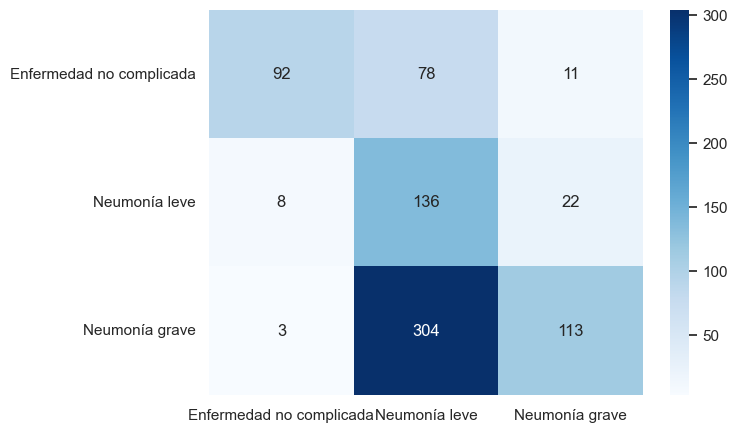

In [490]:
from sklearn.metrics import confusion_matrix

cm_labels = ['Enfermedad no complicada', 'Neumonía leve',  'Neumonía grave'   ]

cm = confusion_matrix(df_kmeans_clusters['y_true'], df_kmeans_clusters['Cluster'])

cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.heatmap(cm_array_df,  annot=True, fmt='g', cmap='Blues' )
plt.show() 

C:\Users\Usuario\anaconda3\envs\CDP_2\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Usuario\anaconda3\envs\CDP_2\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Usuario\anaconda3\envs\CDP_2\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Usuario\anaconda3\envs\CDP_2\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

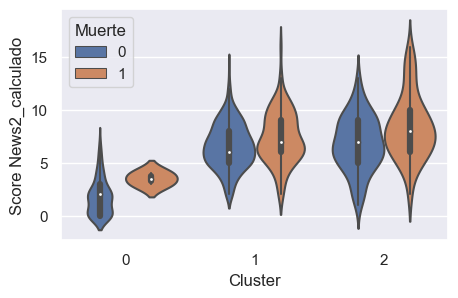

In [491]:
sns.set(rc={'figure.figsize':(5,3)})
sns.violinplot(data = df_kmeans_clusters, x = 'Cluster', y = 'Score News2_calculado', hue = 'Muerte')
plt.show() 

In [492]:
pivot = pd.pivot_table(df_kmeans_clusters, index=['Cluster'], columns='Muerte', aggfunc='size')
pivot2 = pd.pivot_table(df_kmeans_clusters, index=['Gravedad'], columns='Muerte', aggfunc='size')
concat = pd.concat([pivot, pivot2])
concat['%muerte'] = 100*(concat[1]/(concat[1]+concat[0]))
concat

Muerte                      0    1    %muerte
0                         101    2   1.941748
1                         400  118  22.779923
2                          69   77  52.739726
Enfermedad no complicada  179    2   1.104972
Neumonia grave            251  169  40.238095
Neumonia leve             140   26  15.662651

# Depuración adicional de variables

In [493]:
df_1 = df_imputed_multiple.copy()

In [494]:
df_1 = df_1[['CURB-65_calculado', 'Creatinina ingreso', 'Edad (años)', 'FC ingreso',
       'FR ingreso', 'Hb ingreso', 'Hombre', 'Indice de Charlson',
       'Leucocitos ingreso', 'Oxigeno suplementario', 'Plaquetas ingreso',
       'Sat02 ingreso', 'Score News2_calculado', 'T ingreso', 'TAM']]
print(df_1.shape)
df_1.head()

(767, 15)


CURB-65_calculado  Creatinina ingreso  Edad (años)  FC ingreso  FR ingreso  \
0                  2                1.50           52       100.0        36.0   
1                  3                2.09           71        84.0        33.0   
2                  0                1.40           28       114.0        20.0   
3                  0                0.83           40       106.0        18.0   
4                  0                1.03           46        80.0        20.0   

   Hb ingreso  Hombre  Indice de Charlson  Leucocitos ingreso  \
0        14.0       1                   1              7870.0   
1         9.5       0                   3             14330.0   
2        14.9       0                   0              4950.0   
3        11.0       0                   0              6490.0   
4        15.4       1                   0              6750.0   

   Oxigeno suplementario  Plaquetas ingreso  Sat02 ingreso  \
0                      1           144000.0           82.0   
1                      1           424000.0           83.0   
2                      1           145000.0           96.0   
3                      0           399000.0           95.0   
4                      1           152000.0           93.0   

   Score News2_calculado  T ingreso         TAM  
0                      9       36.3  108.666667  
1                      8       36.5  112.666667  
2                      4       38.0  101.000000  
3                      3       36.0  113.666667  
4                      5       38.5   93.333333

In [495]:
scaler = StandardScaler()
scaler.fit(df_1)
X =scaler.transform(df_1)
 
pca = PCA(n_components=0.95)
pca.fit_transform(X)
X_pca = pca.fit_transform(X)

In [496]:
cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
cumulativo = len(cumulative_var_ratio)
cumulativo

12

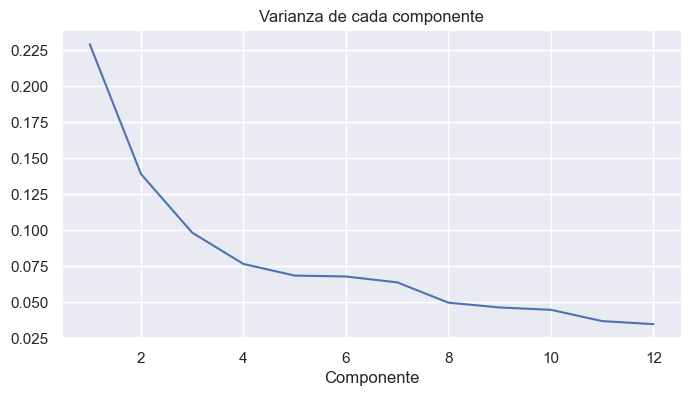

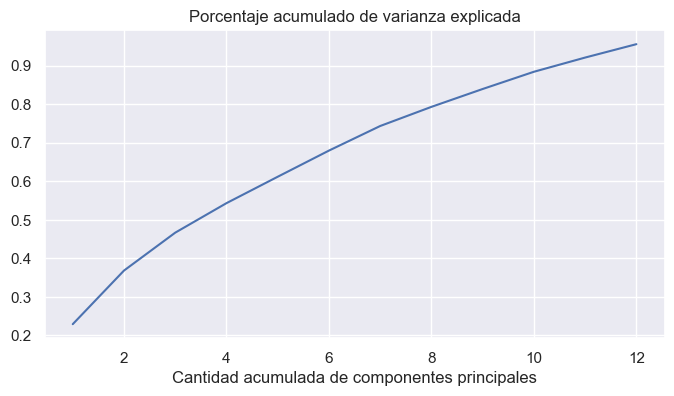

In [497]:
varianzaExplicada=pca.explained_variance_
porcentajeVarianzaExplicada=pca.explained_variance_ratio_
plt.figure(figsize=(8,4))
plt.plot(range(1,cumulativo+1),porcentajeVarianzaExplicada)
plt.xlabel('Componente')
plt.title('Varianza de cada componente')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(range(1,cumulativo+1),np.cumsum(porcentajeVarianzaExplicada)) #acumulado
plt.xlabel('Cantidad acumulada de componentes principales')
plt.title('Porcentaje acumulado de varianza explicada')
plt.show()

In [498]:
from pca import pca
#se seleccionan 9 componentes
model = pca(n_components=9)
X_PCA = model.fit_transform(X)

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [15] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[9]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


In [499]:
loadings = X_PCA['loadings']
loadings.columns = df_1.columns
loadings

CURB-65_calculado  Creatinina ingreso  Edad (años)  FC ingreso  \
PC1           0.403197            0.136535     0.350407    0.164249   
PC2           0.237599            0.148208     0.381807   -0.456739   
PC3           0.018741           -0.097023    -0.097547    0.167301   
PC4           0.221757           -0.063225    -0.107644   -0.022854   
PC5           0.028457            0.833282    -0.270662    0.159272   
PC6           0.133344           -0.107198    -0.077945   -0.222688   
PC7           0.102929            0.172405     0.170866    0.028181   
PC8           0.203700           -0.043137    -0.094519   -0.294762   
PC9          -0.095037            0.206611    -0.144044   -0.230836   

     FR ingreso  Hb ingreso    Hombre  Indice de Charlson  Leucocitos ingreso  \
PC1    0.296579   -0.042659  0.072150            0.332041            0.213616   
PC2   -0.270365   -0.253592 -0.224335            0.441872           -0.151187   
PC3    0.151156   -0.554590 -0.496260           -0.072479            0.308936   
PC4    0.120561   -0.010661  0.037093           -0.010022           -0.020744   
PC5   -0.022607   -0.227053  0.115091           -0.086285            0.090278   
PC6   -0.047205    0.217385  0.313514           -0.114226            0.523421   
PC7   -0.031752    0.096893  0.414935            0.165198            0.280091   
PC8    0.753518   -0.013726  0.116852           -0.035700           -0.298995   
PC9    0.074964   -0.244956  0.163091           -0.137078           -0.189600   

     Oxigeno suplementario  Plaquetas ingreso  Sat02 ingreso  \
PC1               0.332556          -0.095875      -0.330360   
PC2              -0.070377          -0.030707       0.181072   
PC3              -0.114824           0.500794      -0.023512   
PC4              -0.243093          -0.217371       0.092170   
PC5              -0.217197          -0.201899      -0.053029   
PC6               0.050867           0.191842       0.053909   
PC7              -0.208856           0.471569       0.207496   
PC8              -0.306462           0.080933       0.120976   
PC9               0.684844           0.202240       0.403562   

     Score News2_calculado  T ingreso       TAM  
PC1               0.434625   0.018341 -0.000950  
PC2              -0.276286  -0.186358 -0.107736  
PC3               0.037753  -0.015560 -0.095622  
PC4               0.024312   0.475913 -0.759103  
PC5              -0.045681  -0.179410 -0.016622  
PC6              -0.044477  -0.555590 -0.356811  
PC7              -0.197863   0.481664  0.247348  
PC8               0.004505  -0.197210  0.185756  
PC9               0.143769   0.131942 -0.128189

In [500]:
feature_index_to_name = {i+1: column_name for i, column_name in enumerate(df_1.columns)}
top_features = X_PCA['topfeat']
top_features['feature'] = top_features['feature'].astype(int)
top_features['feature'] = top_features['feature'].map(feature_index_to_name)
top_features

PC                feature   loading  type
0   PC1  Score News2_calculado  0.434625  best
1   PC2             FC ingreso -0.456739  best
2   PC3             Hb ingreso -0.554590  best
3   PC4                    TAM -0.759103  best
4   PC5     Creatinina ingreso  0.833282  best
5   PC6              T ingreso -0.555590  best
6   PC7              T ingreso  0.481664  best
7   PC8             FR ingreso  0.753518  best
8   PC9  Oxigeno suplementario  0.684844  best
9   PC1      CURB-65_calculado  0.403197  weak
10  PC2            Edad (años)  0.381807  weak
11  PC3                 Hombre -0.496260  weak
12  PC2     Indice de Charlson  0.441872  weak
13  PC6     Leucocitos ingreso  0.523421  weak
14  PC3      Plaquetas ingreso  0.500794  weak
15  PC9          Sat02 ingreso  0.403562  weak

# DBSCAN

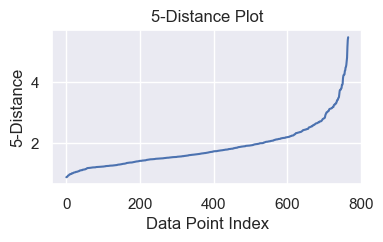

In [501]:
k = 5
X_pca_9 = X_pca[:,:9] #se seleccionan 9 componentes principales
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X_pca_9)

distances, _ = knn.kneighbors(X_pca_9)

sorted_distances = np.sort(distances[:, -1])
plt.figure(figsize=(4,2))
plt.plot(range(len(sorted_distances)), sorted_distances)
plt.xlabel('Data Point Index')
plt.ylabel(f'{k}-Distance')
plt.title(f'{k}-Distance Plot')
plt.grid(True)
plt.show()

In [502]:
i = np.arange(len(distances))
distances = distances[:, -1] 
knee = KneeLocator(i, distances, 
                   S=1, curve='convex', 
                   direction='increasing', 
                   interp_method='polynomial')
epsilon= distances[knee.knee]
print(epsilon)

2.0865628610565787


In [503]:
from sklearn.metrics import silhouette_score
min_samples = range(3,25)
output = []
for ms in min_samples:
        labels = DBSCAN(min_samples=ms, eps = epsilon).fit(X_pca_9).labels_
        score = silhouette_score(X_pca_9, labels)
        output.append((ms, epsilon, score))

min_samples, epsilon, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"Mejor silhouette_score: {score}")
print(f"min_samples: {min_samples}")
print(f"eps: {epsilon}")

Mejor silhouette_score: 0.21144134503595818
min_samples: 4
eps: 2.0865628610565787


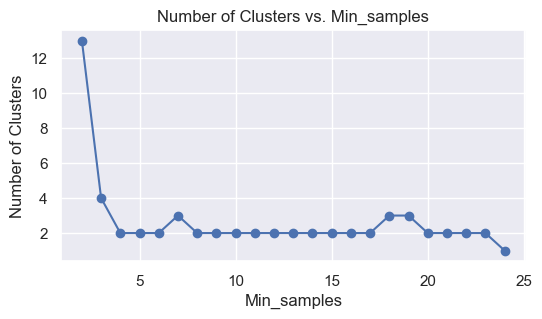

In [504]:
min_samples_values = range(2, 25) 
cluster_counts = []

for min_sample in min_samples_values:
    dbscan = DBSCAN(eps=epsilon, min_samples=min_sample)
    dbscan.fit(X_pca_9)
    unique_labels = np.unique(dbscan.labels_)
    num_clusters = len(unique_labels) - 1 if -1 in unique_labels else len(unique_labels)
    
    cluster_counts.append(num_clusters)

plt.figure(figsize=(6, 3))
plt.plot(min_samples_values, cluster_counts, marker='o', linestyle='-')
plt.title('Number of Clusters vs. Min_samples')
plt.xlabel('Min_samples')
plt.ylabel('Number of Clusters')

plt.show()


In [505]:
eps = epsilon  
min_samples = 10

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters_db = dbscan.fit_predict(X_pca_9)

In [506]:
df_dbscan = df_1.copy()
df_dbscan['Cluster'] = clusters_db
#df_dbscan['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
print(df_dbscan['Cluster'].unique())
df_dbscan
#df_dbscan.to_excel("DBSCAN_3cluster.xlsx", index=False)

[ 0 -1  1]


CURB-65_calculado  Creatinina ingreso  Edad (años)  FC ingreso  \
0                    2                1.50           52       100.0   
1                    3                2.09           71        84.0   
2                    0                1.40           28       114.0   
3                    0                0.83           40       106.0   
4                    0                1.03           46        80.0   
..                 ...                 ...          ...         ...   
769                  1                0.92           70        94.0   
770                  0                0.85           44        84.0   
771                  0                0.67           47       100.0   
772                  1                1.03           65        77.0   
773                  1                0.83           53        92.0   

     FR ingreso  Hb ingreso  Hombre  Indice de Charlson  Leucocitos ingreso  \
0          36.0        14.0       1                   1              7870.0   
1          33.0         9.5       0                   3             14330.0   
2          20.0        14.9       0                   0              4950.0   
3          18.0        11.0       0                   0              6490.0   
4          20.0        15.4       1                   0              6750.0   
..          ...         ...     ...                 ...                 ...   
769        18.0        13.5       0                   3              4860.0   
770        20.0        15.2       1                   0              4460.0   
771        18.0        17.5       1                   2              7660.0   
772        22.0        16.5       1                   3              9680.0   
773        33.0        17.1       1                   1              3420.0   

     Oxigeno suplementario  Plaquetas ingreso  Sat02 ingreso  \
0                        1           144000.0           82.0   
1                        1           424000.0           83.0   
2                        1           145000.0           96.0   
3                        0           399000.0           95.0   
4                        1           152000.0           93.0   
..                     ...                ...            ...   
769                      1           324000.0           90.0   
770                      1           340000.0           80.0   
771                      1           283000.0           85.0   
772                      1           340000.0           83.0   
773                      1           255000.0           90.0   

     Score News2_calculado  T ingreso         TAM  Cluster  
0                        9       36.3  108.666667        0  
1                        8       36.5  112.666667       -1  
2                        4       38.0  101.000000        0  
3                        3       36.0  113.666667        1  
4                        5       38.5   93.333333        0  
..                     ...        ...         ...      ...  
769                      6       36.5  109.666667        0  
770                      5       36.8   94.666667        0  
771                      7       36.0   93.333333        0  
772                      7       37.0  105.333333        0  
773                      9       36.8   94.666667        0  

[767 rows x 16 columns]

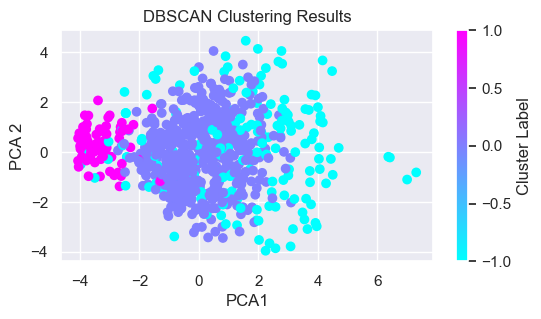

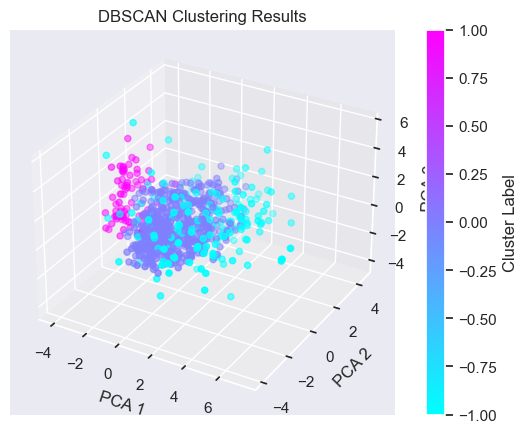

In [507]:
plt.figure(figsize=(6, 3))
plt.scatter(X_pca_9[:, 0], X_pca_9[:, 1], c=clusters_db, cmap='cool')  
plt.title('DBSCAN Clustering Results')
plt.xlabel('PCA1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_9[:, 0], X_pca_9[:, 1], X_pca_9[:, 2], c=clusters_db, cmap='cool')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('DBSCAN Clustering Results')

legend = plt.colorbar(scatter, ax=ax)
legend.set_label('Cluster Label')

plt.show();

In [508]:
df_dbscan.groupby('Cluster').agg(['mean']).T

Cluster                                -1              0              1
CURB-65_calculado     mean       1.677019       0.727444       0.094595
Creatinina ingreso    mean       2.164161       0.963628       0.838243
Edad (años)           mean      63.795031      57.419173      37.337838
FC ingreso            mean      99.006211      93.131579      86.662162
FR ingreso            mean      25.503106      20.915414      18.554054
Hb ingreso            mean      13.332112      14.481955      13.910811
Hombre                mean       0.596273       0.644737       0.472973
Indice de Charlson    mean       3.236025       1.870301       0.337838
Leucocitos ingreso    mean   11500.248447    9299.080827    7427.702703
Oxigeno suplementario mean       0.832298       1.000000       0.000000
Plaquetas ingreso     mean  262080.124224  260242.293233  303297.297297
Sat02 ingreso         mean      82.981366      87.767857      95.256757
Score News2_calculado mean       7.925466       6.434211       1.405405
T ingreso             mean      36.963975      36.620489      36.616216
TAM                   mean      91.792961      94.025689      88.351351

In [509]:
df_dbscan['UCI'] = df_imputed_multiple['Ingreso a UCI']
df_dbscan['Muerte'] = df_imputed_multiple['Muerto_si_no']
df_dbscan.groupby('Cluster' ).agg(['mean']).T

Cluster                                -1              0              1
CURB-65_calculado     mean       1.677019       0.727444       0.094595
Creatinina ingreso    mean       2.164161       0.963628       0.838243
Edad (años)           mean      63.795031      57.419173      37.337838
FC ingreso            mean      99.006211      93.131579      86.662162
FR ingreso            mean      25.503106      20.915414      18.554054
Hb ingreso            mean      13.332112      14.481955      13.910811
Hombre                mean       0.596273       0.644737       0.472973
Indice de Charlson    mean       3.236025       1.870301       0.337838
Leucocitos ingreso    mean   11500.248447    9299.080827    7427.702703
Oxigeno suplementario mean       0.832298       1.000000       0.000000
Plaquetas ingreso     mean  262080.124224  260242.293233  303297.297297
Sat02 ingreso         mean      82.981366      87.767857      95.256757
Score News2_calculado mean       7.925466       6.434211       1.405405
T ingreso             mean      36.963975      36.620489      36.616216
TAM                   mean      91.792961      94.025689      88.351351
UCI                   mean       0.459627       0.325188       0.000000
Muerte                mean       0.428571       0.240602       0.000000

In [510]:
df_dbscan['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
df_dbscan.groupby('Gravedad' ).agg(['mean']).T

Gravedad                    Enfermedad no complicada  Neumonia grave  \
CURB-65_calculado     mean                  0.375691        1.133333   
Creatinina ingreso    mean                  1.017624        1.333667   
Edad (años)           mean                 47.453039       60.942857   
FC ingreso            mean                 88.745856       97.378571   
FR ingreso            mean                 19.646409       23.040476   
Hb ingreso            mean                 14.133315       14.150238   
Hombre                mean                  0.574586        0.652381   
Indice de Charlson    mean                  1.116022        2.428571   
Leucocitos ingreso    mean               7942.756906    10627.878571   
Oxigeno suplementario mean                  0.480663        0.992857   
Plaquetas ingreso     mean             279723.756906   256637.142857   
Sat02 ingreso         mean                 94.182320       82.458333   
Score News2_calculado mean                  3.662983        7.714286   
T ingreso             mean                 36.718785       36.713810   
TAM                   mean                 91.263352       93.792063   
Cluster               mean                  0.232044       -0.276190   
UCI                   mean                  0.016575        0.523810   
Muerte                mean                  0.011050        0.402381   

Gravedad                    Neumonia leve  
CURB-65_calculado     mean       0.722892  
Creatinina ingreso    mean       1.076988  
Edad (años)           mean      56.602410  
FC ingreso            mean      89.981928  
FR ingreso            mean      20.319277  
Hb ingreso            mean      14.331566  
Hombre                mean       0.578313  
Indice de Charlson    mean       1.921687  
Leucocitos ingreso    mean    8716.584337  
Oxigeno suplementario mean       0.975904  
Plaquetas ingreso     mean  269097.590361  
Sat02 ingreso         mean      92.903614  
Score News2_calculado mean       5.421687  
T ingreso             mean      36.608434  
TAM                   mean      92.933735  
Cluster               mean      -0.078313  
UCI                   mean       0.144578  
Muerte                mean       0.156627

In [511]:

#los números de recodificación deben coincidir con las características de los clúster. Esto se hace verificando las métricas de cada clúster
df_dbscan['y_true'] = df_dbscan['Gravedad'].map({'Neumonia grave':-1, 
                                                 'Enfermedad no complicada': 1,
                                                 'Neumonia leve':0})
df_dbscan.head()

#df_kmeans_clusters.to_excel("kmeans_matrix.xlsx", index=False)

CURB-65_calculado  Creatinina ingreso  Edad (años)  FC ingreso  FR ingreso  \
0                  2                1.50           52       100.0        36.0   
1                  3                2.09           71        84.0        33.0   
2                  0                1.40           28       114.0        20.0   
3                  0                0.83           40       106.0        18.0   
4                  0                1.03           46        80.0        20.0   

   Hb ingreso  Hombre  Indice de Charlson  Leucocitos ingreso  \
0        14.0       1                   1              7870.0   
1         9.5       0                   3             14330.0   
2        14.9       0                   0              4950.0   
3        11.0       0                   0              6490.0   
4        15.4       1                   0              6750.0   

   Oxigeno suplementario  Plaquetas ingreso  Sat02 ingreso  \
0                      1           144000.0           82.0   
1                      1           424000.0           83.0   
2                      1           145000.0           96.0   
3                      0           399000.0           95.0   
4                      1           152000.0           93.0   

   Score News2_calculado  T ingreso         TAM  Cluster  UCI  Muerte  \
0                      9       36.3  108.666667        0    1       0   
1                      8       36.5  112.666667       -1    1       1   
2                      4       38.0  101.000000        0    0       0   
3                      3       36.0  113.666667        1    0       0   
4                      5       38.5   93.333333        0    0       0   

                   Gravedad  y_true  
0            Neumonia grave      -1  
1            Neumonia grave      -1  
2  Enfermedad no complicada       1  
3  Enfermedad no complicada       1  
4             Neumonia leve       0

In [512]:
from sklearn.metrics import adjusted_rand_score
y_true = df_dbscan['y_true']
y_pred = df_dbscan['Cluster']

ari_score = adjusted_rand_score(y_true, y_pred)

print(f"ARI Score: {ari_score}")

ARI Score: 0.09060816420455145


In [513]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [514]:
from scipy.optimize import linear_sum_assignment as linear_assignment
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(w.max() - w)
accu = sum([w[i, j] for i, j in zip(ind[0],ind[1])]) * 1.0 / y_pred.size
print("El accuracy es:", accu)

El accuracy es: 0.516297262059974


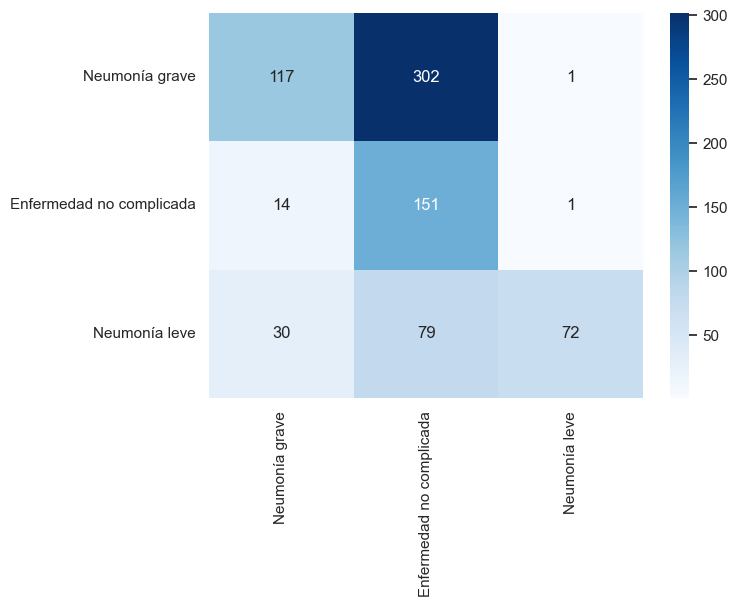

In [515]:
from sklearn.metrics import confusion_matrix

#los labels se deben colocar en el orden de los cluster (número). Acá en DBSCAN por ejemplo el primero es -1
cm_labels = ['Neumonía grave', 'Enfermedad no complicada', 'Neumonía leve' ]

cm = confusion_matrix(df_dbscan['y_true'], df_dbscan['Cluster'])

cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.heatmap(cm_array_df,  annot=True, fmt='g', cmap='Blues' )
plt.show() 

In [516]:
pivot = pd.pivot_table(df_dbscan, index=['Cluster'], columns='Muerte', aggfunc='size')
pivot2 = pd.pivot_table(df_dbscan, index=['Gravedad'], columns='Muerte', aggfunc='size')
concat = pd.concat([pivot, pivot2])
concat['%muerte'] = 100*(concat[1]/(concat[1]+concat[0]))
concat

Muerte                        0      1    %muerte
-1                         92.0   69.0  42.857143
0                         404.0  128.0  24.060150
1                          74.0    NaN        NaN
Enfermedad no complicada  179.0    2.0   1.104972
Neumonia grave            251.0  169.0  40.238095
Neumonia leve             140.0   26.0  15.662651

## Hierachical clustering

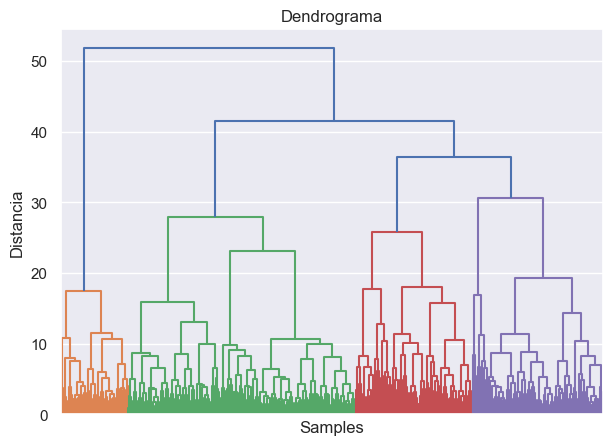

In [517]:
linkage_matrix = sch.linkage(X_pca_9, method='ward')
dendrogram = sch.dendrogram(linkage_matrix, truncate_mode = 'level', 
           show_leaf_counts = False, 
           no_labels = True)

plt.title('Dendrograma')
plt.xlabel('Samples')
plt.ylabel('Distancia')
plt.show();


In [518]:
num_clusters = 3
cluster_hierarchical= fcluster(linkage_matrix, num_clusters, criterion='maxclust')

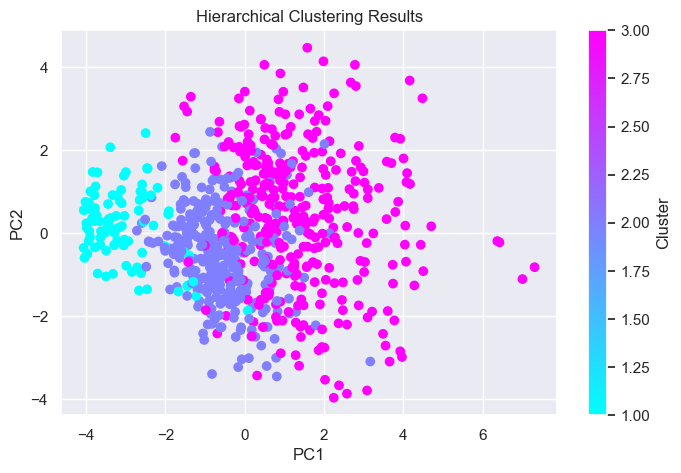

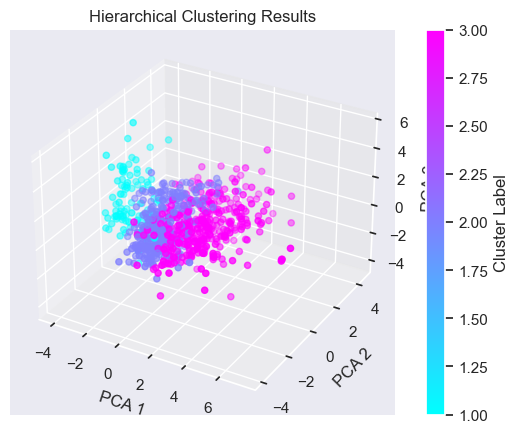

In [519]:
fig = plt.figure(figsize=(8,5))
plt.scatter(X_pca_9[:, 0], X_pca_9[:, 1], c=cluster_hierarchical, cmap='cool')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Hierarchical Clustering Results')
plt.colorbar(label='Cluster')
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_9[:, 0], X_pca_9[:, 1], X_pca_9[:, 2], c=cluster_hierarchical, cmap='cool')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('Hierarchical Clustering Results')

legend = plt.colorbar(scatter, ax=ax)
legend.set_label('Cluster Label')

plt.show()

In [520]:
df_hierarchical_clusters = df_1.copy()
df_hierarchical_clusters['Cluster'] = cluster_hierarchical
#df_hierarchical_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
print(df_hierarchical_clusters['Cluster'].unique())
df_hierarchical_clusters
#df_hierarchical_clusters.to_excel("hierarchichal_4_cluster.xlsx", index=False)

[3 2 1]


CURB-65_calculado  Creatinina ingreso  Edad (años)  FC ingreso  \
0                    2                1.50           52       100.0   
1                    3                2.09           71        84.0   
2                    0                1.40           28       114.0   
3                    0                0.83           40       106.0   
4                    0                1.03           46        80.0   
..                 ...                 ...          ...         ...   
769                  1                0.92           70        94.0   
770                  0                0.85           44        84.0   
771                  0                0.67           47       100.0   
772                  1                1.03           65        77.0   
773                  1                0.83           53        92.0   

     FR ingreso  Hb ingreso  Hombre  Indice de Charlson  Leucocitos ingreso  \
0          36.0        14.0       1                   1              7870.0   
1          33.0         9.5       0                   3             14330.0   
2          20.0        14.9       0                   0              4950.0   
3          18.0        11.0       0                   0              6490.0   
4          20.0        15.4       1                   0              6750.0   
..          ...         ...     ...                 ...                 ...   
769        18.0        13.5       0                   3              4860.0   
770        20.0        15.2       1                   0              4460.0   
771        18.0        17.5       1                   2              7660.0   
772        22.0        16.5       1                   3              9680.0   
773        33.0        17.1       1                   1              3420.0   

     Oxigeno suplementario  Plaquetas ingreso  Sat02 ingreso  \
0                        1           144000.0           82.0   
1                        1           424000.0           83.0   
2                        1           145000.0           96.0   
3                        0           399000.0           95.0   
4                        1           152000.0           93.0   
..                     ...                ...            ...   
769                      1           324000.0           90.0   
770                      1           340000.0           80.0   
771                      1           283000.0           85.0   
772                      1           340000.0           83.0   
773                      1           255000.0           90.0   

     Score News2_calculado  T ingreso         TAM  Cluster  
0                        9       36.3  108.666667        3  
1                        8       36.5  112.666667        3  
2                        4       38.0  101.000000        2  
3                        3       36.0  113.666667        1  
4                        5       38.5   93.333333        2  
..                     ...        ...         ...      ...  
769                      6       36.5  109.666667        3  
770                      5       36.8   94.666667        2  
771                      7       36.0   93.333333        2  
772                      7       37.0  105.333333        3  
773                      9       36.8   94.666667        3  

[767 rows x 16 columns]

In [521]:
df_hierarchical_clusters.groupby('Cluster').agg(['mean']).T

Cluster                                 1              2              3
CURB-65_calculado     mean       0.115789       0.354037       1.540000
Creatinina ingreso    mean       0.856842       0.880000       1.595286
Edad (años)           mean      39.663158      50.145963      67.617143
FC ingreso            mean      88.642105      94.736025      94.208571
FR ingreso            mean      18.821053      20.639752      23.348571
Hb ingreso            mean      14.056947      14.401801      14.021371
Hombre                mean       0.494737       0.599379       0.668571
Indice de Charlson    mean       0.536842       1.003106       3.334286
Leucocitos ingreso    mean    7562.105263    9239.500000   10442.234286
Oxigeno suplementario mean       0.010526       1.000000       0.980000
Plaquetas ingreso     mean  307600.000000  263256.211180  254563.714286
Sat02 ingreso         mean      94.842105      89.113354      83.991429
Score News2_calculado mean       1.852632       6.270186       7.451429
T ingreso             mean      36.806316      36.726708      36.629429
TAM                   mean      89.473684      92.140787      94.768571

In [522]:
df_hierarchical_clusters['UCI'] = df_imputed_multiple['Ingreso a UCI']
df_hierarchical_clusters['Muerte'] = df_imputed_multiple['Muerto_si_no']
df_hierarchical_clusters.groupby('Cluster' ).agg(['mean']).T

Cluster                                 1              2              3
CURB-65_calculado     mean       0.115789       0.354037       1.540000
Creatinina ingreso    mean       0.856842       0.880000       1.595286
Edad (años)           mean      39.663158      50.145963      67.617143
FC ingreso            mean      88.642105      94.736025      94.208571
FR ingreso            mean      18.821053      20.639752      23.348571
Hb ingreso            mean      14.056947      14.401801      14.021371
Hombre                mean       0.494737       0.599379       0.668571
Indice de Charlson    mean       0.536842       1.003106       3.334286
Leucocitos ingreso    mean    7562.105263    9239.500000   10442.234286
Oxigeno suplementario mean       0.010526       1.000000       0.980000
Plaquetas ingreso     mean  307600.000000  263256.211180  254563.714286
Sat02 ingreso         mean      94.842105      89.113354      83.991429
Score News2_calculado mean       1.852632       6.270186       7.451429
T ingreso             mean      36.806316      36.726708      36.629429
TAM                   mean      89.473684      92.140787      94.768571
UCI                   mean       0.000000       0.245342       0.480000
Muerte                mean       0.000000       0.145963       0.428571

In [523]:
df_hierarchical_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
df_hierarchical_clusters.groupby('Gravedad' ).agg(['mean']).T

Gravedad                    Enfermedad no complicada  Neumonia grave  \
CURB-65_calculado     mean                  0.375691        1.133333   
Creatinina ingreso    mean                  1.017624        1.333667   
Edad (años)           mean                 47.453039       60.942857   
FC ingreso            mean                 88.745856       97.378571   
FR ingreso            mean                 19.646409       23.040476   
Hb ingreso            mean                 14.133315       14.150238   
Hombre                mean                  0.574586        0.652381   
Indice de Charlson    mean                  1.116022        2.428571   
Leucocitos ingreso    mean               7942.756906    10627.878571   
Oxigeno suplementario mean                  0.480663        0.992857   
Plaquetas ingreso     mean             279723.756906   256637.142857   
Sat02 ingreso         mean                 94.182320       82.458333   
Score News2_calculado mean                  3.662983        7.714286   
T ingreso             mean                 36.718785       36.713810   
TAM                   mean                 91.263352       93.792063   
Cluster               mean                  1.696133        2.590476   
UCI                   mean                  0.016575        0.523810   
Muerte                mean                  0.011050        0.402381   

Gravedad                    Neumonia leve  
CURB-65_calculado     mean       0.722892  
Creatinina ingreso    mean       1.076988  
Edad (años)           mean      56.602410  
FC ingreso            mean      89.981928  
FR ingreso            mean      20.319277  
Hb ingreso            mean      14.331566  
Hombre                mean       0.578313  
Indice de Charlson    mean       1.921687  
Leucocitos ingreso    mean    8716.584337  
Oxigeno suplementario mean       0.975904  
Plaquetas ingreso     mean  269097.590361  
Sat02 ingreso         mean      92.903614  
Score News2_calculado mean       5.421687  
T ingreso             mean      36.608434  
TAM                   mean      92.933735  
Cluster               mean       2.373494  
UCI                   mean       0.144578  
Muerte                mean       0.156627

In [524]:
#los números de recodificación deben coincidir con las características de los clúster. Esto se hace verificando las métricas de cada clúster
df_hierarchical_clusters['y_true'] = df_hierarchical_clusters['Gravedad'].map({'Neumonia grave':3, 
                                                 'Enfermedad no complicada': 1,
                                                 'Neumonia leve':2})
df_hierarchical_clusters.head()

#df_kmeans_clusters.to_excel("kmeans_matrix.xlsx", index=False)

CURB-65_calculado  Creatinina ingreso  Edad (años)  FC ingreso  FR ingreso  \
0                  2                1.50           52       100.0        36.0   
1                  3                2.09           71        84.0        33.0   
2                  0                1.40           28       114.0        20.0   
3                  0                0.83           40       106.0        18.0   
4                  0                1.03           46        80.0        20.0   

   Hb ingreso  Hombre  Indice de Charlson  Leucocitos ingreso  \
0        14.0       1                   1              7870.0   
1         9.5       0                   3             14330.0   
2        14.9       0                   0              4950.0   
3        11.0       0                   0              6490.0   
4        15.4       1                   0              6750.0   

   Oxigeno suplementario  Plaquetas ingreso  Sat02 ingreso  \
0                      1           144000.0           82.0   
1                      1           424000.0           83.0   
2                      1           145000.0           96.0   
3                      0           399000.0           95.0   
4                      1           152000.0           93.0   

   Score News2_calculado  T ingreso         TAM  Cluster  UCI  Muerte  \
0                      9       36.3  108.666667        3    1       0   
1                      8       36.5  112.666667        3    1       1   
2                      4       38.0  101.000000        2    0       0   
3                      3       36.0  113.666667        1    0       0   
4                      5       38.5   93.333333        2    0       0   

                   Gravedad  y_true  
0            Neumonia grave       3  
1            Neumonia grave       3  
2  Enfermedad no complicada       1  
3  Enfermedad no complicada       1  
4             Neumonia leve       2

In [525]:
from sklearn.metrics import adjusted_rand_score
y_true = df_hierarchical_clusters['y_true']
y_pred = df_hierarchical_clusters['Cluster']

ari_score = adjusted_rand_score(y_true, y_pred)

print(f"ARI Score: {ari_score}")

ARI Score: 0.15362358661921433


In [526]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [527]:
from scipy.optimize import linear_sum_assignment as linear_assignment
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(w.max() - w)
accu = sum([w[i, j] for i, j in zip(ind[0],ind[1])]) * 1.0 / y_pred.size
print("El accuracy es:", accu)

El accuracy es: 0.5671447196870926


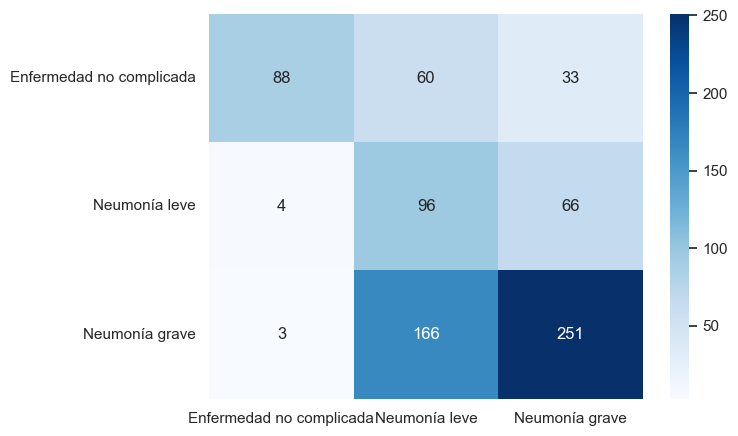

In [528]:
from sklearn.metrics import confusion_matrix

#los labels se deben colocar en el orden de los cluster (número). 
cm_labels = ['Enfermedad no complicada', 'Neumonía leve', 'Neumonía grave'  ]

cm = confusion_matrix(df_hierarchical_clusters['y_true'], df_hierarchical_clusters['Cluster'])

cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.heatmap(cm_array_df,  annot=True, fmt='g', cmap='Blues' )
plt.show() 

In [529]:
#df_hierarchical_clusters.to_excel("hierarchichal_final.xlsx", index=False)

In [530]:
pivot = pd.pivot_table(df_hierarchical_clusters, index=['Cluster'], columns='Muerte', aggfunc='size')
pivot2 = pd.pivot_table(df_hierarchical_clusters, index=['Gravedad'], columns='Muerte', aggfunc='size')
concat = pd.concat([pivot, pivot2])
concat['%muerte'] = 100*(concat[1]/(concat[1]+concat[0]))
concat

Muerte                        0      1    %muerte
1                          95.0    NaN        NaN
2                         275.0   47.0  14.596273
3                         200.0  150.0  42.857143
Enfermedad no complicada  179.0    2.0   1.104972
Neumonia grave            251.0  169.0  40.238095
Neumonia leve             140.0   26.0  15.662651

## Agglomerative clustering

In [531]:
num_clusters = 3 # ajustar!
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
cluster_agglomerative = agg_clustering.fit_predict(X_pca_9)

C:\Users\Usuario\anaconda3\envs\CDP_2\Lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


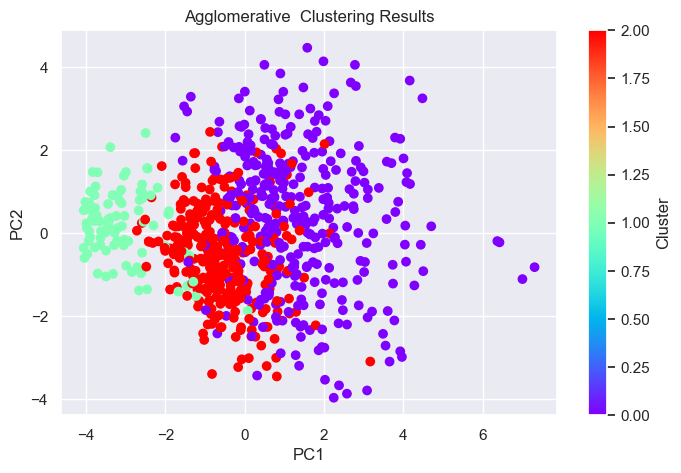

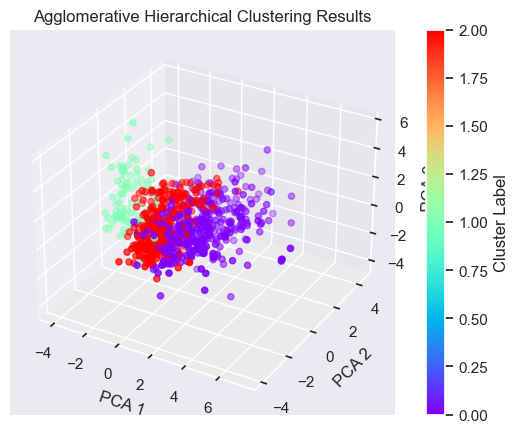

In [532]:
fig = plt.figure(figsize=(8,5))
plt.scatter(X_pca_9[:, 0], X_pca_9[:, 1], c=cluster_agglomerative, cmap='rainbow')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative  Clustering Results')
plt.colorbar(label='Cluster')
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_9[:, 0], X_pca_9[:, 1], X_pca_9[:, 2], c=cluster_agglomerative, cmap='rainbow')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('Agglomerative Hierarchical Clustering Results')

legend = plt.colorbar(scatter, ax=ax)
legend.set_label('Cluster Label')

plt.show()

In [533]:
df_agglomerative_clusters = df_1.copy()
df_agglomerative_clusters['Cluster'] = cluster_agglomerative
#df_agglomerative_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
print(df_agglomerative_clusters['Cluster'].unique())
df_agglomerative_clusters
#df_hierarchical_clusters.to_excel("agglomerative_4.xlsx", index=False)

[0 2 1]


CURB-65_calculado  Creatinina ingreso  Edad (años)  FC ingreso  \
0                    2                1.50           52       100.0   
1                    3                2.09           71        84.0   
2                    0                1.40           28       114.0   
3                    0                0.83           40       106.0   
4                    0                1.03           46        80.0   
..                 ...                 ...          ...         ...   
769                  1                0.92           70        94.0   
770                  0                0.85           44        84.0   
771                  0                0.67           47       100.0   
772                  1                1.03           65        77.0   
773                  1                0.83           53        92.0   

     FR ingreso  Hb ingreso  Hombre  Indice de Charlson  Leucocitos ingreso  \
0          36.0        14.0       1                   1              7870.0   
1          33.0         9.5       0                   3             14330.0   
2          20.0        14.9       0                   0              4950.0   
3          18.0        11.0       0                   0              6490.0   
4          20.0        15.4       1                   0              6750.0   
..          ...         ...     ...                 ...                 ...   
769        18.0        13.5       0                   3              4860.0   
770        20.0        15.2       1                   0              4460.0   
771        18.0        17.5       1                   2              7660.0   
772        22.0        16.5       1                   3              9680.0   
773        33.0        17.1       1                   1              3420.0   

     Oxigeno suplementario  Plaquetas ingreso  Sat02 ingreso  \
0                        1           144000.0           82.0   
1                        1           424000.0           83.0   
2                        1           145000.0           96.0   
3                        0           399000.0           95.0   
4                        1           152000.0           93.0   
..                     ...                ...            ...   
769                      1           324000.0           90.0   
770                      1           340000.0           80.0   
771                      1           283000.0           85.0   
772                      1           340000.0           83.0   
773                      1           255000.0           90.0   

     Score News2_calculado  T ingreso         TAM  Cluster  
0                        9       36.3  108.666667        0  
1                        8       36.5  112.666667        0  
2                        4       38.0  101.000000        2  
3                        3       36.0  113.666667        1  
4                        5       38.5   93.333333        2  
..                     ...        ...         ...      ...  
769                      6       36.5  109.666667        0  
770                      5       36.8   94.666667        2  
771                      7       36.0   93.333333        2  
772                      7       37.0  105.333333        0  
773                      9       36.8   94.666667        0  

[767 rows x 16 columns]

In [534]:
df_agglomerative_clusters.groupby('Cluster').agg(['mean']).T

Cluster                                 0              1              2
CURB-65_calculado     mean       1.540000       0.115789       0.354037
Creatinina ingreso    mean       1.595286       0.856842       0.880000
Edad (años)           mean      67.617143      39.663158      50.145963
FC ingreso            mean      94.208571      88.642105      94.736025
FR ingreso            mean      23.348571      18.821053      20.639752
Hb ingreso            mean      14.021371      14.056947      14.401801
Hombre                mean       0.668571       0.494737       0.599379
Indice de Charlson    mean       3.334286       0.536842       1.003106
Leucocitos ingreso    mean   10442.234286    7562.105263    9239.500000
Oxigeno suplementario mean       0.980000       0.010526       1.000000
Plaquetas ingreso     mean  254563.714286  307600.000000  263256.211180
Sat02 ingreso         mean      83.991429      94.842105      89.113354
Score News2_calculado mean       7.451429       1.852632       6.270186
T ingreso             mean      36.629429      36.806316      36.726708
TAM                   mean      94.768571      89.473684      92.140787

In [535]:
df_agglomerative_clusters['UCI'] = df_imputed_multiple['Ingreso a UCI']
df_agglomerative_clusters['Muerte'] = df_imputed_multiple['Muerto_si_no']
df_agglomerative_clusters.groupby('Cluster' ).agg(['mean']).T

Cluster                                 0              1              2
CURB-65_calculado     mean       1.540000       0.115789       0.354037
Creatinina ingreso    mean       1.595286       0.856842       0.880000
Edad (años)           mean      67.617143      39.663158      50.145963
FC ingreso            mean      94.208571      88.642105      94.736025
FR ingreso            mean      23.348571      18.821053      20.639752
Hb ingreso            mean      14.021371      14.056947      14.401801
Hombre                mean       0.668571       0.494737       0.599379
Indice de Charlson    mean       3.334286       0.536842       1.003106
Leucocitos ingreso    mean   10442.234286    7562.105263    9239.500000
Oxigeno suplementario mean       0.980000       0.010526       1.000000
Plaquetas ingreso     mean  254563.714286  307600.000000  263256.211180
Sat02 ingreso         mean      83.991429      94.842105      89.113354
Score News2_calculado mean       7.451429       1.852632       6.270186
T ingreso             mean      36.629429      36.806316      36.726708
TAM                   mean      94.768571      89.473684      92.140787
UCI                   mean       0.480000       0.000000       0.245342
Muerte                mean       0.428571       0.000000       0.145963

In [536]:
df_agglomerative_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
df_agglomerative_clusters.groupby('Gravedad' ).agg(['mean']).T

Gravedad                    Enfermedad no complicada  Neumonia grave  \
CURB-65_calculado     mean                  0.375691        1.133333   
Creatinina ingreso    mean                  1.017624        1.333667   
Edad (años)           mean                 47.453039       60.942857   
FC ingreso            mean                 88.745856       97.378571   
FR ingreso            mean                 19.646409       23.040476   
Hb ingreso            mean                 14.133315       14.150238   
Hombre                mean                  0.574586        0.652381   
Indice de Charlson    mean                  1.116022        2.428571   
Leucocitos ingreso    mean               7942.756906    10627.878571   
Oxigeno suplementario mean                  0.480663        0.992857   
Plaquetas ingreso     mean             279723.756906   256637.142857   
Sat02 ingreso         mean                 94.182320       82.458333   
Score News2_calculado mean                  3.662983        7.714286   
T ingreso             mean                 36.718785       36.713810   
TAM                   mean                 91.263352       93.792063   
Cluster               mean                  1.149171        0.797619   
UCI                   mean                  0.016575        0.523810   
Muerte                mean                  0.011050        0.402381   

Gravedad                    Neumonia leve  
CURB-65_calculado     mean       0.722892  
Creatinina ingreso    mean       1.076988  
Edad (años)           mean      56.602410  
FC ingreso            mean      89.981928  
FR ingreso            mean      20.319277  
Hb ingreso            mean      14.331566  
Hombre                mean       0.578313  
Indice de Charlson    mean       1.921687  
Leucocitos ingreso    mean    8716.584337  
Oxigeno suplementario mean       0.975904  
Plaquetas ingreso     mean  269097.590361  
Sat02 ingreso         mean      92.903614  
Score News2_calculado mean       5.421687  
T ingreso             mean      36.608434  
TAM                   mean      92.933735  
Cluster               mean       1.180723  
UCI                   mean       0.144578  
Muerte                mean       0.156627

In [537]:
#los números de recodificación deben coincidir con las características de los clúster. Esto se hace verificando las métricas de cada clúster
df_agglomerative_clusters['y_true'] = df_agglomerative_clusters['Gravedad'].map({'Neumonia grave':0, 
                                                 'Enfermedad no complicada': 1,
                                                 'Neumonia leve':2})
df_agglomerative_clusters.head()

#df_kmeans_clusters.to_excel("kmeans_matrix.xlsx", index=False)

CURB-65_calculado  Creatinina ingreso  Edad (años)  FC ingreso  FR ingreso  \
0                  2                1.50           52       100.0        36.0   
1                  3                2.09           71        84.0        33.0   
2                  0                1.40           28       114.0        20.0   
3                  0                0.83           40       106.0        18.0   
4                  0                1.03           46        80.0        20.0   

   Hb ingreso  Hombre  Indice de Charlson  Leucocitos ingreso  \
0        14.0       1                   1              7870.0   
1         9.5       0                   3             14330.0   
2        14.9       0                   0              4950.0   
3        11.0       0                   0              6490.0   
4        15.4       1                   0              6750.0   

   Oxigeno suplementario  Plaquetas ingreso  Sat02 ingreso  \
0                      1           144000.0           82.0   
1                      1           424000.0           83.0   
2                      1           145000.0           96.0   
3                      0           399000.0           95.0   
4                      1           152000.0           93.0   

   Score News2_calculado  T ingreso         TAM  Cluster  UCI  Muerte  \
0                      9       36.3  108.666667        0    1       0   
1                      8       36.5  112.666667        0    1       1   
2                      4       38.0  101.000000        2    0       0   
3                      3       36.0  113.666667        1    0       0   
4                      5       38.5   93.333333        2    0       0   

                   Gravedad  y_true  
0            Neumonia grave       0  
1            Neumonia grave       0  
2  Enfermedad no complicada       1  
3  Enfermedad no complicada       1  
4             Neumonia leve       2

In [538]:
from sklearn.metrics import adjusted_rand_score
y_true = df_agglomerative_clusters['y_true']
y_pred = df_agglomerative_clusters['Cluster']

ari_score = adjusted_rand_score(y_true, y_pred)

print(f"ARI Score: {ari_score}")

ARI Score: 0.15362358661921433


In [539]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [540]:
from scipy.optimize import linear_sum_assignment as linear_assignment
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(w.max() - w)
accu = sum([w[i, j] for i, j in zip(ind[0],ind[1])]) * 1.0 / y_pred.size
print("El accuracy es:", accu)

El accuracy es: 0.5671447196870926


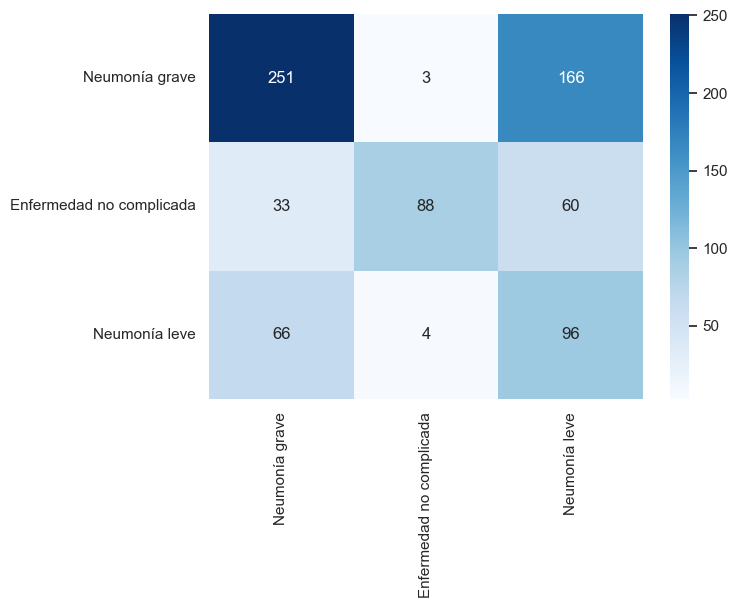

In [541]:
from sklearn.metrics import confusion_matrix

#los labels se deben colocar en el orden de los cluster (número). 
cm_labels = ['Neumonía grave', 'Enfermedad no complicada', 'Neumonía leve'  ]

cm = confusion_matrix(df_agglomerative_clusters['y_true'], df_agglomerative_clusters['Cluster'])

cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.heatmap(cm_array_df,  annot=True, fmt='g', cmap='Blues' )
plt.show() 

In [542]:
#df_agglomerative_clusters.to_excel("df_agglomerative_clusters.xlsx", index=False)

In [543]:
pivot = pd.pivot_table(df_agglomerative_clusters, index=['Cluster'], columns='Muerte', aggfunc='size')
pivot2 = pd.pivot_table(df_agglomerative_clusters, index=['Gravedad'], columns='Muerte', aggfunc='size')
concat = pd.concat([pivot, pivot2])
concat['%muerte'] = 100*(concat[1]/(concat[1]+concat[0]))
concat

Muerte                        0      1    %muerte
0                         200.0  150.0  42.857143
1                          95.0    NaN        NaN
2                         275.0   47.0  14.596273
Enfermedad no complicada  179.0    2.0   1.104972
Neumonia grave            251.0  169.0  40.238095
Neumonia leve             140.0   26.0  15.662651

# K-medoides

In [544]:
from sklearn_extra.cluster import KMedoids
num_clusters = 3  # ajustar!
kmedoids = KMedoids(n_clusters=num_clusters, metric='euclidean', random_state=0)

cluster_kmedoids = kmedoids.fit_predict(X_pca_9)

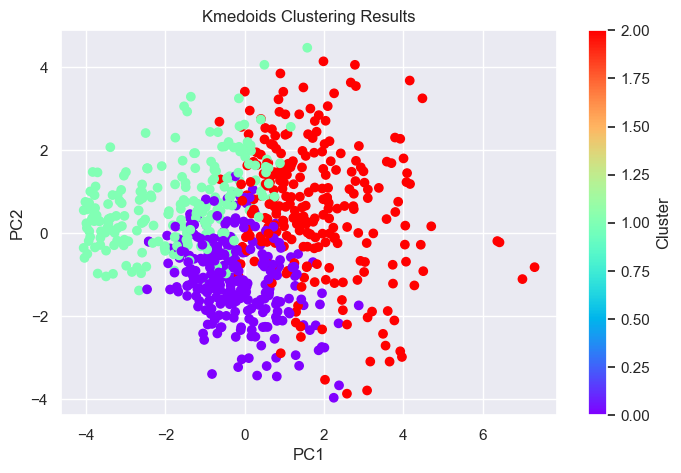

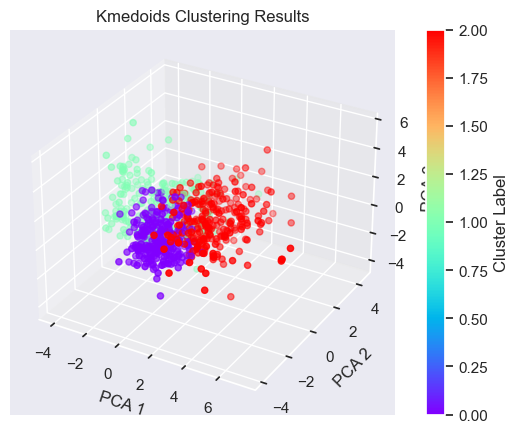

In [545]:
fig = plt.figure(figsize=(8,5))
plt.scatter(X_pca_9[:, 0], X_pca_9[:, 1], c=cluster_kmedoids, cmap='rainbow')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Kmedoids Clustering Results')
plt.colorbar(label='Cluster')
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_9[:, 0], X_pca_9[:, 1], X_pca_9[:, 2], c=cluster_kmedoids, cmap='rainbow')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('Kmedoids Clustering Results')

legend = plt.colorbar(scatter, ax=ax)
legend.set_label('Cluster Label')

plt.show()

In [546]:
df_kmedoids_clusters = df_1.copy()
df_kmedoids_clusters['Cluster'] = cluster_kmedoids
#df_kmedoids_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
print(df_kmedoids_clusters['Cluster'].unique())
df_kmedoids_clusters
#df_kmedoids_clusters.to_excel("kmedoids_4.xlsx", index=False)

[0 2 1]


CURB-65_calculado  Creatinina ingreso  Edad (años)  FC ingreso  \
0                    2                1.50           52       100.0   
1                    3                2.09           71        84.0   
2                    0                1.40           28       114.0   
3                    0                0.83           40       106.0   
4                    0                1.03           46        80.0   
..                 ...                 ...          ...         ...   
769                  1                0.92           70        94.0   
770                  0                0.85           44        84.0   
771                  0                0.67           47       100.0   
772                  1                1.03           65        77.0   
773                  1                0.83           53        92.0   

     FR ingreso  Hb ingreso  Hombre  Indice de Charlson  Leucocitos ingreso  \
0          36.0        14.0       1                   1              7870.0   
1          33.0         9.5       0                   3             14330.0   
2          20.0        14.9       0                   0              4950.0   
3          18.0        11.0       0                   0              6490.0   
4          20.0        15.4       1                   0              6750.0   
..          ...         ...     ...                 ...                 ...   
769        18.0        13.5       0                   3              4860.0   
770        20.0        15.2       1                   0              4460.0   
771        18.0        17.5       1                   2              7660.0   
772        22.0        16.5       1                   3              9680.0   
773        33.0        17.1       1                   1              3420.0   

     Oxigeno suplementario  Plaquetas ingreso  Sat02 ingreso  \
0                        1           144000.0           82.0   
1                        1           424000.0           83.0   
2                        1           145000.0           96.0   
3                        0           399000.0           95.0   
4                        1           152000.0           93.0   
..                     ...                ...            ...   
769                      1           324000.0           90.0   
770                      1           340000.0           80.0   
771                      1           283000.0           85.0   
772                      1           340000.0           83.0   
773                      1           255000.0           90.0   

     Score News2_calculado  T ingreso         TAM  Cluster  
0                        9       36.3  108.666667        0  
1                        8       36.5  112.666667        2  
2                        4       38.0  101.000000        0  
3                        3       36.0  113.666667        1  
4                        5       38.5   93.333333        0  
..                     ...        ...         ...      ...  
769                      6       36.5  109.666667        2  
770                      5       36.8   94.666667        0  
771                      7       36.0   93.333333        0  
772                      7       37.0  105.333333        2  
773                      9       36.8   94.666667        0  

[767 rows x 16 columns]

In [547]:
df_kmedoids_clusters.groupby('Cluster').agg(['mean']).T

Cluster                                 0              1              2
CURB-65_calculado     mean       0.391608       0.506608       1.720472
Creatinina ingreso    mean       0.898531       1.133965       1.609134
Edad (años)           mean      48.800699      50.281938      71.692913
FC ingreso            mean     101.017483      81.132159      96.814961
FR ingreso            mean      22.566434      18.863436      23.110236
Hb ingreso            mean      14.887378      14.073172      13.495551
Hombre                mean       0.699301       0.572687       0.566929
Indice de Charlson    mean       0.902098       1.392070       3.807087
Leucocitos ingreso    mean    8660.356643    8243.436123   11811.728346
Oxigeno suplementario mean       0.968531       0.599119       0.996063
Plaquetas ingreso     mean  243100.349650  292401.762115  264511.417323
Sat02 ingreso         mean      87.138112      93.903084      82.141732
Score News2_calculado mean       7.199301       3.281938       7.870079
T ingreso             mean      36.837413      36.557269      36.649213
TAM                   mean      96.216783      88.002937      93.872703

In [548]:
df_kmedoids_clusters['UCI'] = df_imputed_multiple['Ingreso a UCI']
df_kmedoids_clusters['Muerte'] = df_imputed_multiple['Muerto_si_no']
df_kmedoids_clusters.groupby('Cluster' ).agg(['mean']).T

Cluster                                 0              1              2
CURB-65_calculado     mean       0.391608       0.506608       1.720472
Creatinina ingreso    mean       0.898531       1.133965       1.609134
Edad (años)           mean      48.800699      50.281938      71.692913
FC ingreso            mean     101.017483      81.132159      96.814961
FR ingreso            mean      22.566434      18.863436      23.110236
Hb ingreso            mean      14.887378      14.073172      13.495551
Hombre                mean       0.699301       0.572687       0.566929
Indice de Charlson    mean       0.902098       1.392070       3.807087
Leucocitos ingreso    mean    8660.356643    8243.436123   11811.728346
Oxigeno suplementario mean       0.968531       0.599119       0.996063
Plaquetas ingreso     mean  243100.349650  292401.762115  264511.417323
Sat02 ingreso         mean      87.138112      93.903084      82.141732
Score News2_calculado mean       7.199301       3.281938       7.870079
T ingreso             mean      36.837413      36.557269      36.649213
TAM                   mean      96.216783      88.002937      93.872703
UCI                   mean       0.265734       0.145374       0.543307
Muerte                mean       0.129371       0.101322       0.539370

In [549]:
df_kmedoids_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
df_kmedoids_clusters.groupby('Gravedad' ).agg(['mean']).T

Gravedad                    Enfermedad no complicada  Neumonia grave  \
CURB-65_calculado     mean                  0.375691        1.133333   
Creatinina ingreso    mean                  1.017624        1.333667   
Edad (años)           mean                 47.453039       60.942857   
FC ingreso            mean                 88.745856       97.378571   
FR ingreso            mean                 19.646409       23.040476   
Hb ingreso            mean                 14.133315       14.150238   
Hombre                mean                  0.574586        0.652381   
Indice de Charlson    mean                  1.116022        2.428571   
Leucocitos ingreso    mean               7942.756906    10627.878571   
Oxigeno suplementario mean                  0.480663        0.992857   
Plaquetas ingreso     mean             279723.756906   256637.142857   
Sat02 ingreso         mean                 94.182320       82.458333   
Score News2_calculado mean                  3.662983        7.714286   
T ingreso             mean                 36.718785       36.713810   
TAM                   mean                 91.263352       93.792063   
Cluster               mean                  0.806630        1.078571   
UCI                   mean                  0.016575        0.523810   
Muerte                mean                  0.011050        0.402381   

Gravedad                    Neumonia leve  
CURB-65_calculado     mean       0.722892  
Creatinina ingreso    mean       1.076988  
Edad (años)           mean      56.602410  
FC ingreso            mean      89.981928  
FR ingreso            mean      20.319277  
Hb ingreso            mean      14.331566  
Hombre                mean       0.578313  
Indice de Charlson    mean       1.921687  
Leucocitos ingreso    mean    8716.584337  
Oxigeno suplementario mean       0.975904  
Plaquetas ingreso     mean  269097.590361  
Sat02 ingreso         mean      92.903614  
Score News2_calculado mean       5.421687  
T ingreso             mean      36.608434  
TAM                   mean      92.933735  
Cluster               mean       0.819277  
UCI                   mean       0.144578  
Muerte                mean       0.156627

In [550]:
#los números de recodificación deben coincidir con las características de los clúster. Esto se hace verificando las métricas de cada clúster
df_kmedoids_clusters['y_true'] = df_kmedoids_clusters['Gravedad'].map({'Neumonia grave':2, 
                                                 'Enfermedad no complicada': 0,
                                                 'Neumonia leve':1})
df_kmedoids_clusters.head()

#df_kmeans_clusters.to_excel("kmeans_matrix.xlsx", index=False)

CURB-65_calculado  Creatinina ingreso  Edad (años)  FC ingreso  FR ingreso  \
0                  2                1.50           52       100.0        36.0   
1                  3                2.09           71        84.0        33.0   
2                  0                1.40           28       114.0        20.0   
3                  0                0.83           40       106.0        18.0   
4                  0                1.03           46        80.0        20.0   

   Hb ingreso  Hombre  Indice de Charlson  Leucocitos ingreso  \
0        14.0       1                   1              7870.0   
1         9.5       0                   3             14330.0   
2        14.9       0                   0              4950.0   
3        11.0       0                   0              6490.0   
4        15.4       1                   0              6750.0   

   Oxigeno suplementario  Plaquetas ingreso  Sat02 ingreso  \
0                      1           144000.0           82.0   
1                      1           424000.0           83.0   
2                      1           145000.0           96.0   
3                      0           399000.0           95.0   
4                      1           152000.0           93.0   

   Score News2_calculado  T ingreso         TAM  Cluster  UCI  Muerte  \
0                      9       36.3  108.666667        0    1       0   
1                      8       36.5  112.666667        2    1       1   
2                      4       38.0  101.000000        0    0       0   
3                      3       36.0  113.666667        1    0       0   
4                      5       38.5   93.333333        0    0       0   

                   Gravedad  y_true  
0            Neumonia grave       2  
1            Neumonia grave       2  
2  Enfermedad no complicada       0  
3  Enfermedad no complicada       0  
4             Neumonia leve       1

In [551]:
from sklearn.metrics import adjusted_rand_score
y_true = df_kmedoids_clusters['y_true']
y_pred = df_kmedoids_clusters['Cluster']

ari_score = adjusted_rand_score(y_true, y_pred)

print(f"ARI Score: {ari_score}")

ARI Score: 0.1427033785368636


In [552]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [553]:
from scipy.optimize import linear_sum_assignment as linear_assignment
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(w.max() - w)
accu = sum([w[i, j] for i, j in zip(ind[0],ind[1])]) * 1.0 / y_pred.size
print("El accuracy es:", accu)

El accuracy es: 0.5019556714471969


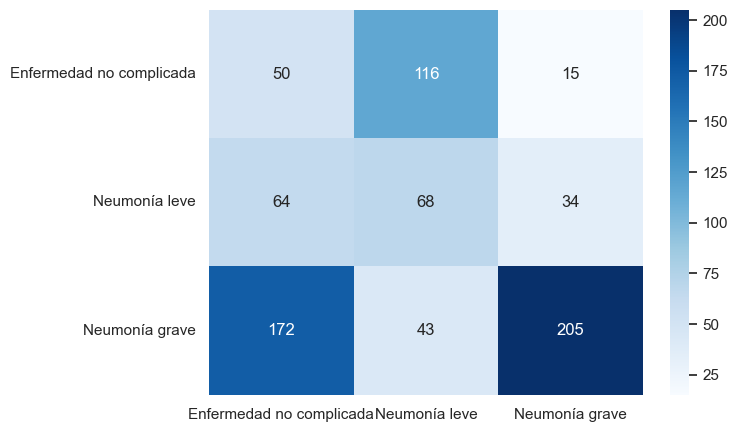

In [554]:
from sklearn.metrics import confusion_matrix

#los labels se deben colocar en el orden de los cluster (número). 
cm_labels = [ 'Enfermedad no complicada', 'Neumonía leve', 'Neumonía grave'   ]

cm = confusion_matrix(df_kmedoids_clusters['y_true'], df_kmedoids_clusters['Cluster'])

cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.heatmap(cm_array_df,  annot=True, fmt='g', cmap='Blues' )
plt.show() 

In [555]:
pivot = pd.pivot_table(df_kmedoids_clusters, index=['Cluster'], columns='Muerte', aggfunc='size')
pivot2 = pd.pivot_table(df_kmedoids_clusters, index=['Gravedad'], columns='Muerte', aggfunc='size')
concat = pd.concat([pivot, pivot2])
concat['%muerte'] = 100*(concat[1]/(concat[1]+concat[0]))
concat

Muerte                      0    1    %muerte
0                         249   37  12.937063
1                         204   23  10.132159
2                         117  137  53.937008
Enfermedad no complicada  179    2   1.104972
Neumonia grave            251  169  40.238095
Neumonia leve             140   26  15.662651

# K-Means

In [556]:
from sklearn.cluster import KMeans

num_clusters = 3  # ajustar!
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_kmeans = kmeans.fit_predict(X_pca_9)


C:\Users\Usuario\anaconda3\envs\CDP_2\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [557]:
silhouette_avg = silhouette_score(X_pca_9, kmeans.labels_)

print(f"El coeficiente de silhouette promedio para 40 clusters es: {silhouette_avg}")

El coeficiente de silhouette promedio para 40 clusters es: 0.18142524856052597


In [558]:
varianza_intra_cluster = []
silhouettes = []
Y = {}
silhouette = 0
for k in range (1, 50): # Evaluamos entre 1 a 50 clusters
    kmeans = KMeans(n_clusters = k, random_state = 123, n_init=10).fit(X_pca_9)
    varianza_intra_cluster.append(kmeans.inertia_)
    try:
        silhouette = silhouette_score(X_pca_9, kmeans.labels_)
    except:
        silhouette = 0 
    silhouettes.append(silhouette)
    Y[k] = kmeans.labels_

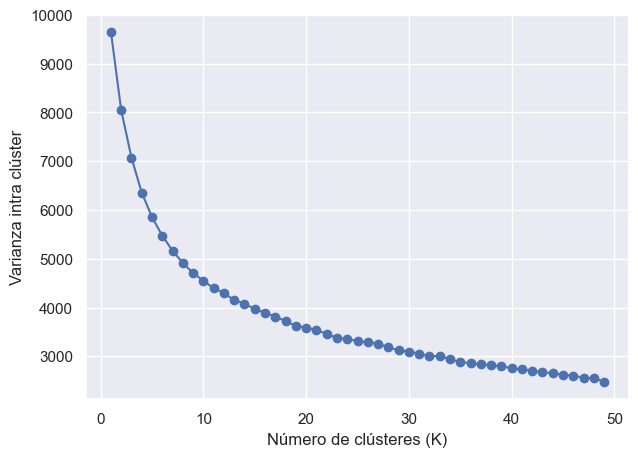

In [559]:
plt.plot(range(1, 50), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

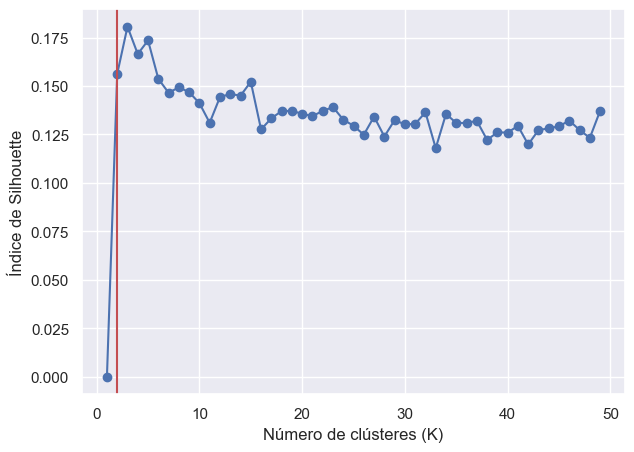

In [560]:
plt.plot(range(1, 50), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.axvline(x = silhouettes.index(max(silhouettes)), color = 'r', label = 'axvline - full height')
plt.ylabel('Índice de Silhouette')
plt.show()

In [561]:
print(f'el valor estimado como número adecuado de clúster es: {silhouettes.index(max(silhouettes))}')

el valor estimado como número adecuado de clúster es: 2


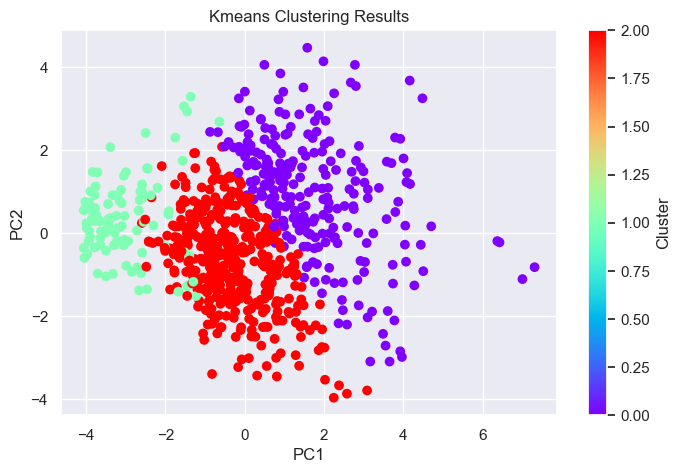

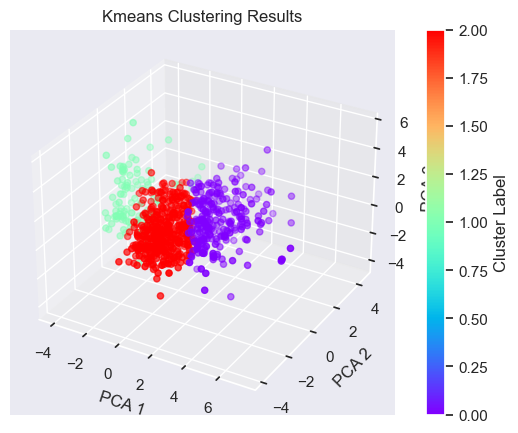

In [562]:
fig = plt.figure(figsize=(8,5))
plt.scatter(X_pca_9[:, 0], X_pca_9[:, 1], c=cluster_kmeans, cmap='rainbow')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Kmeans Clustering Results')
plt.colorbar(label='Cluster')
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_9[:, 0], X_pca_9[:, 1], X_pca_9[:, 2], c=cluster_kmeans, cmap='rainbow')

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('Kmeans Clustering Results')

legend = plt.colorbar(scatter, ax=ax)
legend.set_label('Cluster Label')

plt.show()

In [563]:
df_kmeans_clusters = df_1.copy()
df_kmeans_clusters['Cluster'] = cluster_kmeans
#df_kmeans_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
print(df_kmeans_clusters['Cluster'].unique())
df_kmeans_clusters
#df_kmeans_clusters.to_excel("kmeans_4.xlsx", index=False)

[0 2 1]


CURB-65_calculado  Creatinina ingreso  Edad (años)  FC ingreso  \
0                    2                1.50           52       100.0   
1                    3                2.09           71        84.0   
2                    0                1.40           28       114.0   
3                    0                0.83           40       106.0   
4                    0                1.03           46        80.0   
..                 ...                 ...          ...         ...   
769                  1                0.92           70        94.0   
770                  0                0.85           44        84.0   
771                  0                0.67           47       100.0   
772                  1                1.03           65        77.0   
773                  1                0.83           53        92.0   

     FR ingreso  Hb ingreso  Hombre  Indice de Charlson  Leucocitos ingreso  \
0          36.0        14.0       1                   1              7870.0   
1          33.0         9.5       0                   3             14330.0   
2          20.0        14.9       0                   0              4950.0   
3          18.0        11.0       0                   0              6490.0   
4          20.0        15.4       1                   0              6750.0   
..          ...         ...     ...                 ...                 ...   
769        18.0        13.5       0                   3              4860.0   
770        20.0        15.2       1                   0              4460.0   
771        18.0        17.5       1                   2              7660.0   
772        22.0        16.5       1                   3              9680.0   
773        33.0        17.1       1                   1              3420.0   

     Oxigeno suplementario  Plaquetas ingreso  Sat02 ingreso  \
0                        1           144000.0           82.0   
1                        1           424000.0           83.0   
2                        1           145000.0           96.0   
3                        0           399000.0           95.0   
4                        1           152000.0           93.0   
..                     ...                ...            ...   
769                      1           324000.0           90.0   
770                      1           340000.0           80.0   
771                      1           283000.0           85.0   
772                      1           340000.0           83.0   
773                      1           255000.0           90.0   

     Score News2_calculado  T ingreso         TAM  Cluster  
0                        9       36.3  108.666667        0  
1                        8       36.5  112.666667        0  
2                        4       38.0  101.000000        2  
3                        3       36.0  113.666667        1  
4                        5       38.5   93.333333        2  
..                     ...        ...         ...      ...  
769                      6       36.5  109.666667        2  
770                      5       36.8   94.666667        2  
771                      7       36.0   93.333333        2  
772                      7       37.0  105.333333        2  
773                      9       36.8   94.666667        2  

[767 rows x 16 columns]

In [564]:
df_kmeans_clusters['UCI'] = df_imputed_multiple['Ingreso a UCI']
df_kmeans_clusters['Muerte'] = df_imputed_multiple['Muerto_si_no']
df_kmeans_clusters.groupby('Cluster' ).agg(['mean']).T

Cluster                                 0              1              2
CURB-65_calculado     mean       1.857708       0.158416       0.430993
Creatinina ingreso    mean       1.726008       0.972376       0.940000
Edad (años)           mean      73.260870      41.049505      50.605327
FC ingreso            mean      92.715415      87.326733      95.937046
FR ingreso            mean      22.976285      18.712871      21.556901
Hb ingreso            mean      13.528775      13.940693      14.647651
Hombre                mean       0.584980       0.455446       0.677966
Indice de Charlson    mean       4.086957       0.702970       1.055690
Leucocitos ingreso    mean   10767.110672    7419.603960    9382.184019
Oxigeno suplementario mean       0.996047       0.019802       0.997579
Plaquetas ingreso     mean  247390.909091  304049.504950  265832.687651
Sat02 ingreso         mean      83.695652      94.762376      88.027845
Score News2_calculado mean       7.494071       1.851485       6.585956
T ingreso             mean      36.618577      36.794059      36.712349
TAM                   mean      91.649539      89.716172      94.648103
UCI                   mean       0.521739       0.000000       0.278450
Muerte                mean       0.529644       0.000000       0.152542

In [565]:
df_kmeans_clusters['Gravedad'] = le.inverse_transform(df_imputed_multiple['Gravedad del COVID-19'])
df_kmeans_clusters.groupby('Gravedad' ).agg(['mean']).T

Gravedad                    Enfermedad no complicada  Neumonia grave  \
CURB-65_calculado     mean                  0.375691        1.133333   
Creatinina ingreso    mean                  1.017624        1.333667   
Edad (años)           mean                 47.453039       60.942857   
FC ingreso            mean                 88.745856       97.378571   
FR ingreso            mean                 19.646409       23.040476   
Hb ingreso            mean                 14.133315       14.150238   
Hombre                mean                  0.574586        0.652381   
Indice de Charlson    mean                  1.116022        2.428571   
Leucocitos ingreso    mean               7942.756906    10627.878571   
Oxigeno suplementario mean                  0.480663        0.992857   
Plaquetas ingreso     mean             279723.756906   256637.142857   
Sat02 ingreso         mean                 94.182320       82.458333   
Score News2_calculado mean                  3.662983        7.714286   
T ingreso             mean                 36.718785       36.713810   
TAM                   mean                 91.263352       93.792063   
Cluster               mean                  1.287293        1.095238   
UCI                   mean                  0.016575        0.523810   
Muerte                mean                  0.011050        0.402381   

Gravedad                    Neumonia leve  
CURB-65_calculado     mean       0.722892  
Creatinina ingreso    mean       1.076988  
Edad (años)           mean      56.602410  
FC ingreso            mean      89.981928  
FR ingreso            mean      20.319277  
Hb ingreso            mean      14.331566  
Hombre                mean       0.578313  
Indice de Charlson    mean       1.921687  
Leucocitos ingreso    mean    8716.584337  
Oxigeno suplementario mean       0.975904  
Plaquetas ingreso     mean  269097.590361  
Sat02 ingreso         mean      92.903614  
Score News2_calculado mean       5.421687  
T ingreso             mean      36.608434  
TAM                   mean      92.933735  
Cluster               mean       1.409639  
UCI                   mean       0.144578  
Muerte                mean       0.156627

In [566]:
df_kmeans_clusters['y_true'] = df_kmeans_clusters['Gravedad'].map({'Neumonia grave':0, 
                                                                 'Enfermedad no complicada': 1,
                                                                 'Neumonia leve':2})
df_kmeans_clusters.head()

#df_kmeans_clusters.to_excel("kmeans_matrix.xlsx", index=False)

CURB-65_calculado  Creatinina ingreso  Edad (años)  FC ingreso  FR ingreso  \
0                  2                1.50           52       100.0        36.0   
1                  3                2.09           71        84.0        33.0   
2                  0                1.40           28       114.0        20.0   
3                  0                0.83           40       106.0        18.0   
4                  0                1.03           46        80.0        20.0   

   Hb ingreso  Hombre  Indice de Charlson  Leucocitos ingreso  \
0        14.0       1                   1              7870.0   
1         9.5       0                   3             14330.0   
2        14.9       0                   0              4950.0   
3        11.0       0                   0              6490.0   
4        15.4       1                   0              6750.0   

   Oxigeno suplementario  Plaquetas ingreso  Sat02 ingreso  \
0                      1           144000.0           82.0   
1                      1           424000.0           83.0   
2                      1           145000.0           96.0   
3                      0           399000.0           95.0   
4                      1           152000.0           93.0   

   Score News2_calculado  T ingreso         TAM  Cluster  UCI  Muerte  \
0                      9       36.3  108.666667        0    1       0   
1                      8       36.5  112.666667        0    1       1   
2                      4       38.0  101.000000        2    0       0   
3                      3       36.0  113.666667        1    0       0   
4                      5       38.5   93.333333        2    0       0   

                   Gravedad  y_true  
0            Neumonia grave       0  
1            Neumonia grave       0  
2  Enfermedad no complicada       1  
3  Enfermedad no complicada       1  
4             Neumonia leve       2

In [567]:
from sklearn.metrics import adjusted_rand_score
y_true = df_kmeans_clusters['y_true']
y_pred = df_kmeans_clusters['Cluster']

ari_score = adjusted_rand_score(y_true, y_pred)

print(f"ARI Score: {ari_score}")

ARI Score: 0.12976200646050873


In [568]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [569]:
from scipy.optimize import linear_sum_assignment as linear_assignment
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(w.max() - w)
accu = sum([w[i, j] for i, j in zip(ind[0],ind[1])]) * 1.0 / y_pred.size
print("El accuracy es:", accu)

El accuracy es: 0.516297262059974


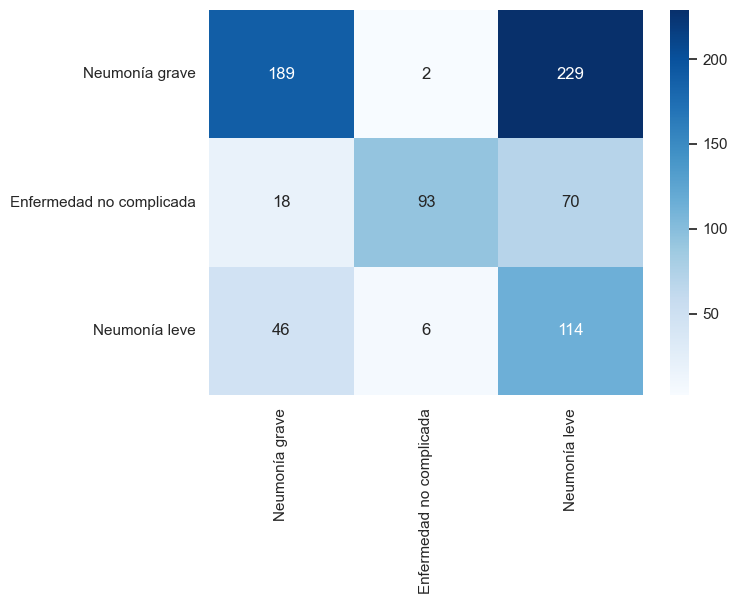

In [570]:
from sklearn.metrics import confusion_matrix

cm_labels = ['Neumonía grave', 'Enfermedad no complicada', 'Neumonía leve' ]

cm = confusion_matrix(df_kmeans_clusters['y_true'], df_kmeans_clusters['Cluster'])

cm_array_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.heatmap(cm_array_df,  annot=True, fmt='g', cmap='Blues' )
plt.show() 

C:\Users\Usuario\anaconda3\envs\CDP_2\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Usuario\anaconda3\envs\CDP_2\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Usuario\anaconda3\envs\CDP_2\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Usuario\anaconda3\envs\CDP_2\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

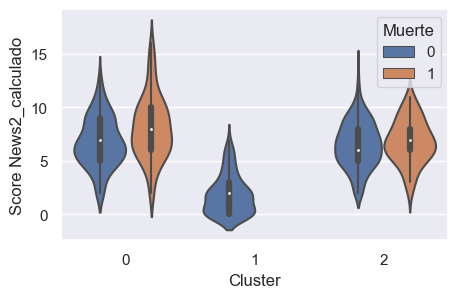

In [571]:
sns.set(rc={'figure.figsize':(5,3)})
sns.violinplot(data = df_kmeans_clusters, x = 'Cluster', y = 'Score News2_calculado', hue = 'Muerte')
plt.show() 

In [572]:
pivot = pd.pivot_table(df_kmeans_clusters, index=['Cluster'], columns='Muerte', aggfunc='size')
pivot2 = pd.pivot_table(df_kmeans_clusters, index=['Gravedad'], columns='Muerte', aggfunc='size')
concat = pd.concat([pivot, pivot2])
concat['%muerte'] = 100*(concat[1]/(concat[1]+concat[0]))
concat

Muerte                        0      1    %muerte
0                         119.0  134.0  52.964427
1                         101.0    NaN        NaN
2                         350.0   63.0  15.254237
Enfermedad no complicada  179.0    2.0   1.104972
Neumonia grave            251.0  169.0  40.238095
Neumonia leve             140.0   26.0  15.662651

In [573]:
import session_info

session_info.show(html=False)

-----
kneed               0.8.5
matplotlib          3.7.1
miceforest          5.6.3
mpl_toolkits        NA
numpy               1.26.0
pandas              2.1.1
pca                 2.0.5
scipy               1.11.2
seaborn             0.12.2
session_info        1.0.0
sklearn             1.3.1
sklearn_extra       0.3.0
-----
IPython             8.15.0
jupyter_client      8.3.1
jupyter_core        5.3.1
jupyterlab          4.0.6
notebook            7.0.4
-----
Python 3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:23:48) [MSC v.1936 64 bit (AMD64)]
Windows-10-10.0.19045-SP0
-----
Session information updated at 2023-09-27 18:55


In [574]:
#pip install matplotlib==3.7.1 --user